In [75]:
class config:
    run_type = 'colab'
    random_seed = 2022
    nfold = 5
    target = 'pm25_mid'

In [76]:
# import os
# import re
# from IPython.lib import kernel
# from requests import get

# if config.run_type == 'colab':
#     from google.colab import drive, files
    
#     drive.mount('/Users/motokifukasawa')
#     #ご自身のフォルダパスを指定
#     Drive = "/Users/motokifukasawa/SIGNATE/ソニーグループ合同 データ分析コンペティション（for Recruiting） 大気中の汚染物質濃度の予測に挑戦しよう！"
#     Exp = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'][:-6]
#     Exp = re.sub('.ip', '', Exp)
    
# elif config.run_type == 'local':
#     import ipynb_path
#     Drive = os.getcwd()
#     Exp = re.sub(r'\\|/', ' ', ipynb_path.get()).split()
#     Exp = Exp[len(Exp)-1]
#     Exp = re.sub(r'\.ipynb', '', Exp)
        
# Input = os.path.join(Drive, 'input')
# Output = os.path.join(Drive, 'output')
# Output_Exp = os.path.join(Output, Exp)
# Output_Model = os.path.join(Output_Exp, "model")
# Output_Preds = os.path.join(Output_Exp, "preds")
# Output_Feats = os.path.join(Output_Exp, "feats")

# Submission = os.path.join(Drive, "submission")

# dirs = [Output_Model, Output_Preds, Output_Feats]
# for d in dirs:
#     if not os.path.isdir(d):
#         os.makedirs(d, exist_ok=True)

In [77]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gc
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import datetime

from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

pd.set_option('max_rows', 400)
pd.set_option('max_columns', 100)

In [78]:
train_data = pd.read_csv('train.csv')\
               .assign(timestamp=lambda d: pd.to_datetime(d['year'].astype(str) + '-' + d['month'].astype(str) + '-' + d['day'].astype(str)))
test_data = pd.read_csv('test.csv')\
               .assign(timestamp=lambda d: pd.to_datetime(d['year'].astype(str) + '-' + d['month'].astype(str) + '-' + d['day'].astype(str)))

In [79]:
train_data.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,co_mid,co_max,co_var,o3_cnt,o3_min,o3_mid,o3_max,o3_var,so2_cnt,so2_min,so2_mid,so2_max,so2_var,no2_cnt,no2_min,no2_mid,no2_max,no2_var,temperature_cnt,temperature_min,temperature_mid,temperature_max,temperature_var,humidity_cnt,humidity_min,humidity_mid,humidity_max,humidity_var,pressure_cnt,pressure_min,pressure_mid,pressure_max,pressure_var,ws_cnt,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid,timestamp
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,2.590,2.633,0.850,29,2.397,4.295,5.916,3.017,11,0.149,0.468,0.900,0.137,36,0.000,0.529,2.188,1.167,36,10.956,14.038,20.866,23.880,45,30.207,70.426,94.202,994.051,59,1004.137,1015.721,1023.398,89.588,42,0.241,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901,2019-01-01
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,3.181,4.828,1.208,49,3.092,7.572,12.332,20.524,31,0.096,0.102,16.152,61.550,45,0.099,0.301,5.411,6.401,71,24.113,30.125,36.678,37.327,50,49.034,74.276,92.975,467.112,69,938.085,970.252,1080.000,7.320,48,0.828,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741,2019-01-01
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,1.197,2.200,0.248,123,0.736,12.527,23.432,125.224,36,1.392,1.464,47.652,515.570,111,0.972,2.751,12.230,30.518,148,0.000,0.000,23.226,131.280,138,25.919,69.069,100.000,1292.191,153,880.000,880.000,1018.200,4655.348,125,0.000,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918,2019-01-01
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,11.044,14.802,24.186,90,1.917,14.141,38.374,304.731,50,2.957,3.230,14.056,25.630,176,14.959,17.471,24.221,20.883,101,16.423,19.819,20.044,3.188,111,73.504,86.920,100.000,85.028,141,1011.703,1016.545,1018.364,10.898,52,0.284,0.503,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370,2019-01-01
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,8.681,11.100,10.011,83,0.349,2.349,38.600,353.549,47,0.422,5.794,9.972,9.234,80,14.911,21.140,32.584,74.298,55,10.297,11.822,13.377,2.311,155,51.918,76.736,96.533,484.188,124,1019.521,1022.992,1027.611,15.142,102,0.500,0.755,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063,2019-01-01


In [80]:
test_data.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,co_mid,co_max,co_var,o3_cnt,o3_min,o3_mid,o3_max,o3_var,so2_cnt,so2_min,so2_mid,so2_max,so2_var,no2_cnt,no2_min,no2_mid,no2_max,no2_var,temperature_cnt,temperature_min,temperature_mid,temperature_max,temperature_var,humidity_cnt,humidity_min,humidity_mid,humidity_max,humidity_var,pressure_cnt,pressure_min,pressure_mid,pressure_max,pressure_var,ws_cnt,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,timestamp
0,195942,2019,1,1,Australia,Adelaide,-34.92866,138.59863,155,0.091,0.101,0.195,0.003,167,0.000,0.000,0.000,0.000,12,0.095,0.098,0.106,0.000,118,0.097,0.099,0.105,0.000,168,13.226,23.461,33.922,104.054,180,17.795,34.081,90.636,1282.735,154,934.478,944.740,1029.990,11.067,111,0.098,2.411,10.213,24.608,26,3.057,8.180,15.841,39.705,2019-01-01
1,195943,2019,1,1,Australia,Sydney,-33.86785,151.20732,23,1.037,2.272,3.391,1.347,142,7.797,34.414,59.489,630.329,54,1.476,1.531,5.380,3.709,147,1.139,4.117,24.680,132.975,176,21.676,27.487,36.453,52.606,177,30.139,55.590,87.970,805.448,184,979.216,1008.498,1014.100,65.343,158,0.101,2.982,8.261,15.957,47,11.090,15.361,19.227,15.857,2019-01-01
2,195944,2019,1,1,Belgium,Brussels,50.85045,4.34878,28,0.096,0.101,0.104,0.000,114,7.064,16.576,27.246,97.445,9,0.566,0.600,0.626,0.000,151,1.362,5.372,16.268,53.080,172,5.402,7.786,9.754,4.564,163,70.948,80.069,96.067,148.232,159,936.950,1047.096,1080.000,19.318,64,0.218,1.200,5.802,7.584,44,1.055,4.411,6.955,8.415,2019-01-01
3,195945,2019,1,1,Bosnia and Herzegovina,Sarajevo,43.84864,18.35644,122,0.479,4.589,16.560,60.820,118,0.513,22.445,51.638,625.291,138,1.551,12.523,60.551,819.667,141,0.467,7.609,30.975,221.357,132,-4.840,0.976,4.849,22.794,139,55.585,100.000,100.000,479.874,132,950.173,985.215,1043.932,76.454,149,0.504,1.172,3.861,2.696,16,0.482,0.484,0.932,0.049,2019-01-01
4,195946,2019,1,1,Brazil,São José dos Campos,-23.17944,-45.88694,158,6.198,13.478,20.327,36.498,129,1.063,1.845,27.894,166.269,92,1.568,4.365,14.958,42.456,126,9.118,16.171,48.517,354.133,102,5.526,7.388,21.291,57.069,123,68.233,87.176,99.879,237.783,131,1001.341,1015.044,1017.836,50.092,164,0.409,1.412,3.132,1.754,165,6.253,11.440,12.473,3.546,2019-01-01


In [81]:
def make_corr_array(df, cols):
    output = pd.DataFrame(1 - squareform(pdist(df[cols].T, 'correlation')),
                          columns=cols, index=cols)
    return output

In [82]:
corr_df = make_corr_array(train_data, [c for c in train_data.columns if re.search(r'mid|min|max|cnt|lat|lon', c)])

<AxesSubplot:>

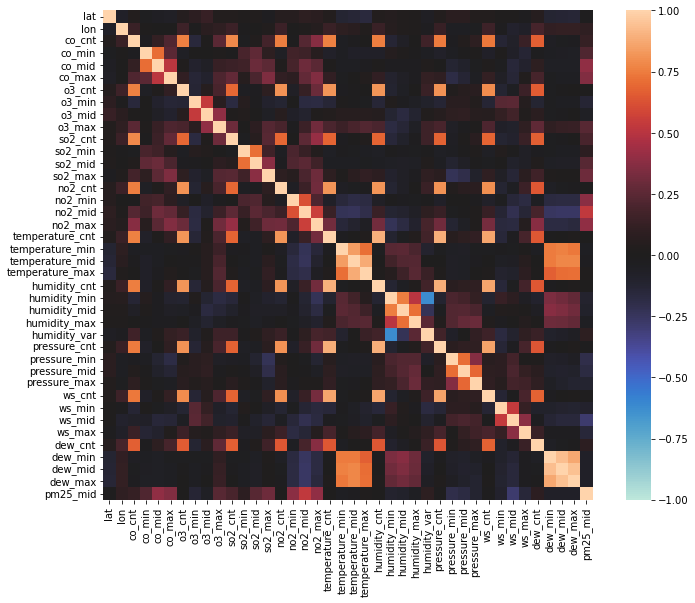

In [83]:
fig, ax = plt.subplots(figsize=(12, 9)) 
sns.heatmap(corr_df, square=True, vmax=1, vmin=-1, center=0)

In [84]:
corr_top10 = corr_df.loc[:, ['pm25_mid']].assign(abs_value=lambda d: np.abs(d['pm25_mid']))\
                    .sort_values('abs_value', ascending=False)\
                    .iloc[1:11, :].index.tolist()
corr_top10

['no2_mid',
 'co_mid',
 'no2_max',
 'no2_min',
 'co_max',
 'so2_max',
 'ws_mid',
 'so2_mid',
 'o3_max',
 'co_min']

In [85]:
class AbstractBaseBlock:
    def fit(self, input_df: pd.DataFrame, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()

In [86]:
class NumericFeatBlock(AbstractBaseBlock):
    def __init__(self, col: str):
        self.col = col
        
    def fit(self, input_df, y=None):
        pass
        
    def transform(self, input_df):
        return input_df.loc[:, self.col]

In [87]:
class CategoricalFeatBlock(AbstractBaseBlock):
    def __init__(self, col: str, whole_df = None, threshold=0.001, is_label=True, is_dummy=False):
        self.col = col
        self.whole_df = whole_df
        self.threshold = threshold
        self.is_label = is_label
        self.is_dummy = is_dummy
    
    def fit(self, input_df, y=None):
        if self.whole_df == None:
            df = input_df.loc[:, self.col]
        else:
            df = self.whole_df.loc[:, self.col]
        vc = df.value_counts(normalize=True).reset_index()
        vc = vc.assign(thresh=lambda d: np.where(d[self.col].values >= self.threshold, 1, 0))\
               .assign(thresh=lambda d: d['thresh'].cumsum() - d['thresh'])
        self.label_dict_ = dict(vc[['index', 'thresh']].values)
        self.label_other_ = np.max(self.label_dict_.values())
        
        return self.transform(input_df)
        
    def transform(self, input_df):
        out_df = pd.DataFrame()
        label_df = pd.DataFrame()
        label_df[f'{self.col}_label_enc'] = np.vectorize(lambda x: self.label_dict_.get(x, self.label_other_))\
                                                        (input_df[self.col].values)
        if self.is_label:
            out_df = pd.concat([out_df, label_df], axis=1)
            
        if self.is_dummy:
            label_df[f'{self.col}_label_enc'] = label_df[f'{self.col}_label_enc'].astype(object)
            out_df = pd.concat([out_df, pd.get_dummies(label_df)], axis=1)
        
        return out_df

In [88]:
import datetime as dt
class DateFeatureBlock(AbstractBaseBlock):
    def __init__(self, is_get_weekday=True):
        self.is_get_weekday = is_get_weekday
        
    def fit(self, input_df, y=None):
        pass
        
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df = input_df[['year', 'month', 'day']]
        out_df['date'] = input_df.loc[:,'timestamp']
        out_df['date'] = (out_df['date'] - dt.datetime(2019,1,1)).dt.days
        if self.is_get_weekday:
            out_df = out_df.assign(weekday=[x.dayofweek for x in input_df['timestamp'].tolist()])
        
        return out_df

In [89]:
class AggregateValueBlock(AbstractBaseBlock):
    def __init__(self, key_col, agg_dict, whole_df=None):
        self.key_col = key_col
        self.agg_dict = agg_dict
        self.whole_df = whole_df
        
    def fit(self, input_df, y=None):
        if self.whole_df == None:
            df = input_df
        else:
            df = self.whole_df
        agg_df = df.groupby(self.key_col).agg(self.agg_dict)
        agg_df.columns = ['_'.join(c) for c in agg_df.columns]
        self.agg_df_ = agg_df.add_prefix('_')\
                             .add_prefix('_'.join(self.key_col))\
                             .add_prefix('agg_').reset_index()
        
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df = pd.merge(input_df[self.key_col], self.agg_df_, how='left', on=self.key_col)\
                   .drop(self.key_col, axis=1)\
                   .fillna(0)
        
        return out_df

In [90]:
numeric_columns = [c for c in train_data.columns if re.search(r'max|mid|min|cnt|lat|lon', c) and not re.search(r'pm25', c)]
categorical_columns = ['Country']
agg_country_value = dict([(c, [np.mean, np.max, np.min, np.std]) for c in corr_top10])

In [91]:
run_blocks = [
    *[NumericFeatBlock(c) for c in [numeric_columns]],
    *[CategoricalFeatBlock(c) for c in categorical_columns],
    *[DateFeatureBlock()],
    *[AggregateValueBlock(['Country', 'month'], agg_country_value)],    
]

In [92]:
def get_train_data(input_df, feat_blocks, y=None, fit_df=None):
    if fit_df is None:
        fit_df = input_df.copy()
        
    for block in feat_blocks:
        block.fit(fit_df, y)
        
    out = [block.transform(input_df) for block in feat_blocks]
    out = pd.concat(out, axis=1)
    
    return out

def get_test_data(input_df, feat_blocks):
    
    out = [block.transform(input_df) for block in feat_blocks]
    out = pd.concat(out, axis=1)
    
    return out

In [93]:
df_train = get_train_data(train_data, run_blocks, fit_df=pd.concat([train_data, test_data], ignore_index=True))
df_train['co_mid_times_no2_mid'] = df_train['co_mid']*df_train['no2_mid']
df_train

/var/folders/p1/k0mf0qwj2j977jcnn4sng3cm0000gn/T/ipykernel_12516/4290321765.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_df['date'] = input_df.loc[:,'timestamp']
/var/folders/p1/k0mf0qwj2j977jcnn4sng3cm0000gn/T/ipykernel_12516/4290321765.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_df['date'] = (out_df['date'] - dt.datetime(2019,1,1)).dt.days


,lat,lon,co_cnt,co_min,co_mid,co_max,o3_cnt,o3_min,o3_mid,o3_max,so2_cnt,so2_min,so2_mid,so2_max,no2_cnt,no2_min,no2_mid,no2_max,temperature_cnt,temperature_min,temperature_mid,temperature_max,humidity_cnt,humidity_min,humidity_mid,humidity_max,humidity_var,pressure_cnt,pressure_min,pressure_mid,pressure_max,ws_cnt,ws_min,ws_mid,ws_max,dew_cnt,dew_min,dew_mid,dew_max,Country_label_enc,year,month,day,date,weekday,agg_Country_month_no2_mid_mean,agg_Country_month_no2_mid_amax,agg_Country_month_no2_mid_amin,agg_Country_month_no2_mid_std,agg_Country_month_co_mid_mean,agg_Country_month_co_mid_amax,agg_Country_month_co_mid_amin,agg_Country_month_co_mid_std,agg_Country_month_no2_max_mean,agg_Country_month_no2_max_amax,agg_Country_month_no2_max_amin,agg_Country_month_no2_max_std,agg_Country_month_no2_min_mean,agg_Country_month_no2_min_amax,agg_Country_month_no2_min_amin,agg_Country_month_no2_min_std,agg_Country_month_co_max_mean,agg_Country_month_co_max_amax,agg_Country_month_co_max_amin,agg_Country_month_co_max_std,agg_Country_month_so2_max_mean,agg_Country_month_so2_max_amax,agg_Country_month_so2_max_amin,agg_Country_month_so2_max_std,agg_Country_month_ws_mid_mean,agg_Country_month_ws_mid_amax,agg_Country_month_ws_mid_amin,agg_Country_month_ws_mid_std,agg_Country_month_so2_mid_mean,agg_Country_month_so2_mid_amax,agg_Country_month_so2_mid_amin,agg_Country_month_so2_mid_std,agg_Country_month_o3_max_mean,agg_Country_month_o3_max_amax,agg_Country_month_o3_max_amin,agg_Country_month_o3_max_std,agg_Country_month_co_min_mean,agg_Country_month_co_min_amax,agg_Country_month_co_min_amin,agg_Country_month_co_min_std,co_mid_times_no2_mid
0,-27.46794,153.02809,38,0.749,2.590,2.633,29,2.397,4.295,5.916,11,0.149,0.468,0.900,36,0.000,0.529,2.188,36,10.956,14.038,20.866,45,30.207,70.426,94.202,994.051,59,1004.137,1015.721,1023.398,42,0.241,1.088,3.101,17,7.671,10.358,15.112,10,2019,1,1,0,1,6.669456,38.018,0.095,6.389357,3.256152,20.272,0.040,3.104306,17.718835,67.282,0.096,13.110455,2.492414,17.962,0.000,3.422229,6.240017,42.192,0.069,5.745370,7.232384,54.925,0.099,8.029337,2.669814,8.075,0.000,1.469563,2.385929,18.539,0.094,2.142337,28.888395,113.124,0.000,18.787270,1.723688,14.106,0.0,1.844704,1.370110
1,-12.46113,130.84185,47,2.594,3.181,4.828,49,3.092,7.572,12.332,31,0.096,0.102,16.152,45,0.099,0.301,5.411,71,24.113,30.125,36.678,50,49.034,74.276,92.975,467.112,69,938.085,970.252,1080.000,48,0.828,3.473,7.396,62,21.324,23.813,24.221,10,2019,1,1,0,1,6.669456,38.018,0.095,6.389357,3.256152,20.272,0.040,3.104306,17.718835,67.282,0.096,13.110455,2.492414,17.962,0.000,3.422229,6.240017,42.192,0.069,5.745370,7.232384,54.925,0.099,8.029337,2.669814,8.075,0.000,1.469563,2.385929,18.539,0.094,2.142337,28.888395,113.124,0.000,18.787270,1.723688,14.106,0.0,1.844704,0.957481
2,-37.81400,144.96332,17,1.190,1.197,2.200,123,0.736,12.527,23.432,36,1.392,1.464,47.652,111,0.972,2.751,12.230,148,0.000,0.000,23.226,138,25.919,69.069,100.000,1292.191,153,880.000,880.000,1018.200,125,0.000,2.107,8.089,22,10.309,13.133,15.422,10,2019,1,1,0,1,6.669456,38.018,0.095,6.389357,3.256152,20.272,0.040,3.104306,17.718835,67.282,0.096,13.110455,2.492414,17.962,0.000,3.422229,6.240017,42.192,0.069,5.745370,7.232384,54.925,0.099,8.029337,2.669814,8.075,0.000,1.469563,2.385929,18.539,0.094,2.142337,28.888395,113.124,0.000,18.787270,1.723688,14.106,0.0,1.844704,3.292947
3,-32.92953,151.78010,63,4.586,11.044,14.802,90,1.917,14.141,38.374,50,2.957,3.230,14.056,176,14.959,17.471,24.221,101,16.423,19.819,20.044,111,73.504,86.920,100.000,85.028,141,1011.703,1016.545,1018.364,52,0.284,0.503,3.592,116,7.146,10.685,13.344,10,2019,1,1,0,1,6.669456,38.018,0.095,6.389357,3.256152,20.272,0.040,3.104306,17.718835,67.282,0.096,13.110455,2.492414,17.962,0.000,3.422229,6.240017,42.192,0.069,5.745370,7.232384,54.925,0.099,8.029337,2.669814,8.075,0.000,1.469563,2.385929,18.539,0.094,2.142337,28.888395,113.124,0.000,18.787270,1.723688,14.106,0.0,1.844704,192.949724
4,-31.95224,115.86140,47,4.689,8.681

In [94]:
df_test = get_test_data(test_data, run_blocks)
df_test['co_mid_times_no2_mid'] = df_test['co_mid']*df_test['no2_mid']
df_test

/var/folders/p1/k0mf0qwj2j977jcnn4sng3cm0000gn/T/ipykernel_12516/4290321765.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_df['date'] = input_df.loc[:,'timestamp']
/var/folders/p1/k0mf0qwj2j977jcnn4sng3cm0000gn/T/ipykernel_12516/4290321765.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_df['date'] = (out_df['date'] - dt.datetime(2019,1,1)).dt.days


,lat,lon,co_cnt,co_min,co_mid,co_max,o3_cnt,o3_min,o3_mid,o3_max,so2_cnt,so2_min,so2_mid,so2_max,no2_cnt,no2_min,no2_mid,no2_max,temperature_cnt,temperature_min,temperature_mid,temperature_max,humidity_cnt,humidity_min,humidity_mid,humidity_max,humidity_var,pressure_cnt,pressure_min,pressure_mid,pressure_max,ws_cnt,ws_min,ws_mid,ws_max,dew_cnt,dew_min,dew_mid,dew_max,Country_label_enc,year,month,day,date,weekday,agg_Country_month_no2_mid_mean,agg_Country_month_no2_mid_amax,agg_Country_month_no2_mid_amin,agg_Country_month_no2_mid_std,agg_Country_month_co_mid_mean,agg_Country_month_co_mid_amax,agg_Country_month_co_mid_amin,agg_Country_month_co_mid_std,agg_Country_month_no2_max_mean,agg_Country_month_no2_max_amax,agg_Country_month_no2_max_amin,agg_Country_month_no2_max_std,agg_Country_month_no2_min_mean,agg_Country_month_no2_min_amax,agg_Country_month_no2_min_amin,agg_Country_month_no2_min_std,agg_Country_month_co_max_mean,agg_Country_month_co_max_amax,agg_Country_month_co_max_amin,agg_Country_month_co_max_std,agg_Country_month_so2_max_mean,agg_Country_month_so2_max_amax,agg_Country_month_so2_max_amin,agg_Country_month_so2_max_std,agg_Country_month_ws_mid_mean,agg_Country_month_ws_mid_amax,agg_Country_month_ws_mid_amin,agg_Country_month_ws_mid_std,agg_Country_month_so2_mid_mean,agg_Country_month_so2_mid_amax,agg_Country_month_so2_mid_amin,agg_Country_month_so2_mid_std,agg_Country_month_o3_max_mean,agg_Country_month_o3_max_amax,agg_Country_month_o3_max_amin,agg_Country_month_o3_max_std,agg_Country_month_co_min_mean,agg_Country_month_co_min_amax,agg_Country_month_co_min_amin,agg_Country_month_co_min_std,co_mid_times_no2_mid
0,-34.92866,138.59863,155,0.091,0.101,0.195,167,0.000,0.000,0.000,12,0.095,0.098,0.106,118,0.097,0.099,0.105,168,13.226,23.461,33.922,180,17.795,34.081,90.636,1282.735,154,934.478,944.740,1029.990,111,0.098,2.411,10.213,26,3.057,8.180,15.841,10,2019,1,1,0,1,6.669456,38.018,0.095,6.389357,3.256152,20.272,0.040,3.104306,17.718835,67.282,0.096,13.110455,2.492414,17.962,0.000,3.422229,6.240017,42.192,0.069,5.745370,7.232384,54.925,0.099,8.029337,2.669814,8.075,0.000,1.469563,2.385929,18.539,0.094,2.142337,28.888395,113.124,0.000,18.787270,1.723688,14.106,0.000,1.844704,0.009999
1,-33.86785,151.20732,23,1.037,2.272,3.391,142,7.797,34.414,59.489,54,1.476,1.531,5.380,147,1.139,4.117,24.680,176,21.676,27.487,36.453,177,30.139,55.590,87.970,805.448,184,979.216,1008.498,1014.100,158,0.101,2.982,8.261,47,11.090,15.361,19.227,10,2019,1,1,0,1,6.669456,38.018,0.095,6.389357,3.256152,20.272,0.040,3.104306,17.718835,67.282,0.096,13.110455,2.492414,17.962,0.000,3.422229,6.240017,42.192,0.069,5.745370,7.232384,54.925,0.099,8.029337,2.669814,8.075,0.000,1.469563,2.385929,18.539,0.094,2.142337,28.888395,113.124,0.000,18.787270,1.723688,14.106,0.000,1.844704,9.353824
2,50.85045,4.34878,28,0.096,0.101,0.104,114,7.064,16.576,27.246,9,0.566,0.600,0.626,151,1.362,5.372,16.268,172,5.402,7.786,9.754,163,70.948,80.069,96.067,148.232,159,936.950,1047.096,1080.000,64,0.218,1.200,5.802,44,1.055,4.411,6.955,17,2019,1,1,0,1,10.718637,34.456,0.701,6.124120,2.430248,24.154,0.055,3.311313,23.987704,70.249,0.796,11.040255,3.781977,27.271,0.000,3.899824,4.990093,33.494,0.065,6.365361,5.325174,43.985,0.522,6.509809,2.651849,9.842,0.201,1.687567,1.810601,9.339,0.122,1.615454,28.934386,121.344,3.089,16.736326,1.098125,10.519,0.000,1.723400,0.542572
3,43.84864,18.35644,122,0.479,4.589,16.560,118,0.513,22.445,51.638,138,1.551,12.523,60.551,141,0.467,7.609,30.975,132,-4.840,0.976,4.849,139,55.585,100.000,100.000,479.874,132,950.173,985.215,1043.932,149,0.504,1.172,3.861,16,0.482,0.484,0.932,27,2019,1,1,0,1,13.466500,30.539,2.522,6.787323,5.921730,16.151,0.041,3.754441,33.368284,97.362,6.709,17.067107,3.835730,10.426,0.451,2.774948,15.039973,47.792,0.063,10.621241,41.671446,163.836,0.935,34.787009,1.729054,6.139,0.481,1.130903,15.246203,66.278,0.388,15.173100,35.956865,95.880,8.838,18.260599,2.513649,7.407,0.016,1.833767,34.917701
4,-23.17944,-45.88694,158

In [95]:
target = train_data[config.target]

In [96]:
def group_kfold_split(df, col_group, n_splits, random_state):

    group_id = df[col_group].value_counts().reset_index()
    group_id.columns = [col_group, 'count']
    group_id_list = group_id[col_group].unique()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    kf_list = list(kf.split(group_id_list))
    cv_idx = [(df[col_group].isin(group_id_list[idx_trn]), df[col_group].isin(group_id_list[idx_val])) for idx_trn, idx_val in kf_list]

    return [(df[idx_trn].index.tolist(), df[idx_val].index.tolist()) for idx_trn, idx_val in cv_idx]

In [97]:
class config:
    run_type = 'colab'
    random_seed = 2022
    nfold = 5
    target = 'pm25_mid'
#cross validation strategy
kf = KFold(n_splits=config.nfold, shuffle=True, random_state=config.random_seed)
kf_cv = list(kf.split(train_data))
gkf_cv = group_kfold_split(train_data, 'City', n_splits=config.nfold, random_state=config.random_seed)
#print(gkf_cv[:1])

In [98]:
def cal_rmse(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

In [99]:
def fit_lgb(x, y, cv, model_params, fit_params, fobj=None, feval=None):

    models = []
    n_records = y.shape[0]
    oof_pred = np.zeros(n_records, dtype=np.float32)
    fold = 0
    data_labels = [re.sub(r'[",\[\]{}:()]', '_', c) for c in x.columns.tolist()]

    model_params.update(deterministic = True)

    for trn_idx, val_idx in cv:

        fold += 1
        x_train, x_valid = x.iloc[trn_idx].values, x.iloc[val_idx].values
        y_train, y_valid = np.array(y.iloc[trn_idx]), np.array(y.iloc[val_idx])

        lgb_train = lgb.Dataset(x_train, y_train, feature_name=data_labels)
        lgb_valid = lgb.Dataset(x_valid, y_valid, feature_name=data_labels, reference=lgb_train)

        lgb_model = lgb.train(model_params,
                              train_set=lgb_train,
                              valid_sets=[lgb_train, lgb_valid],
                              fobj=fobj,
                              feval=feval,
                              verbose_eval=fit_params['verbose_eval'],
                              num_boost_round=fit_params['num_boost_rounds'],
                              callbacks=[lgb.early_stopping(fit_params['early_stopping_rounds'])],
                              )

        pred_valid = lgb_model.predict(x_valid, num_iteration=lgb_model.best_iteration)
        oof_pred[val_idx] = pred_valid
        models.append(lgb_model)

        print(f' - fold{fold}_RMSE - {cal_rmse(y_valid, pred_valid):4f}')

    print(f' - CV_RMSE - {cal_rmse(oof_pred, np.array(y)):4f}') 

    return oof_pred, models

In [100]:
lgb_model_params = {'boosting_type': 'gbdt',
                
                    'objective': 'rmse',

                    'learning_rate': 0.10108320470172451,
                    'max_depth': -1,
                    'num_leaves': 94,
                    'min_data_in_leaf': 30,
                    'max_bin': 255,
                    
                    'tree_learner': 'data',
                    
                    'task': 'train', 
                    'feature_pre_filter': False, 
                    
                    'reg_lambda': 2.848494478671698e-08,
                    'reg_alpha': 2.428351870880002e-05,
                   
                    'colsample_bytree': 0.9523758726334526,
                    'subsample': 0.9245714841670303,
                    'subsample_freq': 1,
                    
                    'random_state': config.random_seed,
                    'verbose': -1,
                    'n_jobs': -1,
                    }

lgb_fit_params ={'num_boost_rounds': 10000,
                 'early_stopping_rounds': 100,
                 'verbose_eval': 100,
                }

In [101]:
oof_valid_lgb1, lgb_models1 = fit_lgb(x=df_train, y=target, cv=gkf_cv,
                                      model_params=lgb_model_params, fit_params=lgb_fit_params
                                     )

/Users/motokifukasawa/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	training's l2: 323.761	valid_1's l2: 531.34
[200]	training's l2: 267.101	valid_1's l2: 527.547
[300]	training's l2: 229.86	valid_1's l2: 523.743
[400]	training's l2: 200.679	valid_1's l2: 522.058
[500]	training's l2: 177.319	valid_1's l2: 523.607
Early stopping, best iteration is:
[413]	training's l2: 197.501	valid_1's l2: 521.235
 - fold1_RMSE - 22.830576


/Users/motokifukasawa/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	training's l2: 325.017	valid_1's l2: 471.877
[200]	training's l2: 268.655	valid_1's l2: 466.123
[300]	training's l2: 231.567	valid_1's l2: 464.16
[400]	training's l2: 200.991	valid_1's l2: 463.974
[500]	training's l2: 176.692	valid_1's l2: 464.236
Early stopping, best iteration is:
[445]	training's l2: 189.328	valid_1's l2: 463.602
 - fold2_RMSE - 21.531428


/Users/motokifukasawa/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	training's l2: 316.207	valid_1's l2: 496.694
[200]	training's l2: 258.816	valid_1's l2: 494.049
[300]	training's l2: 221.809	valid_1's l2: 492.933
Early stopping, best iteration is:
[253]	training's l2: 237.836	valid_1's l2: 492.432
 - fold3_RMSE - 22.190808


/Users/motokifukasawa/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	training's l2: 316.508	valid_1's l2: 543.193
[200]	training's l2: 261.327	valid_1's l2: 536.94
[300]	training's l2: 224.849	valid_1's l2: 535.92
[400]	training's l2: 195.684	valid_1's l2: 534.453
Early stopping, best iteration is:
[387]	training's l2: 199.018	valid_1's l2: 533.997
 - fold4_RMSE - 23.108374


/Users/motokifukasawa/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	training's l2: 318.66	valid_1's l2: 464.227
[200]	training's l2: 261.277	valid_1's l2: 457.494
[300]	training's l2: 224.651	valid_1's l2: 454.158
[400]	training's l2: 195.685	valid_1's l2: 453.774
[500]	training's l2: 171.736	valid_1's l2: 453.854
[600]	training's l2: 151.786	valid_1's l2: 453.686
[700]	training's l2: 135.002	valid_1's l2: 452.987
[800]	training's l2: 120.437	valid_1's l2: 452.616
Early stopping, best iteration is:
[762]	training's l2: 125.722	valid_1's l2: 452.484
 - fold5_RMSE - 21.271673
 - CV_RMSE - 22.153009


In [102]:
def visualize_importance(models, feat_train_df, file_name):
    
    feature_importance_df = pd.DataFrame()

    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0,
                                          ignore_index=True
                                         )
    
    mean_feature_importance = feature_importance_df.groupby('column').mean().sort_values('feature_importance', ascending=False)
    #mean_feature_importance.to_csv(os.path.join(Output_Model, f'feature_importance_{file_name}.csv'), index=True)
    
    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:]
    
    fig, ax = plt.subplots(figsize=(12, 100))
    sns.boxenplot(data=feature_importance_df,
                  x='feature_importance',
                  y='column',
                  order=order,
                  ax=ax,
                  palette='viridis',
                  orient='h'
                 )
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    #return fig, ax
    pd.set_option('display.max_columns', 200)
    return order

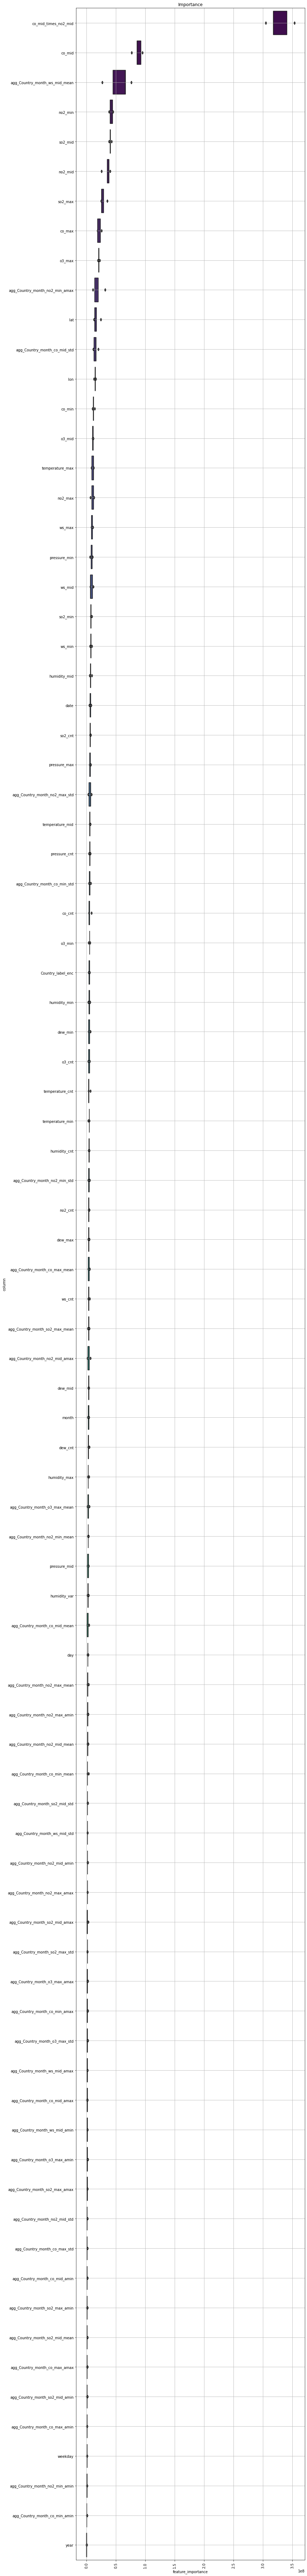

In [103]:
columns = visualize_importance(lgb_models1, df_train, 'lgb_model')

In [104]:
def predict_test(models, df):
    out = np.array([model.predict(df) for model in models])
    out = np.mean(out, axis=0)
    
    return out

In [105]:
pred_test = predict_test(lgb_models1, df_test)

In [106]:
#check distribution of train and test_pred data
def plot_prediction_distribution(y_true, y_pred, y_test):
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.histplot(y_test, label='Test Predict', ax=ax, color='black', stat='density')
    sns.histplot(y_pred, label='Out Of Fold', ax=ax, color='C1', stat='density', alpha=0.5)
    sns.histplot(y_true, label='True Value', ax=ax, color='blue', stat='density', alpha=0.5)
    ax.legend()
    ax.grid()

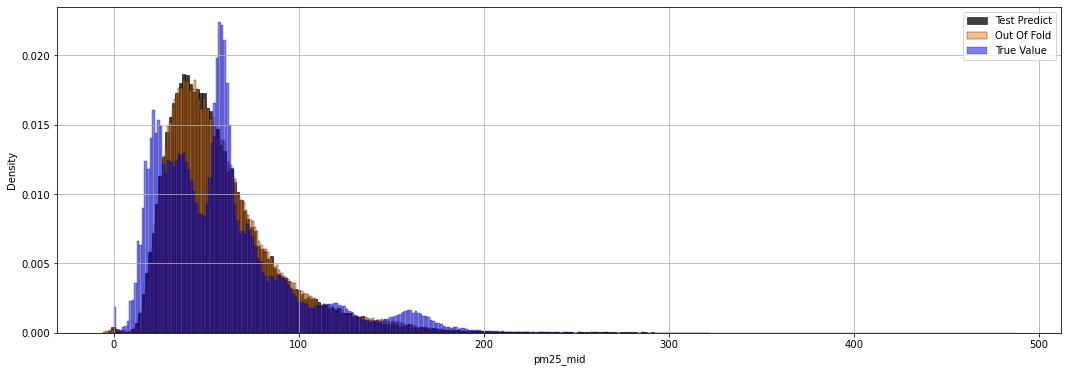

In [107]:
plot_prediction_distribution(target, oof_valid_lgb1, pred_test)

In [108]:
#提出
sample_submit=pd.read_csv("submit_sample.csv", index_col=0, header=None) # 応募用サンプルファイル
#print(sum(pred_test<0)) #49
for i in range(len(pred_test)):
    if pred_test[i]<0:
        pred_test[i]=0
#print(sum(pred_test<0)) #0
#print(sum(pred_test==0)) #49
sample_submit[1]=pred_test
#print(sample_submit)
sample_submit.to_csv("submit_sample_6.csv", header=None)

[I 2022-05-28 18:04:15,887] A new study created in memory with name: no-name-feadac88-1794-4664-875b-8dbe7e9ee56d


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 320.43	Test's l2: 613.496


[I 2022-05-28 18:04:22,832] Trial 0 finished with value: 24.47106817075871 and parameters: {'learning_rate': 0.6146571829070011, 'num_leaves': 33, 'tree_learner': 'voting', 'reg_alpha': 1.315092765119268e-08, 'reg_lambda': 0.08470310883794763, 'colsample_bytree': 0.8697429192635638, 'subsample': 0.8569183225171426, 'subsample_freq': 2, 'min_data_in_leaf': 22}. Best is trial 0 with value: 24.47106817075871.


Early stopping, best iteration is:
[34]	Train's l2: 396.172	Test's l2: 598.833
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 301.719	Test's l2: 526.672
Early stopping, best iteration is:
[69]	Train's l2: 329.411	Test's l2: 518.088


[I 2022-05-28 18:04:33,827] Trial 1 finished with value: 22.76154247199408 and parameters: {'learning_rate': 0.2820164021586252, 'num_leaves': 61, 'tree_learner': 'feature', 'reg_alpha': 0.0003349484078602141, 'reg_lambda': 0.0034958353097966064, 'colsample_bytree': 0.9474351327660121, 'subsample': 0.7163190962824937, 'subsample_freq': 4, 'min_data_in_leaf': 46}. Best is trial 1 with value: 22.76154247199408.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 182.661	Test's l2: 565.677


[I 2022-05-28 18:04:52,195] Trial 2 finished with value: 23.641020481713596 and parameters: {'learning_rate': 0.26367616460976695, 'num_leaves': 203, 'tree_learner': 'serial', 'reg_alpha': 1.5627423773282967, 'reg_lambda': 2.689191082030302e-05, 'colsample_bytree': 0.7664804710671365, 'subsample': 0.9552421332878901, 'subsample_freq': 1, 'min_data_in_leaf': 54}. Best is trial 1 with value: 22.76154247199408.


Early stopping, best iteration is:
[23]	Train's l2: 324.214	Test's l2: 558.898
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 225.273	Test's l2: 720.621


[I 2022-05-28 18:05:05,174] Trial 3 finished with value: 24.46701002264559 and parameters: {'learning_rate': 0.5397677363067878, 'num_leaves': 152, 'tree_learner': 'feature', 'reg_alpha': 1.030327012142634, 'reg_lambda': 0.6685666461738388, 'colsample_bytree': 0.7989460240135381, 'subsample': 0.4978072162698569, 'subsample_freq': 3, 'min_data_in_leaf': 63}. Best is trial 1 with value: 22.76154247199408.


Early stopping, best iteration is:
[13]	Train's l2: 390.801	Test's l2: 598.635
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 347.133	Test's l2: 800.475


[I 2022-05-28 18:05:10,433] Trial 4 finished with value: 25.163675730424238 and parameters: {'learning_rate': 0.8915610794551305, 'num_leaves': 42, 'tree_learner': 'serial', 'reg_alpha': 2.6741206981216783e-05, 'reg_lambda': 4.995132452180123e-05, 'colsample_bytree': 0.904637882537332, 'subsample': 0.6361336859545285, 'subsample_freq': 5, 'min_data_in_leaf': 37}. Best is trial 1 with value: 22.76154247199408.


Early stopping, best iteration is:
[15]	Train's l2: 453.772	Test's l2: 633.211
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 245.934	Test's l2: 635.926


[I 2022-05-28 18:05:20,004] Trial 5 finished with value: 24.361269554627068 and parameters: {'learning_rate': 0.49913532393514193, 'num_leaves': 103, 'tree_learner': 'serial', 'reg_alpha': 1.8521868724440216, 'reg_lambda': 0.051888733319789215, 'colsample_bytree': 0.6944521516588458, 'subsample': 0.6498170786474083, 'subsample_freq': 7, 'min_data_in_leaf': 83}. Best is trial 1 with value: 22.76154247199408.


Early stopping, best iteration is:
[11]	Train's l2: 413.394	Test's l2: 593.471
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 233.962	Test's l2: 523.273


[I 2022-05-28 18:05:40,465] Trial 6 finished with value: 22.82504419032534 and parameters: {'learning_rate': 0.18608963535515693, 'num_leaves': 185, 'tree_learner': 'serial', 'reg_alpha': 0.1693178829817092, 'reg_lambda': 1.5200288526545716e-08, 'colsample_bytree': 0.5012256901996825, 'subsample': 0.9551950416032131, 'subsample_freq': 4, 'min_data_in_leaf': 79}. Best is trial 1 with value: 22.76154247199408.


Early stopping, best iteration is:
[63]	Train's l2: 276.93	Test's l2: 520.983
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 215.066	Test's l2: 819.776


[I 2022-05-28 18:05:51,871] Trial 7 finished with value: 25.415413898382013 and parameters: {'learning_rate': 0.7952283075088833, 'num_leaves': 127, 'tree_learner': 'serial', 'reg_alpha': 1.8210059256731085e-08, 'reg_lambda': 6.0320526780322574e-06, 'colsample_bytree': 0.5820413791592749, 'subsample': 0.730355590229038, 'subsample_freq': 3, 'min_data_in_leaf': 34}. Best is trial 1 with value: 22.76154247199408.


Early stopping, best iteration is:
[15]	Train's l2: 393.761	Test's l2: 645.943
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 320.722	Test's l2: 735.298


[I 2022-05-28 18:05:56,881] Trial 8 finished with value: 25.06349280286107 and parameters: {'learning_rate': 0.6686323433599265, 'num_leaves': 54, 'tree_learner': 'feature', 'reg_alpha': 1.8246654628963986e-07, 'reg_lambda': 3.7187859985243624e-08, 'colsample_bytree': 0.9272814424047874, 'subsample': 0.524637814999001, 'subsample_freq': 5, 'min_data_in_leaf': 8}. Best is trial 1 with value: 22.76154247199408.


Early stopping, best iteration is:
[10]	Train's l2: 455.156	Test's l2: 628.179
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 422.609	Test's l2: 556.926
[200]	Train's l2: 387.261	Test's l2: 543.503
[300]	Train's l2: 366.154	Test's l2: 540.949
[400]	Train's l2: 350.06	Test's l2: 537.269
[500]	Train's l2: 336.857	Test's l2: 538.01
Early stopping, best iteration is:
[413]	Train's l2: 348.312	Test's l2: 535.412


[I 2022-05-28 18:06:07,434] Trial 9 finished with value: 23.138963497123207 and parameters: {'learning_rate': 0.16810387687057127, 'num_leaves': 13, 'tree_learner': 'feature', 'reg_alpha': 0.0009607184954339539, 'reg_lambda': 2.0317046306855885e-06, 'colsample_bytree': 0.9566331840660054, 'subsample': 0.926352101885234, 'subsample_freq': 1, 'min_data_in_leaf': 94}. Best is trial 1 with value: 22.76154247199408.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 163.597	Test's l2: 653.164


[I 2022-05-28 18:06:31,493] Trial 10 finished with value: 24.752537921485235 and parameters: {'learning_rate': 0.3759747668877317, 'num_leaves': 239, 'tree_learner': 'data', 'reg_alpha': 0.0012138666307037736, 'reg_lambda': 0.0017770342581070176, 'colsample_bytree': 0.40427105719484935, 'subsample': 0.7722768374021195, 'subsample_freq': 7, 'min_data_in_leaf': 64}. Best is trial 1 with value: 22.76154247199408.


Early stopping, best iteration is:
[17]	Train's l2: 343.707	Test's l2: 612.688
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 304.543	Test's l2: 521.066
Early stopping, best iteration is:
[83]	Train's l2: 319.558	Test's l2: 519.811


[I 2022-05-28 18:06:56,569] Trial 11 finished with value: 22.799371695915873 and parameters: {'learning_rate': 0.10415523884610178, 'num_leaves': 171, 'tree_learner': 'data', 'reg_alpha': 0.0441801660840446, 'reg_lambda': 1.1388561351463001e-08, 'colsample_bytree': 0.5122072061628822, 'subsample': 0.4110279121765509, 'subsample_freq': 5, 'min_data_in_leaf': 79}. Best is trial 1 with value: 22.76154247199408.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 286.878	Test's l2: 608.177


[I 2022-05-28 18:07:06,192] Trial 12 finished with value: 24.113809675729236 and parameters: {'learning_rate': 0.346525383935248, 'num_leaves': 89, 'tree_learner': 'data', 'reg_alpha': 4.443412022385718e-05, 'reg_lambda': 0.0012647181204984445, 'colsample_bytree': 0.628588328204575, 'subsample': 0.43348076458111834, 'subsample_freq': 5, 'min_data_in_leaf': 43}. Best is trial 1 with value: 22.76154247199408.


Early stopping, best iteration is:
[38]	Train's l2: 355.667	Test's l2: 581.476
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 267.065	Test's l2: 524.299


[I 2022-05-28 18:07:26,699] Trial 13 finished with value: 22.81474369316963 and parameters: {'learning_rate': 0.16029825038599732, 'num_leaves': 166, 'tree_learner': 'data', 'reg_alpha': 0.0382466915465056, 'reg_lambda': 4.0178802782720877e-07, 'colsample_bytree': 0.4952597537914612, 'subsample': 0.5708629064435781, 'subsample_freq': 6, 'min_data_in_leaf': 72}. Best is trial 1 with value: 22.76154247199408.


Early stopping, best iteration is:
[63]	Train's l2: 307.197	Test's l2: 520.513
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 350.865	Test's l2: 527.12
[200]	Train's l2: 302.143	Test's l2: 521.338
Early stopping, best iteration is:
[191]	Train's l2: 305.368	Test's l2: 519.714


[I 2022-05-28 18:07:45,164] Trial 14 finished with value: 22.797235748463116 and parameters: {'learning_rate': 0.1021533802906906, 'num_leaves': 83, 'tree_learner': 'voting', 'reg_alpha': 0.01135155736775327, 'reg_lambda': 5.0899261926201795, 'colsample_bytree': 0.6893886469778748, 'subsample': 0.41007290943247077, 'subsample_freq': 4, 'min_data_in_leaf': 95}. Best is trial 1 with value: 22.76154247199408.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 266.875	Test's l2: 589.057


[I 2022-05-28 18:07:56,584] Trial 15 finished with value: 24.114173680189662 and parameters: {'learning_rate': 0.3820145162306826, 'num_leaves': 80, 'tree_learner': 'voting', 'reg_alpha': 4.575390228457067e-06, 'reg_lambda': 4.676829235966773, 'colsample_bytree': 0.809485867897545, 'subsample': 0.8097582509039849, 'subsample_freq': 3, 'min_data_in_leaf': 93}. Best is trial 1 with value: 22.76154247199408.


Early stopping, best iteration is:
[58]	Train's l2: 312.858	Test's l2: 581.493
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 247.317	Test's l2: 541.05


[I 2022-05-28 18:08:11,657] Trial 16 finished with value: 23.189805940185565 and parameters: {'learning_rate': 0.2651967976688265, 'num_leaves': 123, 'tree_learner': 'voting', 'reg_alpha': 0.005077255381142573, 'reg_lambda': 0.016067102802885355, 'colsample_bytree': 0.7085197901567265, 'subsample': 0.6772649791637323, 'subsample_freq': 4, 'min_data_in_leaf': 49}. Best is trial 1 with value: 22.76154247199408.


Early stopping, best iteration is:
[67]	Train's l2: 283.41	Test's l2: 537.767
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 294.117	Test's l2: 544.001


[I 2022-05-28 18:08:21,621] Trial 17 finished with value: 23.12378991153323 and parameters: {'learning_rate': 0.28943214733089195, 'num_leaves': 68, 'tree_learner': 'feature', 'reg_alpha': 0.00010836734998062667, 'reg_lambda': 5.981301487825121, 'colsample_bytree': 0.9886344780482079, 'subsample': 0.5762323409780585, 'subsample_freq': 2, 'min_data_in_leaf': 26}. Best is trial 1 with value: 22.76154247199408.


Early stopping, best iteration is:
[44]	Train's l2: 355.401	Test's l2: 534.71
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 410.942	Test's l2: 541.47
[200]	Train's l2: 371.227	Test's l2: 531.937
[300]	Train's l2: 347.088	Test's l2: 549.99
Early stopping, best iteration is:
[206]	Train's l2: 369.717	Test's l2: 530.864


[I 2022-05-28 18:08:31,742] Trial 18 finished with value: 23.040481470021167 and parameters: {'learning_rate': 0.4646464204961602, 'num_leaves': 10, 'tree_learner': 'voting', 'reg_alpha': 1.2112197640744947e-06, 'reg_lambda': 0.5532539310374691, 'colsample_bytree': 0.6924748240268161, 'subsample': 0.8640251599721858, 'subsample_freq': 6, 'min_data_in_leaf': 100}. Best is trial 1 with value: 22.76154247199408.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 320.611	Test's l2: 532.945
[200]	Train's l2: 264.385	Test's l2: 531.668
Early stopping, best iteration is:
[166]	Train's l2: 280.032	Test's l2: 528.46


[I 2022-05-28 18:08:54,581] Trial 19 finished with value: 22.988255543266405 and parameters: {'learning_rate': 0.10212115694087356, 'num_leaves': 109, 'tree_learner': 'feature', 'reg_alpha': 0.006290324104091447, 'reg_lambda': 0.003326021775401012, 'colsample_bytree': 0.6233920075643751, 'subsample': 0.7189841162310311, 'subsample_freq': 4, 'min_data_in_leaf': 60}. Best is trial 1 with value: 22.76154247199408.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 308.8	Test's l2: 583.041


[I 2022-05-28 18:09:01,106] Trial 20 finished with value: 23.958907457303187 and parameters: {'learning_rate': 0.23306928506956776, 'num_leaves': 60, 'tree_learner': 'voting', 'reg_alpha': 0.0007270033373091331, 'reg_lambda': 9.225471171897485e-05, 'colsample_bytree': 0.8554517787591507, 'subsample': 0.598646951060749, 'subsample_freq': 4, 'min_data_in_leaf': 5}. Best is trial 1 with value: 22.76154247199408.


Early stopping, best iteration is:
[38]	Train's l2: 377.085	Test's l2: 574.029
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 289.783	Test's l2: 515.191
Early stopping, best iteration is:
[84]	Train's l2: 305.031	Test's l2: 512.94


[I 2022-05-28 18:09:29,568] Trial 21 finished with value: 22.648187768230507 and parameters: {'learning_rate': 0.1037799026579094, 'num_leaves': 220, 'tree_learner': 'data', 'reg_alpha': 0.057433644313740914, 'reg_lambda': 0.00032204416788658285, 'colsample_bytree': 0.5152088965787909, 'subsample': 0.40389937430418893, 'subsample_freq': 5, 'min_data_in_leaf': 83}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 240.797	Test's l2: 544.401
[200]	Train's l2: 162.964	Test's l2: 554.155
Early stopping, best iteration is:
[102]	Train's l2: 238.706	Test's l2: 543.43


[I 2022-05-28 18:10:03,751] Trial 22 finished with value: 23.31158803429554 and parameters: {'learning_rate': 0.1729067199664242, 'num_leaves': 255, 'tree_learner': 'data', 'reg_alpha': 9.235176068396271, 'reg_lambda': 0.00027778432922970437, 'colsample_bytree': 0.4156675489220638, 'subsample': 0.4742793445152815, 'subsample_freq': 6, 'min_data_in_leaf': 89}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 287.35	Test's l2: 537.557
[200]	Train's l2: 218.632	Test's l2: 541.646
Early stopping, best iteration is:
[121]	Train's l2: 269.799	Test's l2: 532.314


[I 2022-05-28 18:10:37,125] Trial 23 finished with value: 23.071924751005817 and parameters: {'learning_rate': 0.11048459116716243, 'num_leaves': 219, 'tree_learner': 'feature', 'reg_alpha': 0.008726218424380223, 'reg_lambda': 0.005248152472392337, 'colsample_bytree': 0.5595584864861569, 'subsample': 0.4049391979253806, 'subsample_freq': 4, 'min_data_in_leaf': 100}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 243.756	Test's l2: 611.099


[I 2022-05-28 18:10:48,914] Trial 24 finished with value: 23.90366761837878 and parameters: {'learning_rate': 0.3164414940778554, 'num_leaves': 145, 'tree_learner': 'data', 'reg_alpha': 0.06339303824815132, 'reg_lambda': 0.3685561938253159, 'colsample_bytree': 0.7216117115496863, 'subsample': 0.45332057965579686, 'subsample_freq': 3, 'min_data_in_leaf': 70}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[17]	Train's l2: 381.61	Test's l2: 571.385
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 281.184	Test's l2: 634.16


[I 2022-05-28 18:10:56,255] Trial 25 finished with value: 24.082391712620907 and parameters: {'learning_rate': 0.45265435559868317, 'num_leaves': 87, 'tree_learner': 'voting', 'reg_alpha': 0.2670162169886983, 'reg_lambda': 0.0004565275630996003, 'colsample_bytree': 0.6379730252909807, 'subsample': 0.5290841078499355, 'subsample_freq': 5, 'min_data_in_leaf': 84}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[13]	Train's l2: 418.466	Test's l2: 579.962
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 293.23	Test's l2: 563.756
[200]	Train's l2: 229.189	Test's l2: 572.805


[I 2022-05-28 18:11:11,161] Trial 26 finished with value: 23.658950235816228 and parameters: {'learning_rate': 0.22687578166646089, 'num_leaves': 102, 'tree_learner': 'feature', 'reg_alpha': 0.0001504854614378017, 'reg_lambda': 0.035645854641348576, 'colsample_bytree': 0.4570371235413057, 'subsample': 0.5257639969080232, 'subsample_freq': 6, 'min_data_in_leaf': 73}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[112]	Train's l2: 283.465	Test's l2: 559.746
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 338.865	Test's l2: 566.453


[I 2022-05-28 18:11:16,215] Trial 27 finished with value: 23.590435872591343 and parameters: {'learning_rate': 0.4095039620891484, 'num_leaves': 35, 'tree_learner': 'data', 'reg_alpha': 0.010988240418019593, 'reg_lambda': 5.237121733614344e-06, 'colsample_bytree': 0.5672201852667746, 'subsample': 0.7508885862129788, 'subsample_freq': 2, 'min_data_in_leaf': 50}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[27]	Train's l2: 416.317	Test's l2: 556.509
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 309.094	Test's l2: 547.799


[I 2022-05-28 18:11:24,701] Trial 28 finished with value: 23.191761644185036 and parameters: {'learning_rate': 0.21164890847459178, 'num_leaves': 72, 'tree_learner': 'voting', 'reg_alpha': 8.489688491160454e-06, 'reg_lambda': 0.0002848176281057025, 'colsample_bytree': 0.7673420531536662, 'subsample': 0.6205512169757437, 'subsample_freq': 4, 'min_data_in_leaf': 57}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[36]	Train's l2: 377.388	Test's l2: 537.858
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 161.405	Test's l2: 606.246


[I 2022-05-28 18:11:40,826] Trial 29 finished with value: 23.984051361277643 and parameters: {'learning_rate': 0.31964683303055935, 'num_leaves': 199, 'tree_learner': 'voting', 'reg_alpha': 0.0025164903319909704, 'reg_lambda': 0.22051269152355404, 'colsample_bytree': 0.8553035932417812, 'subsample': 0.8381043692689456, 'subsample_freq': 3, 'min_data_in_leaf': 14}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[15]	Train's l2: 347.482	Test's l2: 575.235
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 350.739	Test's l2: 662.574


[I 2022-05-28 18:11:45,346] Trial 30 finished with value: 25.103593331336068 and parameters: {'learning_rate': 0.6152740404525673, 'num_leaves': 28, 'tree_learner': 'feature', 'reg_alpha': 0.00028970290369136834, 'reg_lambda': 0.010357925075981494, 'colsample_bytree': 0.6716364879561838, 'subsample': 0.671392164993122, 'subsample_freq': 5, 'min_data_in_leaf': 24}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[21]	Train's l2: 444.901	Test's l2: 630.19
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 303.079	Test's l2: 517.225
Early stopping, best iteration is:
[95]	Train's l2: 307.184	Test's l2: 516.459


[I 2022-05-28 18:12:11,540] Trial 31 finished with value: 22.725740549937615 and parameters: {'learning_rate': 0.10602313517017375, 'num_leaves': 174, 'tree_learner': 'data', 'reg_alpha': 0.03135603898706336, 'reg_lambda': 1.8969431160335358e-07, 'colsample_bytree': 0.519937440333903, 'subsample': 0.41870835021576575, 'subsample_freq': 5, 'min_data_in_leaf': 87}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 260.465	Test's l2: 523.242
[200]	Train's l2: 187.122	Test's l2: 527.372
Early stopping, best iteration is:
[110]	Train's l2: 250.827	Test's l2: 519.718


[I 2022-05-28 18:12:44,249] Trial 32 finished with value: 22.797320032679966 and parameters: {'learning_rate': 0.14161788477634574, 'num_leaves': 223, 'tree_learner': 'data', 'reg_alpha': 0.025989623710727116, 'reg_lambda': 1.558469016406727e-05, 'colsample_bytree': 0.5410677416570785, 'subsample': 0.4725524693950338, 'subsample_freq': 5, 'min_data_in_leaf': 89}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 237.774	Test's l2: 575.614


[I 2022-05-28 18:13:02,206] Trial 33 finished with value: 23.754855769272126 and parameters: {'learning_rate': 0.24615993228330757, 'num_leaves': 207, 'tree_learner': 'data', 'reg_alpha': 0.29676656378642113, 'reg_lambda': 1.6377978116764616e-07, 'colsample_bytree': 0.4667394897516201, 'subsample': 0.4522609156402395, 'subsample_freq': 6, 'min_data_in_leaf': 94}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[36]	Train's l2: 331.82	Test's l2: 564.293
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 277.842	Test's l2: 550.449


[I 2022-05-28 18:13:15,988] Trial 34 finished with value: 23.24264969269432 and parameters: {'learning_rate': 0.18833563977443157, 'num_leaves': 146, 'tree_learner': 'data', 'reg_alpha': 1.7174205894420198, 'reg_lambda': 1.1850475565755866e-06, 'colsample_bytree': 0.5866169770250105, 'subsample': 0.4046040306009825, 'subsample_freq': 5, 'min_data_in_leaf': 68}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[31]	Train's l2: 367.23	Test's l2: 540.221
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 273.46	Test's l2: 523.938
Early stopping, best iteration is:
[85]	Train's l2: 288.573	Test's l2: 518.785


[I 2022-05-28 18:13:39,154] Trial 35 finished with value: 22.77685023270682 and parameters: {'learning_rate': 0.12666888093582973, 'num_leaves': 186, 'tree_learner': 'data', 'reg_alpha': 0.4822248137755263, 'reg_lambda': 7.841891490043229e-05, 'colsample_bytree': 0.7466292325981722, 'subsample': 0.49820500333394097, 'subsample_freq': 4, 'min_data_in_leaf': 78}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 343.068	Test's l2: 1391.39


[I 2022-05-28 18:13:51,878] Trial 36 finished with value: 25.63965499380459 and parameters: {'learning_rate': 0.920875412550781, 'num_leaves': 188, 'tree_learner': 'data', 'reg_alpha': 0.5719291079619951, 'reg_lambda': 0.00011187374644187396, 'colsample_bytree': 0.7850358419395049, 'subsample': 0.4884141169540398, 'subsample_freq': 3, 'min_data_in_leaf': 80}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[3]	Train's l2: 503.842	Test's l2: 657.392
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 218.383	Test's l2: 929.842


[I 2022-05-28 18:14:04,151] Trial 37 finished with value: 25.71354021814835 and parameters: {'learning_rate': 0.7223888676911584, 'num_leaves': 169, 'tree_learner': 'data', 'reg_alpha': 0.13415530017845648, 'reg_lambda': 2.6153004805289408e-05, 'colsample_bytree': 0.7389509923690232, 'subsample': 0.5548220493516907, 'subsample_freq': 5, 'min_data_in_leaf': 41}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[5]	Train's l2: 447.566	Test's l2: 661.186
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 204.957	Test's l2: 758.854


[I 2022-05-28 18:14:17,264] Trial 38 finished with value: 25.086334320530607 and parameters: {'learning_rate': 0.5539273397530945, 'num_leaves': 187, 'tree_learner': 'serial', 'reg_alpha': 7.775606120879015, 'reg_lambda': 0.0007981182015482902, 'colsample_bytree': 0.8967062207286374, 'subsample': 0.506301580575166, 'subsample_freq': 4, 'min_data_in_leaf': 85}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[5]	Train's l2: 442.602	Test's l2: 629.324
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 250.417	Test's l2: 533.447


[I 2022-05-28 18:14:38,575] Trial 39 finished with value: 22.958089095412653 and parameters: {'learning_rate': 0.14485127222528577, 'num_leaves': 230, 'tree_learner': 'data', 'reg_alpha': 0.6309257245340036, 'reg_lambda': 5.392037635048997e-08, 'colsample_bytree': 0.8179179740781183, 'subsample': 0.438043653384066, 'subsample_freq': 7, 'min_data_in_leaf': 75}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[47]	Train's l2: 319.878	Test's l2: 527.074
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 176.339	Test's l2: 585.483


[I 2022-05-28 18:14:56,377] Trial 40 finished with value: 23.468668935535067 and parameters: {'learning_rate': 0.28857745672512003, 'num_leaves': 252, 'tree_learner': 'data', 'reg_alpha': 0.0958834240953189, 'reg_lambda': 1.0487302982529844e-05, 'colsample_bytree': 0.5275920703365052, 'subsample': 0.6254984165612791, 'subsample_freq': 5, 'min_data_in_leaf': 54}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[14]	Train's l2: 364.709	Test's l2: 550.778
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 367.352	Test's l2: 555.991
[200]	Train's l2: 326.419	Test's l2: 549.996
Early stopping, best iteration is:
[182]	Train's l2: 332.137	Test's l2: 548.833


[I 2022-05-28 18:15:08,836] Trial 41 finished with value: 23.427177600627644 and parameters: {'learning_rate': 0.13268391333341473, 'num_leaves': 51, 'tree_learner': 'serial', 'reg_alpha': 0.01619428369556998, 'reg_lambda': 1.6688734988382024, 'colsample_bytree': 0.44766726622366126, 'subsample': 0.42841494462532803, 'subsample_freq': 4, 'min_data_in_leaf': 90}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 235.2	Test's l2: 554.995


[I 2022-05-28 18:15:25,389] Trial 42 finished with value: 23.147436926312423 and parameters: {'learning_rate': 0.20260491524290372, 'num_leaves': 206, 'tree_learner': 'feature', 'reg_alpha': 0.002136587192346043, 'reg_lambda': 5.573320012233778e-05, 'colsample_bytree': 0.661138709958763, 'subsample': 0.46127418330513503, 'subsample_freq': 4, 'min_data_in_leaf': 77}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[22]	Train's l2: 366.92	Test's l2: 535.804
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 290.179	Test's l2: 531.895
Early stopping, best iteration is:
[92]	Train's l2: 297.058	Test's l2: 529.454


[I 2022-05-28 18:15:45,662] Trial 43 finished with value: 23.00985795433132 and parameters: {'learning_rate': 0.15437019431542032, 'num_leaves': 136, 'tree_learner': 'data', 'reg_alpha': 3.176095533538751, 'reg_lambda': 1.777310865499698e-06, 'colsample_bytree': 0.6040874338060125, 'subsample': 0.5012138562628915, 'subsample_freq': 3, 'min_data_in_leaf': 96}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 243.987	Test's l2: 559.264


[I 2022-05-28 18:16:04,416] Trial 44 finished with value: 23.415425316410158 and parameters: {'learning_rate': 0.20306895001380804, 'num_leaves': 178, 'tree_learner': 'voting', 'reg_alpha': 0.028058023800867953, 'reg_lambda': 0.0736070589051085, 'colsample_bytree': 0.9235092054538592, 'subsample': 0.42664544501063756, 'subsample_freq': 4, 'min_data_in_leaf': 64}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[44]	Train's l2: 317.186	Test's l2: 548.282
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 305.967	Test's l2: 524.129
[200]	Train's l2: 242.425	Test's l2: 521.275
Early stopping, best iteration is:
[124]	Train's l2: 287.525	Test's l2: 517.908


[I 2022-05-28 18:16:26,422] Trial 45 finished with value: 22.75758206554932 and parameters: {'learning_rate': 0.10555053466240834, 'num_leaves': 157, 'tree_learner': 'data', 'reg_alpha': 0.0031919806180150233, 'reg_lambda': 0.02176315101622497, 'colsample_bytree': 0.8422366426140326, 'subsample': 0.4046178958931216, 'subsample_freq': 4, 'min_data_in_leaf': 86}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 143.683	Test's l2: 895.616


[I 2022-05-28 18:16:37,055] Trial 46 finished with value: 25.575177932279548 and parameters: {'learning_rate': 0.975653513015167, 'num_leaves': 160, 'tree_learner': 'data', 'reg_alpha': 0.0003263245062203508, 'reg_lambda': 0.013055501416296857, 'colsample_bytree': 0.9594621036780403, 'subsample': 0.998971005971655, 'subsample_freq': 5, 'min_data_in_leaf': 83}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[4]	Train's l2: 455.667	Test's l2: 654.09
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 221.58	Test's l2: 571.584


[I 2022-05-28 18:16:50,263] Trial 47 finished with value: 23.61488310735376 and parameters: {'learning_rate': 0.2637140731359125, 'num_leaves': 156, 'tree_learner': 'data', 'reg_alpha': 0.0037929924798694777, 'reg_lambda': 0.0023876482669641743, 'colsample_bytree': 0.8911809532636479, 'subsample': 0.7793272723690404, 'subsample_freq': 6, 'min_data_in_leaf': 87}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[28]	Train's l2: 334.686	Test's l2: 557.663
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 230.789	Test's l2: 542.784


[I 2022-05-28 18:17:11,961] Trial 48 finished with value: 23.266169402398514 and parameters: {'learning_rate': 0.17437569205102213, 'num_leaves': 201, 'tree_learner': 'data', 'reg_alpha': 0.0006882276168442896, 'reg_lambda': 0.0313647628585541, 'colsample_bytree': 0.835639882322717, 'subsample': 0.5447368559513228, 'subsample_freq': 5, 'min_data_in_leaf': 45}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[82]	Train's l2: 250.014	Test's l2: 541.315
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 277.819	Test's l2: 524.972
[200]	Train's l2: 212.115	Test's l2: 526.261


[I 2022-05-28 18:17:36,530] Trial 49 finished with value: 22.8679708774118 and parameters: {'learning_rate': 0.10053136650049442, 'num_leaves': 177, 'tree_learner': 'data', 'reg_alpha': 0.07318888274997469, 'reg_lambda': 0.18157557618409828, 'colsample_bytree': 0.7502758806902888, 'subsample': 0.6869087463034647, 'subsample_freq': 3, 'min_data_in_leaf': 37}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[115]	Train's l2: 265.263	Test's l2: 522.944
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 347.458	Test's l2: 1081.24


[I 2022-05-28 18:17:45,240] Trial 50 finished with value: 24.859310935537955 and parameters: {'learning_rate': 0.811336425490688, 'num_leaves': 119, 'tree_learner': 'serial', 'reg_alpha': 3.1649802038386885e-05, 'reg_lambda': 0.0010018095839529082, 'colsample_bytree': 0.9958719679792944, 'subsample': 0.4378047975464122, 'subsample_freq': 4, 'min_data_in_leaf': 79}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[3]	Train's l2: 504.262	Test's l2: 617.985
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 301.467	Test's l2: 526.683
[200]	Train's l2: 240.31	Test's l2: 531.087


[I 2022-05-28 18:18:03,702] Trial 51 finished with value: 22.867039361554937 and parameters: {'learning_rate': 0.13598373219541696, 'num_leaves': 135, 'tree_learner': 'feature', 'reg_alpha': 0.001849622591216771, 'reg_lambda': 1.9025190724840841, 'colsample_bytree': 0.7859923926845372, 'subsample': 0.4125601563499253, 'subsample_freq': 4, 'min_data_in_leaf': 96}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[120]	Train's l2: 286.849	Test's l2: 522.901
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 322.818	Test's l2: 526.801
[200]	Train's l2: 266.102	Test's l2: 523.367


[I 2022-05-28 18:18:22,011] Trial 52 finished with value: 22.82967046002318 and parameters: {'learning_rate': 0.12744168025432775, 'num_leaves': 96, 'tree_learner': 'data', 'reg_alpha': 0.22340990620252069, 'reg_lambda': 0.00016454102100756023, 'colsample_bytree': 0.4873929982110509, 'subsample': 0.48633842834148855, 'subsample_freq': 3, 'min_data_in_leaf': 31}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[161]	Train's l2: 284.663	Test's l2: 521.194
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 254.45	Test's l2: 534.096


[I 2022-05-28 18:18:39,628] Trial 53 finished with value: 22.937884731141903 and parameters: {'learning_rate': 0.1686279818580515, 'num_leaves': 190, 'tree_learner': 'voting', 'reg_alpha': 0.021168969731845722, 'reg_lambda': 0.004953610990018532, 'colsample_bytree': 0.8733567332155782, 'subsample': 0.4547112596491441, 'subsample_freq': 4, 'min_data_in_leaf': 92}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[53]	Train's l2: 311.601	Test's l2: 526.147
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 414.532	Test's l2: 563.026
[200]	Train's l2: 378.99	Test's l2: 552.237
[300]	Train's l2: 357.154	Test's l2: 543.503
[400]	Train's l2: 340.097	Test's l2: 541.18
[500]	Train's l2: 325.794	Test's l2: 543.462
Early stopping, best iteration is:
[408]	Train's l2: 339.07	Test's l2: 539.728


[I 2022-05-28 18:18:52,120] Trial 54 finished with value: 23.232048382805992 and parameters: {'learning_rate': 0.10404410384950036, 'num_leaves': 23, 'tree_learner': 'data', 'reg_alpha': 0.006806993508452435, 'reg_lambda': 6.857880814257554e-07, 'colsample_bytree': 0.9646963078511216, 'subsample': 0.4028859075100279, 'subsample_freq': 4, 'min_data_in_leaf': 82}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 333.366	Test's l2: 522.607


[I 2022-05-28 18:18:59,485] Trial 55 finished with value: 22.73842972118013 and parameters: {'learning_rate': 0.2216899389912042, 'num_leaves': 48, 'tree_learner': 'feature', 'reg_alpha': 0.9720362247152554, 'reg_lambda': 0.0007445756928945555, 'colsample_bytree': 0.9326106700706732, 'subsample': 0.7052970151937311, 'subsample_freq': 5, 'min_data_in_leaf': 68}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[81]	Train's l2: 346.982	Test's l2: 517.036
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 192.257	Test's l2: 581.03


[I 2022-05-28 18:19:15,804] Trial 56 finished with value: 23.677784874261278 and parameters: {'learning_rate': 0.24249046166757202, 'num_leaves': 215, 'tree_learner': 'feature', 'reg_alpha': 0.8251558568532533, 'reg_lambda': 0.0004851828654582516, 'colsample_bytree': 0.9148277862544213, 'subsample': 0.729887779711462, 'subsample_freq': 5, 'min_data_in_leaf': 68}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[24]	Train's l2: 328.897	Test's l2: 560.637
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 347.176	Test's l2: 550.692


[I 2022-05-28 18:19:23,549] Trial 57 finished with value: 23.376359720074817 and parameters: {'learning_rate': 0.2017963574394144, 'num_leaves': 42, 'tree_learner': 'feature', 'reg_alpha': 2.9248894359984874, 'reg_lambda': 0.0015407947813300838, 'colsample_bytree': 0.9404707394828595, 'subsample': 0.7075960239343029, 'subsample_freq': 5, 'min_data_in_leaf': 75}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[82]	Train's l2: 359.337	Test's l2: 546.454
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 157.174	Test's l2: 614.025


[I 2022-05-28 18:19:39,971] Trial 58 finished with value: 23.829518138888144 and parameters: {'learning_rate': 0.3662045868975621, 'num_leaves': 234, 'tree_learner': 'feature', 'reg_alpha': 7.791210367223647e-05, 'reg_lambda': 0.006560132571323042, 'colsample_bytree': 0.9760450543413194, 'subsample': 0.6456103634611614, 'subsample_freq': 6, 'min_data_in_leaf': 58}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[16]	Train's l2: 339.1	Test's l2: 567.846
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 209.305	Test's l2: 592.007


[I 2022-05-28 18:19:52,018] Trial 59 finished with value: 23.78471896508932 and parameters: {'learning_rate': 0.29509900339235406, 'num_leaves': 165, 'tree_learner': 'feature', 'reg_alpha': 4.9455606316633723e-08, 'reg_lambda': 3.4112070988450375e-06, 'colsample_bytree': 0.8372730020566465, 'subsample': 0.6642446054950902, 'subsample_freq': 1, 'min_data_in_leaf': 63}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[22]	Train's l2: 346.322	Test's l2: 565.713
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 251.977	Test's l2: 541.378


[I 2022-05-28 18:20:07,392] Trial 60 finished with value: 23.128262142028237 and parameters: {'learning_rate': 0.17601658471146295, 'num_leaves': 147, 'tree_learner': 'feature', 'reg_alpha': 0.327262159799846, 'reg_lambda': 4.6864626113306076e-05, 'colsample_bytree': 0.8716159753209279, 'subsample': 0.8831653491775971, 'subsample_freq': 5, 'min_data_in_leaf': 71}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[50]	Train's l2: 312.249	Test's l2: 534.917
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 337.172	Test's l2: 526.849
[200]	Train's l2: 287.62	Test's l2: 523.049
[300]	Train's l2: 253.114	Test's l2: 517.127
[400]	Train's l2: 225.786	Test's l2: 520.045
Early stopping, best iteration is:
[342]	Train's l2: 240.89	Test's l2: 516.213


[I 2022-05-28 18:20:30,013] Trial 61 finished with value: 22.720329178425064 and parameters: {'learning_rate': 0.145467268226666, 'num_leaves': 68, 'tree_learner': 'voting', 'reg_alpha': 0.05045310997192259, 'reg_lambda': 0.00019479556712252087, 'colsample_bytree': 0.5163375801184564, 'subsample': 0.7676835666966562, 'subsample_freq': 4, 'min_data_in_leaf': 86}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 328.452	Test's l2: 527.558
[200]	Train's l2: 274.981	Test's l2: 525.236


[I 2022-05-28 18:20:41,561] Trial 62 finished with value: 22.898222859103843 and parameters: {'learning_rate': 0.22581895788610942, 'num_leaves': 56, 'tree_learner': 'data', 'reg_alpha': 0.05255650097383958, 'reg_lambda': 0.0002058479833837187, 'colsample_bytree': 0.5158775406470433, 'subsample': 0.802044283891866, 'subsample_freq': 4, 'min_data_in_leaf': 86}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[164]	Train's l2: 291.66	Test's l2: 524.329
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 491.393	Test's l2: 573.983
[200]	Train's l2: 455.053	Test's l2: 567.656
[300]	Train's l2: 434.446	Test's l2: 560.576
[400]	Train's l2: 420.484	Test's l2: 556.526
[500]	Train's l2: 409.69	Test's l2: 555.556
[600]	Train's l2: 401.018	Test's l2: 547.26


[I 2022-05-28 18:20:49,957] Trial 63 finished with value: 23.369551683927 and parameters: {'learning_rate': 0.15345326175152804, 'num_leaves': 5, 'tree_learner': 'voting', 'reg_alpha': 0.1400926042015853, 'reg_lambda': 0.002952819931996852, 'colsample_bytree': 0.9380326424794014, 'subsample': 0.745511525593537, 'subsample_freq': 4, 'min_data_in_leaf': 82}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[566]	Train's l2: 403.719	Test's l2: 546.136
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 341.942	Test's l2: 531.458
[200]	Train's l2: 293.829	Test's l2: 530.313


[I 2022-05-28 18:21:02,293] Trial 64 finished with value: 23.000382778398066 and parameters: {'learning_rate': 0.12750189978547363, 'num_leaves': 70, 'tree_learner': 'data', 'reg_alpha': 0.4758188385097091, 'reg_lambda': 0.0008069234281099299, 'colsample_bytree': 0.4264281653524446, 'subsample': 0.7649334447295217, 'subsample_freq': 5, 'min_data_in_leaf': 77}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[125]	Train's l2: 327.149	Test's l2: 529.018
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 336.207	Test's l2: 552.847


[I 2022-05-28 18:21:08,458] Trial 65 finished with value: 23.46292322370812 and parameters: {'learning_rate': 0.2558666774015035, 'num_leaves': 47, 'tree_learner': 'feature', 'reg_alpha': 1.3143406508405129, 'reg_lambda': 0.0004596490747416835, 'colsample_bytree': 0.4736765137004506, 'subsample': 0.693364670755085, 'subsample_freq': 4, 'min_data_in_leaf': 88}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[60]	Train's l2: 368.566	Test's l2: 550.509
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 251.588	Test's l2: 533.62


[I 2022-05-28 18:21:34,933] Trial 66 finished with value: 23.02399233415824 and parameters: {'learning_rate': 0.1853529520279399, 'num_leaves': 176, 'tree_learner': 'serial', 'reg_alpha': 0.042282002736224567, 'reg_lambda': 8.577013948689397e-05, 'colsample_bytree': 0.5432626228030302, 'subsample': 0.6043955201698475, 'subsample_freq': 5, 'min_data_in_leaf': 91}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[72]	Train's l2: 281.825	Test's l2: 530.104
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 344.194	Test's l2: 539.342
[200]	Train's l2: 295.718	Test's l2: 534.632
[300]	Train's l2: 262.275	Test's l2: 534.35
[400]	Train's l2: 236.799	Test's l2: 533.902
[500]	Train's l2: 214.38	Test's l2: 535.834
Early stopping, best iteration is:
[456]	Train's l2: 223.718	Test's l2: 533.268


[I 2022-05-28 18:22:05,051] Trial 67 finished with value: 23.09260665979545 and parameters: {'learning_rate': 0.12425558631903073, 'num_leaves': 66, 'tree_learner': 'data', 'reg_alpha': 0.0003212217111603343, 'reg_lambda': 0.01910201925750096, 'colsample_bytree': 0.49492133205094074, 'subsample': 0.7310582972713983, 'subsample_freq': 6, 'min_data_in_leaf': 47}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 393.651	Test's l2: 569.071


[I 2022-05-28 18:22:10,231] Trial 68 finished with value: 23.83636798267208 and parameters: {'learning_rate': 0.3245538654819428, 'num_leaves': 16, 'tree_learner': 'voting', 'reg_alpha': 0.014255457649129583, 'reg_lambda': 2.3447064599091927e-07, 'colsample_bytree': 0.5729488238812003, 'subsample': 0.7874374068561241, 'subsample_freq': 4, 'min_data_in_leaf': 98}. Best is trial 21 with value: 22.648187768230507.


[200]	Train's l2: 356.311	Test's l2: 587.49
Early stopping, best iteration is:
[107]	Train's l2: 389.825	Test's l2: 568.172
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 298.419	Test's l2: 533.9


[I 2022-05-28 18:22:23,657] Trial 69 finished with value: 23.057943418694148 and parameters: {'learning_rate': 0.22238544759944112, 'num_leaves': 80, 'tree_learner': 'feature', 'reg_alpha': 3.3393621270054896, 'reg_lambda': 1.0642057641115587e-05, 'colsample_bytree': 0.6027859167473231, 'subsample': 0.8149025822555853, 'subsample_freq': 3, 'min_data_in_leaf': 85}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[87]	Train's l2: 309.325	Test's l2: 531.669
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 256.968	Test's l2: 570.015


[I 2022-05-28 18:22:37,065] Trial 70 finished with value: 23.650987970423717 and parameters: {'learning_rate': 0.28062475868146747, 'num_leaves': 113, 'tree_learner': 'data', 'reg_alpha': 0.004214708021412054, 'reg_lambda': 4.8252926578291216e-08, 'colsample_bytree': 0.5479565320439839, 'subsample': 0.71385408268434, 'subsample_freq': 5, 'min_data_in_leaf': 79}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[34]	Train's l2: 344.55	Test's l2: 559.369
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 394.751	Test's l2: 550.812
[200]	Train's l2: 355.693	Test's l2: 540.618
[300]	Train's l2: 331.533	Test's l2: 537.495
Early stopping, best iteration is:
[283]	Train's l2: 334.998	Test's l2: 535.794


[I 2022-05-28 18:22:50,618] Trial 71 finished with value: 23.147223194266576 and parameters: {'learning_rate': 0.10212481303022183, 'num_leaves': 36, 'tree_learner': 'voting', 'reg_alpha': 0.01388903286777192, 'reg_lambda': 2.217248386347472e-08, 'colsample_bytree': 0.7067018174988395, 'subsample': 0.4209952291387241, 'subsample_freq': 4, 'min_data_in_leaf': 94}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 342.911	Test's l2: 543.748
[200]	Train's l2: 293.602	Test's l2: 539.07


[I 2022-05-28 18:23:03,694] Trial 72 finished with value: 23.150996636320066 and parameters: {'learning_rate': 0.17056740258363806, 'num_leaves': 62, 'tree_learner': 'voting', 'reg_alpha': 0.10244121041103639, 'reg_lambda': 9.882496197230802, 'colsample_bytree': 0.6656034023425684, 'subsample': 0.4430974672015665, 'subsample_freq': 4, 'min_data_in_leaf': 82}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[151]	Train's l2: 314.745	Test's l2: 535.969
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 336.108	Test's l2: 527.981


[I 2022-05-28 18:23:13,364] Trial 73 finished with value: 22.954873828905107 and parameters: {'learning_rate': 0.13781625189350977, 'num_leaves': 79, 'tree_learner': 'voting', 'reg_alpha': 0.0012832214204226843, 'reg_lambda': 3.146639702319457e-05, 'colsample_bytree': 0.5241556884912755, 'subsample': 0.4719951004884252, 'subsample_freq': 3, 'min_data_in_leaf': 88}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[61]	Train's l2: 368.187	Test's l2: 526.926
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 250.006	Test's l2: 527.877
Early stopping, best iteration is:
[97]	Train's l2: 252.992	Test's l2: 527.226


[I 2022-05-28 18:23:38,922] Trial 74 finished with value: 22.961412599986055 and parameters: {'learning_rate': 0.15706543361410458, 'num_leaves': 193, 'tree_learner': 'voting', 'reg_alpha': 0.007703188416941527, 'reg_lambda': 0.9284803241449691, 'colsample_bytree': 0.4343501854271031, 'subsample': 0.7544093918126397, 'subsample_freq': 4, 'min_data_in_leaf': 66}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 310.86	Test's l2: 547.969


[I 2022-05-28 18:23:51,507] Trial 75 finished with value: 23.22696853573244 and parameters: {'learning_rate': 0.195481189722558, 'num_leaves': 86, 'tree_learner': 'voting', 'reg_alpha': 0.0335930735093778, 'reg_lambda': 0.1707292200547754, 'colsample_bytree': 0.799513233656754, 'subsample': 0.41956260909489956, 'subsample_freq': 5, 'min_data_in_leaf': 73}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[68]	Train's l2: 337.82	Test's l2: 539.492
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 175.823	Test's l2: 627.714


[I 2022-05-28 18:24:09,064] Trial 76 finished with value: 23.70915962410508 and parameters: {'learning_rate': 0.4087378742230403, 'num_leaves': 244, 'tree_learner': 'data', 'reg_alpha': 0.0005840335991817858, 'reg_lambda': 0.00015282742535283088, 'colsample_bytree': 0.7355995597482435, 'subsample': 0.5186984681367539, 'subsample_freq': 4, 'min_data_in_leaf': 91}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[11]	Train's l2: 382.55	Test's l2: 562.124
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 329.699	Test's l2: 533.549
[200]	Train's l2: 275.267	Test's l2: 535.613


[I 2022-05-28 18:24:25,564] Trial 77 finished with value: 22.962567513167894 and parameters: {'learning_rate': 0.12266004995140992, 'num_leaves': 96, 'tree_learner': 'data', 'reg_alpha': 0.2551183592149075, 'reg_lambda': 0.001725937733556562, 'colsample_bytree': 0.9038700496554956, 'subsample': 0.4022944764431977, 'subsample_freq': 4, 'min_data_in_leaf': 96}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[124]	Train's l2: 314.165	Test's l2: 527.28
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 328.501	Test's l2: 533.928
[200]	Train's l2: 275.443	Test's l2: 538.096


[I 2022-05-28 18:24:37,326] Trial 78 finished with value: 23.08480849753316 and parameters: {'learning_rate': 0.1541343502975631, 'num_leaves': 74, 'tree_learner': 'feature', 'reg_alpha': 0.07172346974221466, 'reg_lambda': 0.0005271896888928943, 'colsample_bytree': 0.6918753270046886, 'subsample': 0.4686670123558616, 'subsample_freq': 6, 'min_data_in_leaf': 52}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[122]	Train's l2: 314.331	Test's l2: 532.908
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 317.918	Test's l2: 665.614


[I 2022-05-28 18:24:42,927] Trial 79 finished with value: 24.569868282074115 and parameters: {'learning_rate': 0.5071404302882323, 'num_leaves': 59, 'tree_learner': 'serial', 'reg_alpha': 0.9652123286275167, 'reg_lambda': 0.0002689663237978971, 'colsample_bytree': 0.8214094996352489, 'subsample': 0.44598063671988697, 'subsample_freq': 5, 'min_data_in_leaf': 40}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[30]	Train's l2: 388.291	Test's l2: 603.678
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 245.715	Test's l2: 571.255


[I 2022-05-28 18:25:02,722] Trial 80 finished with value: 23.58370395829283 and parameters: {'learning_rate': 0.20742995822664445, 'num_leaves': 212, 'tree_learner': 'data', 'reg_alpha': 0.4202624204340386, 'reg_lambda': 0.006254275004734707, 'colsample_bytree': 0.40233657079316837, 'subsample': 0.42471379474451043, 'subsample_freq': 2, 'min_data_in_leaf': 76}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[35]	Train's l2: 339.11	Test's l2: 556.191
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 275.631	Test's l2: 525.13


[I 2022-05-28 18:25:28,054] Trial 81 finished with value: 22.84770722565512 and parameters: {'learning_rate': 0.11570784727574614, 'num_leaves': 219, 'tree_learner': 'data', 'reg_alpha': 0.021292377467252866, 'reg_lambda': 7.685678050573406e-05, 'colsample_bytree': 0.5389220727300027, 'subsample': 0.48694760250281566, 'subsample_freq': 5, 'min_data_in_leaf': 89}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[61]	Train's l2: 319.338	Test's l2: 522.018
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 265.239	Test's l2: 527.839


[I 2022-05-28 18:25:49,369] Trial 82 finished with value: 22.839073945247062 and parameters: {'learning_rate': 0.15197110827659915, 'num_leaves': 223, 'tree_learner': 'data', 'reg_alpha': 0.003360298876679246, 'reg_lambda': 1.680656774562072e-05, 'colsample_bytree': 0.477878985312446, 'subsample': 0.42949245201600994, 'subsample_freq': 5, 'min_data_in_leaf': 100}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[53]	Train's l2: 322.453	Test's l2: 521.623
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 298.825	Test's l2: 527.825
Early stopping, best iteration is:
[85]	Train's l2: 312.067	Test's l2: 525.564


[I 2022-05-28 18:26:11,880] Trial 83 finished with value: 22.92517893275619 and parameters: {'learning_rate': 0.10242692065118883, 'num_leaves': 183, 'tree_learner': 'data', 'reg_alpha': 0.16981299827629315, 'reg_lambda': 0.0009539041297329217, 'colsample_bytree': 0.5029709785383876, 'subsample': 0.4645212330797054, 'subsample_freq': 4, 'min_data_in_leaf': 86}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 262.261	Test's l2: 538.357
Early stopping, best iteration is:
[99]	Train's l2: 263.121	Test's l2: 537.65


[I 2022-05-28 18:26:36,061] Trial 84 finished with value: 23.187282075167452 and parameters: {'learning_rate': 0.14063250424877116, 'num_leaves': 197, 'tree_learner': 'data', 'reg_alpha': 0.02884935934182315, 'reg_lambda': 8.931937676528529e-08, 'colsample_bytree': 0.6495725211216687, 'subsample': 0.5098627211913056, 'subsample_freq': 5, 'min_data_in_leaf': 81}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 221.983	Test's l2: 530.38
[200]	Train's l2: 145.491	Test's l2: 541.539
Early stopping, best iteration is:
[102]	Train's l2: 219.563	Test's l2: 529.248


[I 2022-05-28 18:27:05,432] Trial 85 finished with value: 23.005400254498053 and parameters: {'learning_rate': 0.1859091990576341, 'num_leaves': 228, 'tree_learner': 'data', 'reg_alpha': 1.098161528013419e-05, 'reg_lambda': 3.352268714188254e-05, 'colsample_bytree': 0.5950444187876389, 'subsample': 0.656241837184902, 'subsample_freq': 4, 'min_data_in_leaf': 93}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 257.184	Test's l2: 559.373


[I 2022-05-28 18:27:21,207] Trial 86 finished with value: 23.4132680374639 and parameters: {'learning_rate': 0.22534593068008613, 'num_leaves': 152, 'tree_learner': 'voting', 'reg_alpha': 0.01166937418947891, 'reg_lambda': 0.0001139873420231331, 'colsample_bytree': 0.7658431733162725, 'subsample': 0.4470460285529014, 'subsample_freq': 5, 'min_data_in_leaf': 84}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[62]	Train's l2: 299.134	Test's l2: 548.181
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 375.586	Test's l2: 550.278


[I 2022-05-28 18:27:27,886] Trial 87 finished with value: 23.401916030828556 and parameters: {'learning_rate': 0.13644895963516318, 'num_leaves': 43, 'tree_learner': 'data', 'reg_alpha': 1.2739020785433165e-06, 'reg_lambda': 1.819043395148645e-05, 'colsample_bytree': 0.45295627370738106, 'subsample': 0.4150797077552558, 'subsample_freq': 4, 'min_data_in_leaf': 89}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[88]	Train's l2: 382.244	Test's l2: 547.65
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 217.615	Test's l2: 528.266


[I 2022-05-28 18:27:50,202] Trial 88 finished with value: 22.910804480478966 and parameters: {'learning_rate': 0.1689784719255339, 'num_leaves': 240, 'tree_learner': 'feature', 'reg_alpha': 0.0013383487683583494, 'reg_lambda': 4.600322409423956e-06, 'colsample_bytree': 0.8877062635738171, 'subsample': 0.6839263776154492, 'subsample_freq': 6, 'min_data_in_leaf': 96}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[38]	Train's l2: 311.124	Test's l2: 524.905
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 251.08	Test's l2: 831.04


[I 2022-05-28 18:28:02,442] Trial 89 finished with value: 24.847782284297686 and parameters: {'learning_rate': 0.6008855910251643, 'num_leaves': 129, 'tree_learner': 'data', 'reg_alpha': 0.0062007986339998565, 'reg_lambda': 0.00035271163812729966, 'colsample_bytree': 0.948406555092621, 'subsample': 0.4779182368735593, 'subsample_freq': 3, 'min_data_in_leaf': 60}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[5]	Train's l2: 454.664	Test's l2: 617.412
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 258.106	Test's l2: 542.805


[I 2022-05-28 18:28:17,573] Trial 90 finished with value: 23.116044513258142 and parameters: {'learning_rate': 0.23969212033802467, 'num_leaves': 138, 'tree_learner': 'voting', 'reg_alpha': 0.05981430802263885, 'reg_lambda': 0.09038553983480835, 'colsample_bytree': 0.5547265749983328, 'subsample': 0.5721314599291621, 'subsample_freq': 5, 'min_data_in_leaf': 79}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[27]	Train's l2: 362.907	Test's l2: 534.352
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 301.556	Test's l2: 538.107


[I 2022-05-28 18:28:39,254] Trial 91 finished with value: 23.05791733519747 and parameters: {'learning_rate': 0.1162678602822786, 'num_leaves': 167, 'tree_learner': 'data', 'reg_alpha': 0.03959193991213466, 'reg_lambda': 1.0973844448340297e-08, 'colsample_bytree': 0.5167835890895845, 'subsample': 0.403060062386689, 'subsample_freq': 5, 'min_data_in_leaf': 84}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[72]	Train's l2: 327.714	Test's l2: 531.668
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 297.088	Test's l2: 530.585
[200]	Train's l2: 233.351	Test's l2: 534.764
Early stopping, best iteration is:
[128]	Train's l2: 275.76	Test's l2: 527.99


[I 2022-05-28 18:29:06,248] Trial 92 finished with value: 22.978037594746294 and parameters: {'learning_rate': 0.12152074552878239, 'num_leaves': 162, 'tree_learner': 'data', 'reg_alpha': 0.10502795057063635, 'reg_lambda': 2.434026006888442e-08, 'colsample_bytree': 0.5019211629849352, 'subsample': 0.43899574195964325, 'subsample_freq': 5, 'min_data_in_leaf': 78}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 289.145	Test's l2: 525.16
[200]	Train's l2: 225.135	Test's l2: 521.508
[300]	Train's l2: 183.594	Test's l2: 519.575
Early stopping, best iteration is:
[299]	Train's l2: 184.01	Test's l2: 519.559


[I 2022-05-28 18:29:58,025] Trial 93 finished with value: 22.793827253749594 and parameters: {'learning_rate': 0.10194802043520561, 'num_leaves': 174, 'tree_learner': 'data', 'reg_alpha': 0.010036315341720727, 'reg_lambda': 4.404269691011872e-07, 'colsample_bytree': 0.6287069624320595, 'subsample': 0.7319014279711912, 'subsample_freq': 4, 'min_data_in_leaf': 87}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 252.702	Test's l2: 545.546


[I 2022-05-28 18:30:21,961] Trial 94 finished with value: 23.25396939346517 and parameters: {'learning_rate': 0.15018681974406176, 'num_leaves': 173, 'tree_learner': 'data', 'reg_alpha': 0.002604170332523848, 'reg_lambda': 2.89918820496081e-07, 'colsample_bytree': 0.9755209328967573, 'subsample': 0.7321775083348944, 'subsample_freq': 4, 'min_data_in_leaf': 87}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[78]	Train's l2: 276.185	Test's l2: 540.747
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 241.116	Test's l2: 531.617


[I 2022-05-28 18:30:37,499] Trial 95 finished with value: 22.886008906808055 and parameters: {'learning_rate': 0.18364406193115396, 'num_leaves': 181, 'tree_learner': 'data', 'reg_alpha': 0.020186680846515363, 'reg_lambda': 1.2483612543350786e-06, 'colsample_bytree': 0.6770591291251302, 'subsample': 0.7011614078373328, 'subsample_freq': 4, 'min_data_in_leaf': 92}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[28]	Train's l2: 353.036	Test's l2: 523.769
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 274.078	Test's l2: 541.317


[I 2022-05-28 18:30:57,023] Trial 96 finished with value: 23.225601585118508 and parameters: {'learning_rate': 0.1405486381704664, 'num_leaves': 155, 'tree_learner': 'feature', 'reg_alpha': 0.005000565575690474, 'reg_lambda': 5.282645929093771e-07, 'colsample_bytree': 0.6292478438029951, 'subsample': 0.7583887474099666, 'subsample_freq': 4, 'min_data_in_leaf': 91}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[74]	Train's l2: 300.199	Test's l2: 539.429
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 370.987	Test's l2: 537.919
[200]	Train's l2: 327.346	Test's l2: 532.5


[I 2022-05-28 18:31:09,054] Trial 97 finished with value: 22.91221597291735 and parameters: {'learning_rate': 0.1031036791471673, 'num_leaves': 51, 'tree_learner': 'data', 'reg_alpha': 0.17512389288106567, 'reg_lambda': 1.5962486950748513e-07, 'colsample_bytree': 0.6172519699420412, 'subsample': 0.7262513513483569, 'subsample_freq': 4, 'min_data_in_leaf': 74}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[146]	Train's l2: 347.346	Test's l2: 524.97
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 225.885	Test's l2: 554.806
Early stopping, best iteration is:
[93]	Train's l2: 233.516	Test's l2: 550.548


[I 2022-05-28 18:31:36,249] Trial 98 finished with value: 23.46376435905334 and parameters: {'learning_rate': 0.20369133071796935, 'num_leaves': 195, 'tree_learner': 'serial', 'reg_alpha': 0.00020218885781283217, 'reg_lambda': 0.003984118197081735, 'colsample_bytree': 0.5709937925059819, 'subsample': 0.7412989231235917, 'subsample_freq': 3, 'min_data_in_leaf': 81}. Best is trial 21 with value: 22.648187768230507.


[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 141.554	Test's l2: 816.225


[I 2022-05-28 18:31:49,873] Trial 99 finished with value: 25.310585511256534 and parameters: {'learning_rate': 0.7070911008014003, 'num_leaves': 206, 'tree_learner': 'data', 'reg_alpha': 0.010394466579698553, 'reg_lambda': 0.0024661932716010665, 'colsample_bytree': 0.924000668534035, 'subsample': 0.7763746083573613, 'subsample_freq': 4, 'min_data_in_leaf': 98}. Best is trial 21 with value: 22.648187768230507.


Early stopping, best iteration is:
[5]	Train's l2: 424.782	Test's l2: 640.626
{'learning_rate': 0.1037799026579094, 'num_leaves': 220, 'tree_learner': 'data', 'reg_alpha': 0.057433644313740914, 'reg_lambda': 0.00032204416788658285, 'colsample_bytree': 0.5152088965787909, 'subsample': 0.40389937430418893, 'subsample_freq': 5, 'min_data_in_leaf': 83}
{'learning_rate': 0.1037799026579094, 'num_leaves': 220, 'tree_learner': 'data', 'reg_alpha': 0.057433644313740914, 'reg_lambda': 0.00032204416788658285, 'colsample_bytree': 0.5152088965787909, 'subsample': 0.40389937430418893, 'subsample_freq': 5, 'min_data_in_leaf': 83, 'objective': 'rmse', 'task': 'train', 'feature_pre_filter': False, 'random_state': 2022}
[LightGBM] [Info] Total Bins 19066
[LightGBM] [Info] Number of data points in the train set: 160922, number of used features: 86
[LightGBM] [Info] Start training from score 59.564780
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 394.603	Test's l2: 543.9

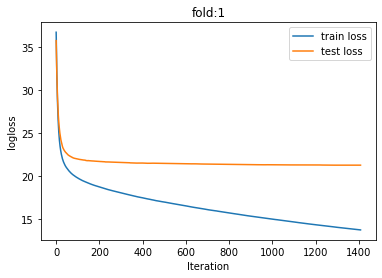

[I 2022-05-28 18:32:08,377] A new study created in memory with name: no-name-241494c7-782f-4533-8766-64354bbbd684


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 126.744	Test's l2: 620.027


[I 2022-05-28 18:32:26,908] Trial 0 finished with value: 23.28474727060668 and parameters: {'learning_rate': 0.5555585996451489, 'num_leaves': 220, 'tree_learner': 'voting', 'reg_alpha': 0.009005809851967979, 'reg_lambda': 0.008492244200880959, 'colsample_bytree': 0.8009190683537266, 'subsample': 0.8164030132726862, 'subsample_freq': 7, 'min_data_in_leaf': 56}. Best is trial 0 with value: 23.28474727060668.


Early stopping, best iteration is:
[5]	Train's l2: 420.462	Test's l2: 542.179
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 439.668	Test's l2: 517.781


[I 2022-05-28 18:32:30,057] Trial 1 finished with value: 22.663259254079293 and parameters: {'learning_rate': 0.6678244317125613, 'num_leaves': 8, 'tree_learner': 'feature', 'reg_alpha': 5.469743843271802e-07, 'reg_lambda': 0.02508423366545033, 'colsample_bytree': 0.5264382878187652, 'subsample': 0.4620489497281416, 'subsample_freq': 4, 'min_data_in_leaf': 45}. Best is trial 1 with value: 22.663259254079293.


Early stopping, best iteration is:
[87]	Train's l2: 446.117	Test's l2: 513.623
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 266.925	Test's l2: 535.918


[I 2022-05-28 18:32:39,837] Trial 2 finished with value: 22.678953821451643 and parameters: {'learning_rate': 0.3546345523401938, 'num_leaves': 91, 'tree_learner': 'data', 'reg_alpha': 2.304474044555366e-06, 'reg_lambda': 3.4213808445260785e-08, 'colsample_bytree': 0.5061967633372656, 'subsample': 0.5940480210192098, 'subsample_freq': 7, 'min_data_in_leaf': 21}. Best is trial 1 with value: 22.663259254079293.


Early stopping, best iteration is:
[33]	Train's l2: 357.921	Test's l2: 514.335
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 321.475	Test's l2: 634.233


[I 2022-05-28 18:32:45,689] Trial 3 finished with value: 23.222047147120893 and parameters: {'learning_rate': 0.5715194630117026, 'num_leaves': 66, 'tree_learner': 'feature', 'reg_alpha': 7.93003001495076e-06, 'reg_lambda': 1.3724448221610568e-05, 'colsample_bytree': 0.5904829644335317, 'subsample': 0.47563015475948756, 'subsample_freq': 7, 'min_data_in_leaf': 55}. Best is trial 1 with value: 22.663259254079293.


Early stopping, best iteration is:
[16]	Train's l2: 433.681	Test's l2: 539.263
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 173.951	Test's l2: 602.952


[I 2022-05-28 18:33:01,997] Trial 4 finished with value: 22.79338811132197 and parameters: {'learning_rate': 0.4099371061997782, 'num_leaves': 221, 'tree_learner': 'data', 'reg_alpha': 0.00853972892804801, 'reg_lambda': 1.0309179217035073e-06, 'colsample_bytree': 0.9264378986391356, 'subsample': 0.5536402592649123, 'subsample_freq': 2, 'min_data_in_leaf': 99}. Best is trial 1 with value: 22.663259254079293.


Early stopping, best iteration is:
[15]	Train's l2: 363.076	Test's l2: 519.539
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 508.612	Test's l2: 578.971
[200]	Train's l2: 468.563	Test's l2: 560.37
[300]	Train's l2: 449.066	Test's l2: 547.064
[400]	Train's l2: 435.255	Test's l2: 541.017
[500]	Train's l2: 422.922	Test's l2: 543.608


[I 2022-05-28 18:33:08,501] Trial 5 finished with value: 23.217152858013534 and parameters: {'learning_rate': 0.881611747232242, 'num_leaves': 3, 'tree_learner': 'data', 'reg_alpha': 0.0014497971393986739, 'reg_lambda': 1.222590371378608e-05, 'colsample_bytree': 0.5564963996742007, 'subsample': 0.9271334520085508, 'subsample_freq': 7, 'min_data_in_leaf': 81}. Best is trial 1 with value: 22.663259254079293.


Early stopping, best iteration is:
[427]	Train's l2: 431.982	Test's l2: 539.036
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 461.439	Test's l2: 507.01
[200]	Train's l2: 428.489	Test's l2: 496.112
[300]	Train's l2: 409.736	Test's l2: 492.599
[400]	Train's l2: 395.941	Test's l2: 492.859


[I 2022-05-28 18:33:14,991] Trial 6 finished with value: 22.146285170769694 and parameters: {'learning_rate': 0.20778374104347075, 'num_leaves': 7, 'tree_learner': 'data', 'reg_alpha': 3.5616674414840494e-05, 'reg_lambda': 0.002696560907134986, 'colsample_bytree': 0.5297566872871036, 'subsample': 0.4150134715269661, 'subsample_freq': 1, 'min_data_in_leaf': 30}. Best is trial 6 with value: 22.146285170769694.


Early stopping, best iteration is:
[346]	Train's l2: 402.498	Test's l2: 490.458
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 349.035	Test's l2: 535.068


[I 2022-05-28 18:33:19,912] Trial 7 finished with value: 22.727835417951944 and parameters: {'learning_rate': 0.6324648756533997, 'num_leaves': 29, 'tree_learner': 'voting', 'reg_alpha': 0.006889251399079859, 'reg_lambda': 0.07826650884663498, 'colsample_bytree': 0.42978815851518226, 'subsample': 0.8766317814530229, 'subsample_freq': 3, 'min_data_in_leaf': 87}. Best is trial 6 with value: 22.146285170769694.


Early stopping, best iteration is:
[33]	Train's l2: 422.796	Test's l2: 516.555
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 153.607	Test's l2: 699.569


[I 2022-05-28 18:33:33,024] Trial 8 finished with value: 23.475995758007315 and parameters: {'learning_rate': 0.57109563396434, 'num_leaves': 239, 'tree_learner': 'feature', 'reg_alpha': 3.110648669558319e-08, 'reg_lambda': 0.038245792322196985, 'colsample_bytree': 0.6356993703499223, 'subsample': 0.6299816424120722, 'subsample_freq': 5, 'min_data_in_leaf': 84}. Best is trial 6 with value: 22.146285170769694.


Early stopping, best iteration is:
[6]	Train's l2: 424.507	Test's l2: 551.122
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 294.114	Test's l2: 856.526


[I 2022-05-28 18:33:39,332] Trial 9 finished with value: 24.00412076106164 and parameters: {'learning_rate': 0.734300353261751, 'num_leaves': 106, 'tree_learner': 'serial', 'reg_alpha': 6.287784289517463e-07, 'reg_lambda': 0.02497572369728911, 'colsample_bytree': 0.6589855601056596, 'subsample': 0.5084212239308568, 'subsample_freq': 4, 'min_data_in_leaf': 43}. Best is trial 6 with value: 22.146285170769694.


Early stopping, best iteration is:
[5]	Train's l2: 486.657	Test's l2: 576.198
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 283.333	Test's l2: 473.331
[200]	Train's l2: 215.388	Test's l2: 472.866
[300]	Train's l2: 172.316	Test's l2: 472.995
Early stopping, best iteration is:
[246]	Train's l2: 193.566	Test's l2: 472.282


[I 2022-05-28 18:34:17,353] Trial 10 finished with value: 21.732056939759794 and parameters: {'learning_rate': 0.10114323370307071, 'num_leaves': 160, 'tree_learner': 'serial', 'reg_alpha': 4.620476856848657, 'reg_lambda': 2.1452352663798, 'colsample_bytree': 0.7891222930001495, 'subsample': 0.7235739192724312, 'subsample_freq': 1, 'min_data_in_leaf': 11}. Best is trial 10 with value: 21.732056939759794.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 273.882	Test's l2: 473.895
[200]	Train's l2: 205.843	Test's l2: 474.055
Early stopping, best iteration is:
[129]	Train's l2: 249.334	Test's l2: 472.079


[I 2022-05-28 18:34:41,761] Trial 11 finished with value: 21.727389231492445 and parameters: {'learning_rate': 0.12394738308207427, 'num_leaves': 158, 'tree_learner': 'serial', 'reg_alpha': 5.394126472416736, 'reg_lambda': 8.96595619788872, 'colsample_bytree': 0.7767619488693804, 'subsample': 0.7354513505172098, 'subsample_freq': 1, 'min_data_in_leaf': 5}. Best is trial 11 with value: 21.727389231492445.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 285.324	Test's l2: 470.468
[200]	Train's l2: 217.321	Test's l2: 468.97
Early stopping, best iteration is:
[190]	Train's l2: 222.603	Test's l2: 468.4


[I 2022-05-28 18:35:12,937] Trial 12 finished with value: 21.642552950949806 and parameters: {'learning_rate': 0.10203830895918056, 'num_leaves': 161, 'tree_learner': 'serial', 'reg_alpha': 5.168260365604238, 'reg_lambda': 5.1000603760703935, 'colsample_bytree': 0.773054765149063, 'subsample': 0.7334715184599101, 'subsample_freq': 1, 'min_data_in_leaf': 8}. Best is trial 12 with value: 21.642552950949806.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 210.617	Test's l2: 497.042


[I 2022-05-28 18:35:34,620] Trial 13 finished with value: 22.104341826767588 and parameters: {'learning_rate': 0.2652584508442316, 'num_leaves': 162, 'tree_learner': 'serial', 'reg_alpha': 9.589530950593678, 'reg_lambda': 7.291730955514394, 'colsample_bytree': 0.7646045377092942, 'subsample': 0.7209259836306924, 'subsample_freq': 2, 'min_data_in_leaf': 8}. Best is trial 12 with value: 21.642552950949806.


Early stopping, best iteration is:
[31]	Train's l2: 321.928	Test's l2: 488.602
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 264.804	Test's l2: 472.744
[200]	Train's l2: 196.055	Test's l2: 473.171
Early stopping, best iteration is:
[116]	Train's l2: 250.923	Test's l2: 471.453


[I 2022-05-28 18:36:03,294] Trial 14 finished with value: 21.712961877742842 and parameters: {'learning_rate': 0.12071321088418263, 'num_leaves': 164, 'tree_learner': 'serial', 'reg_alpha': 0.31806005661634523, 'reg_lambda': 0.6941681190848937, 'colsample_bytree': 0.9216745231440704, 'subsample': 0.7949897072111418, 'subsample_freq': 2, 'min_data_in_leaf': 26}. Best is trial 12 with value: 21.642552950949806.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 152.037	Test's l2: 528.568


[I 2022-05-28 18:36:18,352] Trial 15 finished with value: 22.491639929963313 and parameters: {'learning_rate': 0.3769099747098947, 'num_leaves': 188, 'tree_learner': 'serial', 'reg_alpha': 0.12483984258609722, 'reg_lambda': 0.47050862016278794, 'colsample_bytree': 0.9590155965298807, 'subsample': 0.9819860225402188, 'subsample_freq': 2, 'min_data_in_leaf': 25}. Best is trial 12 with value: 21.642552950949806.


Early stopping, best iteration is:
[22]	Train's l2: 307.358	Test's l2: 505.874
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 245.585	Test's l2: 484.24


[I 2022-05-28 18:36:34,978] Trial 16 finished with value: 21.980669106921088 and parameters: {'learning_rate': 0.22172812383816914, 'num_leaves': 127, 'tree_learner': 'serial', 'reg_alpha': 0.2197359628365441, 'reg_lambda': 0.0006716802687934042, 'colsample_bytree': 0.8797820379074512, 'subsample': 0.8139191107456386, 'subsample_freq': 3, 'min_data_in_leaf': 35}. Best is trial 12 with value: 21.642552950949806.


Early stopping, best iteration is:
[92]	Train's l2: 253.295	Test's l2: 483.15
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 158.94	Test's l2: 572.307


[I 2022-05-28 18:36:48,645] Trial 17 finished with value: 22.753174012887992 and parameters: {'learning_rate': 0.4225697174394959, 'num_leaves': 190, 'tree_learner': 'serial', 'reg_alpha': 0.38331760941694226, 'reg_lambda': 0.3113185221910427, 'colsample_bytree': 0.9969464046703159, 'subsample': 0.6442048564261504, 'subsample_freq': 3, 'min_data_in_leaf': 19}. Best is trial 12 with value: 21.642552950949806.


Early stopping, best iteration is:
[8]	Train's l2: 397.736	Test's l2: 517.707
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 228.981	Test's l2: 499.876


[I 2022-05-28 18:36:58,983] Trial 18 finished with value: 22.14380174844152 and parameters: {'learning_rate': 0.29039329105167067, 'num_leaves': 132, 'tree_learner': 'serial', 'reg_alpha': 0.6322535027214063, 'reg_lambda': 0.5296782628242725, 'colsample_bytree': 0.877595498173324, 'subsample': 0.7818819007805128, 'subsample_freq': 5, 'min_data_in_leaf': 68}. Best is trial 12 with value: 21.642552950949806.


Early stopping, best iteration is:
[26]	Train's l2: 346.273	Test's l2: 490.348
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 131.842	Test's l2: 958.132


[I 2022-05-28 18:37:09,800] Trial 19 finished with value: 24.91402792835362 and parameters: {'learning_rate': 0.9908373705892737, 'num_leaves': 192, 'tree_learner': 'voting', 'reg_alpha': 0.048221756869497395, 'reg_lambda': 0.00013746519469631734, 'colsample_bytree': 0.7073441956317634, 'subsample': 0.884011979678811, 'subsample_freq': 2, 'min_data_in_leaf': 14}. Best is trial 12 with value: 21.642552950949806.


Early stopping, best iteration is:
[2]	Train's l2: 521.801	Test's l2: 620.709
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 326.556	Test's l2: 485.366
[200]	Train's l2: 269.052	Test's l2: 487.545


[I 2022-05-28 18:37:19,944] Trial 20 finished with value: 22.007056265531393 and parameters: {'learning_rate': 0.19413374892463459, 'num_leaves': 59, 'tree_learner': 'serial', 'reg_alpha': 0.00020193052010523385, 'reg_lambda': 1.3278514318305383, 'colsample_bytree': 0.876353032966684, 'subsample': 0.6633966478058673, 'subsample_freq': 1, 'min_data_in_leaf': 37}. Best is trial 12 with value: 21.642552950949806.


Early stopping, best iteration is:
[114]	Train's l2: 316.52	Test's l2: 484.311
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 282.901	Test's l2: 468.563
[200]	Train's l2: 216.141	Test's l2: 463.069
[300]	Train's l2: 173.336	Test's l2: 464.229
Early stopping, best iteration is:
[222]	Train's l2: 205.558	Test's l2: 462.415


[I 2022-05-28 18:37:52,457] Trial 21 finished with value: 21.503844164569582 and parameters: {'learning_rate': 0.11587431494625594, 'num_leaves': 151, 'tree_learner': 'serial', 'reg_alpha': 2.1050412498288087, 'reg_lambda': 7.962086859186755, 'colsample_bytree': 0.7432702566107056, 'subsample': 0.764553716279821, 'subsample_freq': 1, 'min_data_in_leaf': 5}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 299.821	Test's l2: 468.924
[200]	Train's l2: 236.946	Test's l2: 465.779
[300]	Train's l2: 195.034	Test's l2: 464.888
[400]	Train's l2: 163.583	Test's l2: 463.973
[500]	Train's l2: 138.765	Test's l2: 462.753
Early stopping, best iteration is:
[492]	Train's l2: 140.544	Test's l2: 462.49


[I 2022-05-28 18:38:40,837] Trial 22 finished with value: 21.50558475723471 and parameters: {'learning_rate': 0.10926830190137429, 'num_leaves': 130, 'tree_learner': 'serial', 'reg_alpha': 0.9443339790871278, 'reg_lambda': 8.173468928851632, 'colsample_bytree': 0.8334044248799255, 'subsample': 0.7836890185514266, 'subsample_freq': 1, 'min_data_in_leaf': 16}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 220.856	Test's l2: 505.125


[I 2022-05-28 18:38:53,883] Trial 23 finished with value: 22.251732119452015 and parameters: {'learning_rate': 0.3037151840535482, 'num_leaves': 127, 'tree_learner': 'serial', 'reg_alpha': 1.1378185380343362, 'reg_lambda': 4.2510970751223685, 'colsample_bytree': 0.7224593265695048, 'subsample': 0.8600449785530875, 'subsample_freq': 1, 'min_data_in_leaf': 15}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[44]	Train's l2: 301.942	Test's l2: 495.14
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 280.929	Test's l2: 476.608


[I 2022-05-28 18:39:08,129] Trial 24 finished with value: 21.813878085966262 and parameters: {'learning_rate': 0.181959984985277, 'num_leaves': 103, 'tree_learner': 'serial', 'reg_alpha': 0.03340182390356728, 'reg_lambda': 5.185334333128065, 'colsample_bytree': 0.8174319297095797, 'subsample': 0.7635277195529415, 'subsample_freq': 1, 'min_data_in_leaf': 5}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[83]	Train's l2: 297.22	Test's l2: 475.845
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 292.443	Test's l2: 469.543
[200]	Train's l2: 226.546	Test's l2: 466.138
[300]	Train's l2: 183.039	Test's l2: 465.534
Early stopping, best iteration is:
[227]	Train's l2: 213.384	Test's l2: 464.834


[I 2022-05-28 18:39:37,756] Trial 25 finished with value: 21.559999059121665 and parameters: {'learning_rate': 0.10218547915316067, 'num_leaves': 142, 'tree_learner': 'serial', 'reg_alpha': 1.9866291824964262, 'reg_lambda': 0.1364418242720025, 'colsample_bytree': 0.8360889410841018, 'subsample': 0.6854008544090364, 'subsample_freq': 3, 'min_data_in_leaf': 17}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 192.138	Test's l2: 579.871


[I 2022-05-28 18:39:48,898] Trial 26 finished with value: 23.147037872989458 and parameters: {'learning_rate': 0.43581034930143187, 'num_leaves': 142, 'tree_learner': 'serial', 'reg_alpha': 0.8772191946311759, 'reg_lambda': 0.15054030932211365, 'colsample_bytree': 0.837431035568563, 'subsample': 0.6847515445873062, 'subsample_freq': 5, 'min_data_in_leaf': 19}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[15]	Train's l2: 365.847	Test's l2: 535.785
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 233.217	Test's l2: 604.87


[I 2022-05-28 18:39:56,892] Trial 27 finished with value: 23.187887394232174 and parameters: {'learning_rate': 0.4906937975797228, 'num_leaves': 111, 'tree_learner': 'feature', 'reg_alpha': 0.0007083971882577703, 'reg_lambda': 0.17507474904531709, 'colsample_bytree': 0.7299400691285066, 'subsample': 0.5960251344044015, 'subsample_freq': 3, 'min_data_in_leaf': 31}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[11]	Train's l2: 411.151	Test's l2: 537.678
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 317.039	Test's l2: 481.934
[200]	Train's l2: 259.768	Test's l2: 481.281
Early stopping, best iteration is:
[178]	Train's l2: 270.467	Test's l2: 479.435


[I 2022-05-28 18:40:13,074] Trial 28 finished with value: 21.896011573965968 and parameters: {'learning_rate': 0.1711731653136065, 'num_leaves': 76, 'tree_learner': 'voting', 'reg_alpha': 0.04783511658623225, 'reg_lambda': 0.003851332190985107, 'colsample_bytree': 0.6470634256127772, 'subsample': 0.6927225432440502, 'subsample_freq': 6, 'min_data_in_leaf': 44}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 183.558	Test's l2: 493.882


[I 2022-05-28 18:40:31,943] Trial 29 finished with value: 22.09250100013673 and parameters: {'learning_rate': 0.25572735285220893, 'num_leaves': 182, 'tree_learner': 'voting', 'reg_alpha': 1.6932197162910787, 'reg_lambda': 0.01013390690964177, 'colsample_bytree': 0.8395084441787061, 'subsample': 0.9353826079531239, 'subsample_freq': 2, 'min_data_in_leaf': 14}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[52]	Train's l2: 250.372	Test's l2: 488.079
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 254.527	Test's l2: 472.202
[200]	Train's l2: 184.708	Test's l2: 474.344
Early stopping, best iteration is:
[137]	Train's l2: 223.777	Test's l2: 471.698


[I 2022-05-28 18:40:55,784] Trial 30 finished with value: 21.71861554839266 and parameters: {'learning_rate': 0.16002313343093794, 'num_leaves': 146, 'tree_learner': 'serial', 'reg_alpha': 0.0026890719465916513, 'reg_lambda': 1.5948802754781197, 'colsample_bytree': 0.7465700511686462, 'subsample': 0.8218010327517935, 'subsample_freq': 3, 'min_data_in_leaf': 23}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 264.592	Test's l2: 468.262
[200]	Train's l2: 193.525	Test's l2: 468.466
Early stopping, best iteration is:
[134]	Train's l2: 235.768	Test's l2: 466.516


[I 2022-05-28 18:41:25,479] Trial 31 finished with value: 21.59898231729227 and parameters: {'learning_rate': 0.10860574833738376, 'num_leaves': 210, 'tree_learner': 'serial', 'reg_alpha': 2.6760081215956895, 'reg_lambda': 1.6582814237805428, 'colsample_bytree': 0.6799924116971487, 'subsample': 0.7444980015253415, 'subsample_freq': 1, 'min_data_in_leaf': 64}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 149.516	Test's l2: 530.383


[I 2022-05-28 18:41:43,037] Trial 32 finished with value: 22.41915859870054 and parameters: {'learning_rate': 0.3310055542718212, 'num_leaves': 256, 'tree_learner': 'serial', 'reg_alpha': 1.7858902785202309, 'reg_lambda': 1.391218077202605, 'colsample_bytree': 0.6694505217792776, 'subsample': 0.7633679491380453, 'subsample_freq': 2, 'min_data_in_leaf': 63}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[14]	Train's l2: 350.485	Test's l2: 502.619
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 193.992	Test's l2: 495.419


[I 2022-05-28 18:42:02,858] Trial 33 finished with value: 22.145982150448116 and parameters: {'learning_rate': 0.2405232099887165, 'num_leaves': 210, 'tree_learner': 'serial', 'reg_alpha': 0.09565417648396655, 'reg_lambda': 0.08557791081023874, 'colsample_bytree': 0.689772018126438, 'subsample': 0.8324222786128213, 'subsample_freq': 1, 'min_data_in_leaf': 69}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[51]	Train's l2: 263.517	Test's l2: 490.445
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 235.634	Test's l2: 470.475
[200]	Train's l2: 162.67	Test's l2: 476.234
Early stopping, best iteration is:
[102]	Train's l2: 233.546	Test's l2: 470.112


[I 2022-05-28 18:42:27,337] Trial 34 finished with value: 21.682075707129638 and parameters: {'learning_rate': 0.15555515395405572, 'num_leaves': 205, 'tree_learner': 'feature', 'reg_alpha': 1.819986462208064, 'reg_lambda': 1.90485815083625, 'colsample_bytree': 0.6182636878526341, 'subsample': 0.7612274963087834, 'subsample_freq': 4, 'min_data_in_leaf': 51}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 270.909	Test's l2: 775.282


[I 2022-05-28 18:42:34,007] Trial 35 finished with value: 24.328371227766656 and parameters: {'learning_rate': 0.7789929861350233, 'num_leaves': 89, 'tree_learner': 'serial', 'reg_alpha': 7.45947664700193, 'reg_lambda': 0.29321674971299205, 'colsample_bytree': 0.8247234419593812, 'subsample': 0.6191058728290579, 'subsample_freq': 2, 'min_data_in_leaf': 59}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[6]	Train's l2: 471.56	Test's l2: 591.87
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 225.689	Test's l2: 483.51
Early stopping, best iteration is:
[79]	Train's l2: 250.295	Test's l2: 481.512


[I 2022-05-28 18:43:00,282] Trial 36 finished with value: 21.943376457712205 and parameters: {'learning_rate': 0.14669302514442295, 'num_leaves': 228, 'tree_learner': 'data', 'reg_alpha': 0.025154012169040906, 'reg_lambda': 1.1599858668530084e-06, 'colsample_bytree': 0.8518210925429376, 'subsample': 0.6595546906132479, 'subsample_freq': 1, 'min_data_in_leaf': 52}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 240.206	Test's l2: 492.454


[I 2022-05-28 18:43:15,801] Trial 37 finished with value: 21.99019011076805 and parameters: {'learning_rate': 0.21961277929041523, 'num_leaves': 173, 'tree_learner': 'serial', 'reg_alpha': 0.24243987886920862, 'reg_lambda': 0.018595853451005187, 'colsample_bytree': 0.5851698921938117, 'subsample': 0.5548280260046845, 'subsample_freq': 2, 'min_data_in_leaf': 73}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[39]	Train's l2: 326.252	Test's l2: 483.568
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 226.174	Test's l2: 589.903


[I 2022-05-28 18:43:25,307] Trial 38 finished with value: 23.28134097309607 and parameters: {'learning_rate': 0.4995809464302768, 'num_leaves': 117, 'tree_learner': 'data', 'reg_alpha': 8.628809789560591e-05, 'reg_lambda': 9.002347572687642, 'colsample_bytree': 0.8000536651943555, 'subsample': 0.6923717353729533, 'subsample_freq': 4, 'min_data_in_leaf': 100}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[17]	Train's l2: 379.019	Test's l2: 542.021
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 205.181	Test's l2: 517.664


[I 2022-05-28 18:43:37,108] Trial 39 finished with value: 22.48598780361358 and parameters: {'learning_rate': 0.3254250030516094, 'num_leaves': 145, 'tree_learner': 'feature', 'reg_alpha': 0.009027137925142124, 'reg_lambda': 0.06352246465337696, 'colsample_bytree': 0.46572291007824757, 'subsample': 0.906065538990729, 'subsample_freq': 1, 'min_data_in_leaf': 18}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[26]	Train's l2: 336.739	Test's l2: 505.62
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 373.504	Test's l2: 477.646
[200]	Train's l2: 327.535	Test's l2: 471.464
[300]	Train's l2: 296.974	Test's l2: 469.028
[400]	Train's l2: 272.925	Test's l2: 468.005
[500]	Train's l2: 252.594	Test's l2: 467.373
[600]	Train's l2: 234.267	Test's l2: 465.252
[700]	Train's l2: 219.112	Test's l2: 465.237
Early stopping, best iteration is:
[607]	Train's l2: 233.108	Test's l2: 464.877


[I 2022-05-28 18:44:06,749] Trial 40 finished with value: 21.561000429268567 and parameters: {'learning_rate': 0.10236891957284375, 'num_leaves': 48, 'tree_learner': 'serial', 'reg_alpha': 2.6744178645107927e-08, 'reg_lambda': 6.512661552837032e-08, 'colsample_bytree': 0.9186984412589849, 'subsample': 0.8472978936504757, 'subsample_freq': 6, 'min_data_in_leaf': 38}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 378.183	Test's l2: 484.759
[200]	Train's l2: 334.655	Test's l2: 478.913
[300]	Train's l2: 306.841	Test's l2: 476.914
[400]	Train's l2: 283.686	Test's l2: 474.73
[500]	Train's l2: 264.242	Test's l2: 473.939
[600]	Train's l2: 246.791	Test's l2: 472.081
[700]	Train's l2: 231.781	Test's l2: 473.232
Early stopping, best iteration is:
[609]	Train's l2: 245.299	Test's l2: 471.938


[I 2022-05-28 18:44:36,885] Trial 41 finished with value: 21.724136615677775 and parameters: {'learning_rate': 0.10010826701267778, 'num_leaves': 46, 'tree_learner': 'serial', 'reg_alpha': 3.57875865436973e-08, 'reg_lambda': 3.74476953202911e-05, 'colsample_bytree': 0.913883146882658, 'subsample': 0.8582736545817369, 'subsample_freq': 6, 'min_data_in_leaf': 79}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 380.026	Test's l2: 493.229
[200]	Train's l2: 338.457	Test's l2: 483.652
[300]	Train's l2: 308.153	Test's l2: 484.38


[I 2022-05-28 18:44:46,053] Trial 42 finished with value: 21.973326075132846 and parameters: {'learning_rate': 0.2028640087314954, 'num_leaves': 25, 'tree_learner': 'serial', 'reg_alpha': 7.81446889184497e-06, 'reg_lambda': 8.220580995847598e-08, 'colsample_bytree': 0.9609886464826031, 'subsample': 0.8409755042612035, 'subsample_freq': 6, 'min_data_in_leaf': 39}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[224]	Train's l2: 330.164	Test's l2: 482.827
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 304.709	Test's l2: 480.485
[200]	Train's l2: 242.155	Test's l2: 481.35
Early stopping, best iteration is:
[160]	Train's l2: 263.733	Test's l2: 479.77


[I 2022-05-28 18:45:04,863] Trial 43 finished with value: 21.903651106697122 and parameters: {'learning_rate': 0.15360853263283777, 'num_leaves': 91, 'tree_learner': 'serial', 'reg_alpha': 1.151464397820392e-07, 'reg_lambda': 3.6539613221818454e-08, 'colsample_bytree': 0.7496165679668146, 'subsample': 0.7807321002201062, 'subsample_freq': 7, 'min_data_in_leaf': 29}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 226.642	Test's l2: 499.347


[I 2022-05-28 18:45:17,060] Trial 44 finished with value: 22.143049206973622 and parameters: {'learning_rate': 0.26806272620093163, 'num_leaves': 121, 'tree_learner': 'data', 'reg_alpha': 5.842820803620972e-07, 'reg_lambda': 4.1664593487784513e-07, 'colsample_bytree': 0.8904887803215236, 'subsample': 0.8036347675150906, 'subsample_freq': 3, 'min_data_in_leaf': 10}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[49]	Train's l2: 294.893	Test's l2: 490.315
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 285.7	Test's l2: 468.87
[200]	Train's l2: 220.266	Test's l2: 470.885
Early stopping, best iteration is:
[114]	Train's l2: 274.147	Test's l2: 467.546


[I 2022-05-28 18:45:35,068] Trial 45 finished with value: 21.62281889406155 and parameters: {'learning_rate': 0.13340428368515841, 'num_leaves': 136, 'tree_learner': 'serial', 'reg_alpha': 1.1025410499166385e-08, 'reg_lambda': 0.00036572011219883767, 'colsample_bytree': 0.6877460140354055, 'subsample': 0.7471442269162373, 'subsample_freq': 5, 'min_data_in_leaf': 56}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 226.387	Test's l2: 485.699
Early stopping, best iteration is:
[78]	Train's l2: 250.677	Test's l2: 484.324


[I 2022-05-28 18:45:59,650] Trial 46 finished with value: 22.007372331848796 and parameters: {'learning_rate': 0.20135959051275776, 'num_leaves': 176, 'tree_learner': 'serial', 'reg_alpha': 3.083028429864802, 'reg_lambda': 5.211660560170082e-06, 'colsample_bytree': 0.8059296582407939, 'subsample': 0.704444390192874, 'subsample_freq': 6, 'min_data_in_leaf': 49}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 261.609	Test's l2: 475.082
[200]	Train's l2: 191.381	Test's l2: 477.539
Early stopping, best iteration is:
[101]	Train's l2: 260.717	Test's l2: 474.587


[I 2022-05-28 18:46:22,717] Trial 47 finished with value: 21.7850220543911 and parameters: {'learning_rate': 0.1420065639063476, 'num_leaves': 151, 'tree_learner': 'voting', 'reg_alpha': 5.193103109667621e-06, 'reg_lambda': 0.0014797044452395742, 'colsample_bytree': 0.9523195193780358, 'subsample': 0.7204683799924119, 'subsample_freq': 1, 'min_data_in_leaf': 33}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 322.331	Test's l2: 470.076
[200]	Train's l2: 265.273	Test's l2: 467.048
[300]	Train's l2: 226.988	Test's l2: 465.272
Early stopping, best iteration is:
[261]	Train's l2: 240.479	Test's l2: 464.908


[I 2022-05-28 18:46:50,524] Trial 48 finished with value: 21.561728279420983 and parameters: {'learning_rate': 0.10044352704501658, 'num_leaves': 99, 'tree_learner': 'serial', 'reg_alpha': 2.982593659242625e-05, 'reg_lambda': 1.017188476311184, 'colsample_bytree': 0.8580933964805635, 'subsample': 0.9474085366219948, 'subsample_freq': 4, 'min_data_in_leaf': 27}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 196.471	Test's l2: 588.254


[I 2022-05-28 18:46:59,625] Trial 49 finished with value: 23.17473629200221 and parameters: {'learning_rate': 0.6558610767935962, 'num_leaves': 98, 'tree_learner': 'serial', 'reg_alpha': 2.1218125227186526e-05, 'reg_lambda': 3.399974668155991, 'colsample_bytree': 0.9048272892345304, 'subsample': 0.9853860355676844, 'subsample_freq': 4, 'min_data_in_leaf': 23}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[15]	Train's l2: 375.296	Test's l2: 537.068
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 263.734	Test's l2: 503.269


[I 2022-05-28 18:47:07,663] Trial 50 finished with value: 22.335360968602608 and parameters: {'learning_rate': 0.35561594087751863, 'num_leaves': 74, 'tree_learner': 'feature', 'reg_alpha': 2.2122307900583014e-07, 'reg_lambda': 0.6733424185439132, 'colsample_bytree': 0.8617744520844869, 'subsample': 0.9262133339342234, 'subsample_freq': 5, 'min_data_in_leaf': 27}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[34]	Train's l2: 349.689	Test's l2: 498.868
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 370.867	Test's l2: 477.806
[200]	Train's l2: 323.211	Test's l2: 470.002
[300]	Train's l2: 292.537	Test's l2: 466.109
[400]	Train's l2: 267.893	Test's l2: 465.561
[500]	Train's l2: 247.323	Test's l2: 464.96
Early stopping, best iteration is:
[467]	Train's l2: 253.53	Test's l2: 464.63


[I 2022-05-28 18:47:33,252] Trial 51 finished with value: 21.555268719503122 and parameters: {'learning_rate': 0.10145410850425668, 'num_leaves': 49, 'tree_learner': 'serial', 'reg_alpha': 1.3358382530839077e-06, 'reg_lambda': 2.346134953131348, 'colsample_bytree': 0.9375636122496757, 'subsample': 0.9046470163631667, 'subsample_freq': 4, 'min_data_in_leaf': 16}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 393.074	Test's l2: 478.437
[200]	Train's l2: 352.663	Test's l2: 472.022


[I 2022-05-28 18:47:41,391] Trial 52 finished with value: 21.71790572171894 and parameters: {'learning_rate': 0.17295820675534335, 'num_leaves': 22, 'tree_learner': 'serial', 'reg_alpha': 1.1176598375780746e-06, 'reg_lambda': 0.7935796139466875, 'colsample_bytree': 0.9458659900291826, 'subsample': 0.9616784426061827, 'subsample_freq': 4, 'min_data_in_leaf': 13}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[194]	Train's l2: 354.552	Test's l2: 471.667
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 355.59	Test's l2: 476.058
[200]	Train's l2: 305.819	Test's l2: 470.155
[300]	Train's l2: 272.269	Test's l2: 466.706
[400]	Train's l2: 246.011	Test's l2: 465.966
[500]	Train's l2: 224.242	Test's l2: 465.131
Early stopping, best iteration is:
[474]	Train's l2: 229.238	Test's l2: 464.814


[I 2022-05-28 18:48:11,464] Trial 53 finished with value: 21.55954257660575 and parameters: {'learning_rate': 0.10051535368990805, 'num_leaves': 63, 'tree_learner': 'serial', 'reg_alpha': 2.965789503875238e-06, 'reg_lambda': 2.822388540737339, 'colsample_bytree': 0.9915711663231614, 'subsample': 0.8986222840883688, 'subsample_freq': 4, 'min_data_in_leaf': 17}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 316.584	Test's l2: 485.082
[200]	Train's l2: 256.477	Test's l2: 486.121
Early stopping, best iteration is:
[103]	Train's l2: 314.054	Test's l2: 485.018


[I 2022-05-28 18:48:21,371] Trial 54 finished with value: 22.023133503458624 and parameters: {'learning_rate': 0.23326976819790923, 'num_leaves': 54, 'tree_learner': 'serial', 'reg_alpha': 2.4378081003268365e-06, 'reg_lambda': 3.692958113871121, 'colsample_bytree': 0.9945138692236856, 'subsample': 0.9015322670954653, 'subsample_freq': 5, 'min_data_in_leaf': 5}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 372.244	Test's l2: 484.692
[200]	Train's l2: 326.057	Test's l2: 479.003
[300]	Train's l2: 295.124	Test's l2: 476.764
[400]	Train's l2: 268.695	Test's l2: 475.19
Early stopping, best iteration is:
[395]	Train's l2: 269.728	Test's l2: 475.035


[I 2022-05-28 18:48:38,607] Trial 55 finished with value: 21.795303291600984 and parameters: {'learning_rate': 0.13282460262617046, 'num_leaves': 38, 'tree_learner': 'serial', 'reg_alpha': 1.046537957416907e-07, 'reg_lambda': 0.2198408755895047, 'colsample_bytree': 0.9719370076918891, 'subsample': 0.8678837204350992, 'subsample_freq': 4, 'min_data_in_leaf': 17}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 367.53	Test's l2: 483.47
[200]	Train's l2: 321.749	Test's l2: 480.686


[I 2022-05-28 18:48:49,558] Trial 56 finished with value: 21.906468290879253 and parameters: {'learning_rate': 0.17976712191742772, 'num_leaves': 34, 'tree_learner': 'serial', 'reg_alpha': 1.783170456905237e-06, 'reg_lambda': 8.747812036398381, 'colsample_bytree': 0.9356755814557057, 'subsample': 0.9015822574715313, 'subsample_freq': 3, 'min_data_in_leaf': 11}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[179]	Train's l2: 329.827	Test's l2: 479.893
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 287.977	Test's l2: 492.363


[I 2022-05-28 18:48:58,417] Trial 57 finished with value: 22.11791935360483 and parameters: {'learning_rate': 0.2868167032998458, 'num_leaves': 67, 'tree_learner': 'serial', 'reg_alpha': 1.2300945157667817e-08, 'reg_lambda': 2.843507107644959, 'colsample_bytree': 0.9031703167778103, 'subsample': 0.8495779672462402, 'subsample_freq': 7, 'min_data_in_leaf': 21}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[62]	Train's l2: 326.095	Test's l2: 489.202
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 389.069	Test's l2: 546.549


[I 2022-05-28 18:49:02,305] Trial 58 finished with value: 23.268327314200466 and parameters: {'learning_rate': 0.7194433058966094, 'num_leaves': 14, 'tree_learner': 'data', 'reg_alpha': 0.00016822139521075125, 'reg_lambda': 1.5952219510669182e-08, 'colsample_bytree': 0.9843231434886076, 'subsample': 0.7940507061471942, 'subsample_freq': 4, 'min_data_in_leaf': 9}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[79]	Train's l2: 403.577	Test's l2: 541.415
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 321.485	Test's l2: 475.583
[200]	Train's l2: 265.551	Test's l2: 473.323
[300]	Train's l2: 225.979	Test's l2: 472.321
Early stopping, best iteration is:
[264]	Train's l2: 239.057	Test's l2: 470.981


[I 2022-05-28 18:49:23,218] Trial 59 finished with value: 21.702103445282084 and parameters: {'learning_rate': 0.13087987191843797, 'num_leaves': 81, 'tree_learner': 'serial', 'reg_alpha': 0.6287411149422448, 'reg_lambda': 0.3613948345153219, 'colsample_bytree': 0.9774095198063456, 'subsample': 0.8195540753854271, 'subsample_freq': 3, 'min_data_in_leaf': 41}. Best is trial 21 with value: 21.503844164569582.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 329.982	Test's l2: 476.721
[200]	Train's l2: 273.664	Test's l2: 476.66


[I 2022-05-28 18:49:32,777] Trial 60 finished with value: 21.77512742017272 and parameters: {'learning_rate': 0.21314876993407586, 'num_leaves': 48, 'tree_learner': 'voting', 'reg_alpha': 1.687418778758775e-07, 'reg_lambda': 0.03895502126901513, 'colsample_bytree': 0.9319911910090809, 'subsample': 0.8747150297756603, 'subsample_freq': 5, 'min_data_in_leaf': 16}. Best is trial 21 with value: 21.503844164569582.


Early stopping, best iteration is:
[147]	Train's l2: 300.822	Test's l2: 474.156
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 355.465	Test's l2: 474.085
[200]	Train's l2: 306.145	Test's l2: 465.5
[300]	Train's l2: 273.04	Test's l2: 463.305
[400]	Train's l2: 247.374	Test's l2: 462.432
[500]	Train's l2: 224.754	Test's l2: 462.498
Early stopping, best iteration is:
[480]	Train's l2: 228.776	Test's l2: 462.121


[I 2022-05-28 18:49:59,646] Trial 61 finished with value: 21.496997922489832 and parameters: {'learning_rate': 0.10588937007515119, 'num_leaves': 60, 'tree_learner': 'serial', 'reg_alpha': 1.9428296992312895e-05, 'reg_lambda': 0.7430344124394583, 'colsample_bytree': 0.8576197233126074, 'subsample': 0.9570806727706189, 'subsample_freq': 4, 'min_data_in_leaf': 22}. Best is trial 61 with value: 21.496997922489832.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 364.588	Test's l2: 480.258
[200]	Train's l2: 318.061	Test's l2: 473.959
[300]	Train's l2: 287.271	Test's l2: 471.326
[400]	Train's l2: 261.205	Test's l2: 469.615
[500]	Train's l2: 239.42	Test's l2: 468.579
[600]	Train's l2: 221.763	Test's l2: 468.31
[700]	Train's l2: 205.263	Test's l2: 466.94
[800]	Train's l2: 191.134	Test's l2: 466.341
[900]	Train's l2: 178.088	Test's l2: 465.134
[1000]	Train's l2: 166.482	Test's l2: 465.191
[1100]	Train's l2: 156.555	Test's l2: 465.597
Early stopping, best iteration is:
[1026]	Train's l2: 163.818	Test's l2: 464.96


[I 2022-05-28 18:50:54,844] Trial 62 finished with value: 21.562929828984593 and parameters: {'learning_rate': 0.10050909765048752, 'num_leaves': 57, 'tree_learner': 'serial', 'reg_alpha': 3.6263987863371337e-06, 'reg_lambda': 5.002590551977872, 'colsample_bytree': 0.7837023205123312, 'subsample': 0.9575525056265303, 'subsample_freq': 4, 'min_data_in_leaf': 21}. Best is trial 61 with value: 21.496997922489832.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 313.242	Test's l2: 481.292
[200]	Train's l2: 254.811	Test's l2: 480.801


[I 2022-05-28 18:51:08,688] Trial 63 finished with value: 21.888748598613763 and parameters: {'learning_rate': 0.18069941370106518, 'num_leaves': 64, 'tree_learner': 'serial', 'reg_alpha': 1.304187266945979e-05, 'reg_lambda': 0.11206355812171226, 'colsample_bytree': 0.8848993230652731, 'subsample': 0.995990207639687, 'subsample_freq': 3, 'min_data_in_leaf': 7}. Best is trial 61 with value: 21.496997922489832.


Early stopping, best iteration is:
[123]	Train's l2: 296.398	Test's l2: 479.117
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 369.137	Test's l2: 481.902
[200]	Train's l2: 323.634	Test's l2: 474.561
[300]	Train's l2: 292.39	Test's l2: 474.097
Early stopping, best iteration is:
[299]	Train's l2: 292.691	Test's l2: 473.981


[I 2022-05-28 18:51:26,081] Trial 64 finished with value: 21.771099673193337 and parameters: {'learning_rate': 0.126478137342659, 'num_leaves': 42, 'tree_learner': 'serial', 'reg_alpha': 0.0009536469838246975, 'reg_lambda': 2.930832244789341, 'colsample_bytree': 0.8327277285309971, 'subsample': 0.8848743929823402, 'subsample_freq': 4, 'min_data_in_leaf': 13}. Best is trial 61 with value: 21.496997922489832.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 414.006	Test's l2: 487.259
[200]	Train's l2: 377.935	Test's l2: 480.922
[300]	Train's l2: 353.868	Test's l2: 479.399


[I 2022-05-28 18:51:35,656] Trial 65 finished with value: 21.879436262120805 and parameters: {'learning_rate': 0.1647210112522438, 'num_leaves': 16, 'tree_learner': 'serial', 'reg_alpha': 7.502112579391393e-05, 'reg_lambda': 0.6819240556693218, 'colsample_bytree': 0.9231015853633315, 'subsample': 0.9209257963304345, 'subsample_freq': 5, 'min_data_in_leaf': 23}. Best is trial 61 with value: 21.496997922489832.


Early stopping, best iteration is:
[285]	Train's l2: 356.859	Test's l2: 478.71
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 211.21	Test's l2: 493.011


[I 2022-05-28 18:51:50,436] Trial 66 finished with value: 22.101405026753316 and parameters: {'learning_rate': 0.24799917305887487, 'num_leaves': 153, 'tree_learner': 'serial', 'reg_alpha': 8.026533408197624e-07, 'reg_lambda': 5.9479853546817546e-05, 'colsample_bytree': 0.8587906163584699, 'subsample': 0.9646184995194942, 'subsample_freq': 3, 'min_data_in_leaf': 33}. Best is trial 61 with value: 21.496997922489832.


Early stopping, best iteration is:
[43]	Train's l2: 291.348	Test's l2: 488.472
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 566.952	Test's l2: 599.974
[200]	Train's l2: 541.516	Test's l2: 587.923
[300]	Train's l2: 528.303	Test's l2: 583.332


[I 2022-05-28 18:51:53,418] Trial 67 finished with value: 24.092834512015433 and parameters: {'learning_rate': 0.8621613779586017, 'num_leaves': 2, 'tree_learner': 'serial', 'reg_alpha': 2.927629866694407e-07, 'reg_lambda': 5.769472190814264, 'colsample_bytree': 0.7637424413786239, 'subsample': 0.46135112571924075, 'subsample_freq': 4, 'min_data_in_leaf': 12}. Best is trial 61 with value: 21.496997922489832.


Early stopping, best iteration is:
[289]	Train's l2: 529.673	Test's l2: 580.465
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 283.46	Test's l2: 468.949
[200]	Train's l2: 218.401	Test's l2: 465.966
Early stopping, best iteration is:
[196]	Train's l2: 220.387	Test's l2: 465.774


[I 2022-05-28 18:52:24,505] Trial 68 finished with value: 21.581792848984552 and parameters: {'learning_rate': 0.12604232988971886, 'num_leaves': 135, 'tree_learner': 'serial', 'reg_alpha': 0.00039566031504354446, 'reg_lambda': 1.8206922701123178, 'colsample_bytree': 0.8980765686519127, 'subsample': 0.8907106796634393, 'subsample_freq': 2, 'min_data_in_leaf': 47}. Best is trial 61 with value: 21.496997922489832.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 215.712	Test's l2: 615.89


[I 2022-05-28 18:52:32,972] Trial 69 finished with value: 23.55268406292988 and parameters: {'learning_rate': 0.5897976914478609, 'num_leaves': 112, 'tree_learner': 'feature', 'reg_alpha': 5.321968554284383e-08, 'reg_lambda': 0.39730972903061645, 'colsample_bytree': 0.8028359921302158, 'subsample': 0.7789928577439651, 'subsample_freq': 5, 'min_data_in_leaf': 93}. Best is trial 61 with value: 21.496997922489832.


Early stopping, best iteration is:
[15]	Train's l2: 385.142	Test's l2: 554.729
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 231.343	Test's l2: 485.518


[I 2022-05-28 18:52:51,945] Trial 70 finished with value: 21.99149090466811 and parameters: {'learning_rate': 0.19506740038671272, 'num_leaves': 166, 'tree_learner': 'serial', 'reg_alpha': 5.9856185865845986e-05, 'reg_lambda': 9.021744365249186, 'colsample_bytree': 0.8713545100026974, 'subsample': 0.8299019247243482, 'subsample_freq': 6, 'min_data_in_leaf': 19}. Best is trial 61 with value: 21.496997922489832.


Early stopping, best iteration is:
[84]	Train's l2: 248.936	Test's l2: 483.626
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 336.32	Test's l2: 475.022
[200]	Train's l2: 283.662	Test's l2: 467.724
[300]	Train's l2: 246.373	Test's l2: 465.912
[400]	Train's l2: 217.523	Test's l2: 464.335
[500]	Train's l2: 194.67	Test's l2: 464.864
Early stopping, best iteration is:
[407]	Train's l2: 215.872	Test's l2: 464.081


[I 2022-05-28 18:53:20,721] Trial 71 finished with value: 21.54253817677143 and parameters: {'learning_rate': 0.12031596380412347, 'num_leaves': 71, 'tree_learner': 'serial', 'reg_alpha': 2.628650253984376e-05, 'reg_lambda': 1.031270069913179, 'colsample_bytree': 0.845652271980841, 'subsample': 0.9455755568873078, 'subsample_freq': 4, 'min_data_in_leaf': 27}. Best is trial 61 with value: 21.496997922489832.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 310.223	Test's l2: 477.285
[200]	Train's l2: 249.911	Test's l2: 473.958
[300]	Train's l2: 208.496	Test's l2: 475.634
Early stopping, best iteration is:
[204]	Train's l2: 247.833	Test's l2: 473.781


[I 2022-05-28 18:53:40,149] Trial 72 finished with value: 21.766501433327278 and parameters: {'learning_rate': 0.15193347832724166, 'num_leaves': 82, 'tree_learner': 'serial', 'reg_alpha': 1.8709823224777555e-05, 'reg_lambda': 1.302777229188374, 'colsample_bytree': 0.8447727471703701, 'subsample': 0.9408948445261999, 'subsample_freq': 4, 'min_data_in_leaf': 24}. Best is trial 61 with value: 21.496997922489832.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 338.823	Test's l2: 474.79
[200]	Train's l2: 287.148	Test's l2: 472.065
[300]	Train's l2: 251.65	Test's l2: 470.631
[400]	Train's l2: 222.418	Test's l2: 469.848
[500]	Train's l2: 199.17	Test's l2: 469.872
Early stopping, best iteration is:
[437]	Train's l2: 213.139	Test's l2: 469.15


[I 2022-05-28 18:54:11,706] Trial 73 finished with value: 21.659861068849416 and parameters: {'learning_rate': 0.11927338428855641, 'num_leaves': 69, 'tree_learner': 'serial', 'reg_alpha': 8.548249867744244e-06, 'reg_lambda': 3.575171495898457, 'colsample_bytree': 0.9420860517677956, 'subsample': 0.9716901876988391, 'subsample_freq': 4, 'min_data_in_leaf': 30}. Best is trial 61 with value: 21.496997922489832.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 348.241	Test's l2: 482.333
[200]	Train's l2: 296.241	Test's l2: 477.57
[300]	Train's l2: 260.955	Test's l2: 477.972
Early stopping, best iteration is:
[204]	Train's l2: 294.497	Test's l2: 477.392


[I 2022-05-28 18:54:26,414] Trial 74 finished with value: 21.849312445886692 and parameters: {'learning_rate': 0.15603670643781034, 'num_leaves': 48, 'tree_learner': 'serial', 'reg_alpha': 1.4818148709122673e-06, 'reg_lambda': 0.1665803805843683, 'colsample_bytree': 0.8213399269659273, 'subsample': 0.9170044342530791, 'subsample_freq': 3, 'min_data_in_leaf': 15}. Best is trial 61 with value: 21.496997922489832.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 362.21	Test's l2: 480.139
[200]	Train's l2: 315.501	Test's l2: 475.746
[300]	Train's l2: 280.912	Test's l2: 474.738


[I 2022-05-28 18:54:38,544] Trial 75 finished with value: 21.76574825095919 and parameters: {'learning_rate': 0.2251000676109856, 'num_leaves': 31, 'tree_learner': 'serial', 'reg_alpha': 4.371977112209435e-05, 'reg_lambda': 0.8456057402799071, 'colsample_bytree': 0.7214081128302987, 'subsample': 0.9477199464033517, 'subsample_freq': 4, 'min_data_in_leaf': 20}. Best is trial 61 with value: 21.496997922489832.


Early stopping, best iteration is:
[259]	Train's l2: 294.037	Test's l2: 473.748
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 287.648	Test's l2: 473.107
[200]	Train's l2: 221.898	Test's l2: 472.288
Early stopping, best iteration is:
[196]	Train's l2: 223.821	Test's l2: 471.884


[I 2022-05-28 18:55:04,884] Trial 76 finished with value: 21.722900905803865 and parameters: {'learning_rate': 0.11714400584337215, 'num_leaves': 126, 'tree_learner': 'serial', 'reg_alpha': 0.5273204687135352, 'reg_lambda': 0.005255105666998665, 'colsample_bytree': 0.9205958697131914, 'subsample': 0.6724386266428002, 'subsample_freq': 5, 'min_data_in_leaf': 8}. Best is trial 61 with value: 21.496997922489832.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 330.495	Test's l2: 483.342
[200]	Train's l2: 276.005	Test's l2: 482.906
[300]	Train's l2: 237.48	Test's l2: 483.563
Early stopping, best iteration is:
[241]	Train's l2: 259.12	Test's l2: 482.221


[I 2022-05-28 18:55:21,286] Trial 77 finished with value: 21.959529467576736 and parameters: {'learning_rate': 0.18300988937843768, 'num_leaves': 55, 'tree_learner': 'voting', 'reg_alpha': 0.14872714523563554, 'reg_lambda': 9.910619552808572e-06, 'colsample_bytree': 0.9588574415530651, 'subsample': 0.8054156332622223, 'subsample_freq': 2, 'min_data_in_leaf': 35}. Best is trial 61 with value: 21.496997922489832.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 266.176	Test's l2: 480.295
[200]	Train's l2: 199.045	Test's l2: 478.152
Early stopping, best iteration is:
[171]	Train's l2: 214.625	Test's l2: 477.392


[I 2022-05-28 18:55:48,493] Trial 78 finished with value: 21.849309671689586 and parameters: {'learning_rate': 0.14339906886344642, 'num_leaves': 138, 'tree_learner': 'serial', 'reg_alpha': 0.00015197255782707726, 'reg_lambda': 1.8723440821924349, 'colsample_bytree': 0.8722995091510887, 'subsample': 0.9314465815959608, 'subsample_freq': 3, 'min_data_in_leaf': 26}. Best is trial 61 with value: 21.496997922489832.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 357.196	Test's l2: 466.933
[200]	Train's l2: 309.48	Test's l2: 464.321
[300]	Train's l2: 276.772	Test's l2: 464.457
Early stopping, best iteration is:
[258]	Train's l2: 289.868	Test's l2: 463.291


[I 2022-05-28 18:56:06,269] Trial 79 finished with value: 21.52419884981976 and parameters: {'learning_rate': 0.10524907868374292, 'num_leaves': 64, 'tree_learner': 'data', 'reg_alpha': 2.8712018176072865e-06, 'reg_lambda': 0.014483334471666212, 'colsample_bytree': 0.402773430491894, 'subsample': 0.7089529110141759, 'subsample_freq': 4, 'min_data_in_leaf': 17}. Best is trial 61 with value: 21.496997922489832.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 292.328	Test's l2: 474.436


[I 2022-05-28 18:56:19,314] Trial 80 finished with value: 21.729267155015336 and parameters: {'learning_rate': 0.1955818964001736, 'num_leaves': 89, 'tree_learner': 'data', 'reg_alpha': 4.285823065953885e-06, 'reg_lambda': 0.05387163075246663, 'colsample_bytree': 0.6064355199348828, 'subsample': 0.6384041064897364, 'subsample_freq': 4, 'min_data_in_leaf': 17}. Best is trial 61 with value: 21.496997922489832.


Early stopping, best iteration is:
[76]	Train's l2: 314.916	Test's l2: 472.161
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 355.875	Test's l2: 462.513
[200]	Train's l2: 306.792	Test's l2: 454.937
[300]	Train's l2: 272.554	Test's l2: 453.984
[400]	Train's l2: 245.283	Test's l2: 454.482
Early stopping, best iteration is:
[308]	Train's l2: 270.117	Test's l2: 453.505


[I 2022-05-28 18:56:40,567] Trial 81 finished with value: 21.295659025134633 and parameters: {'learning_rate': 0.10713831841799853, 'num_leaves': 63, 'tree_learner': 'data', 'reg_alpha': 1.2851960730040793e-05, 'reg_lambda': 0.001316136589068253, 'colsample_bytree': 0.5005711789190187, 'subsample': 0.716491867051974, 'subsample_freq': 4, 'min_data_in_leaf': 15}. Best is trial 81 with value: 21.295659025134633.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 333.419	Test's l2: 460.592
[200]	Train's l2: 278.82	Test's l2: 457.262
[300]	Train's l2: 242.455	Test's l2: 458.548
Early stopping, best iteration is:
[234]	Train's l2: 265.061	Test's l2: 455.813


[I 2022-05-28 18:57:00,273] Trial 82 finished with value: 21.34977332539869 and parameters: {'learning_rate': 0.12750990629985082, 'num_leaves': 77, 'tree_learner': 'data', 'reg_alpha': 1.2315482076976084e-05, 'reg_lambda': 0.013832913566627122, 'colsample_bytree': 0.4070481193693412, 'subsample': 0.7206825532191494, 'subsample_freq': 4, 'min_data_in_leaf': 16}. Best is trial 81 with value: 21.295659025134633.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 319.675	Test's l2: 473.108


[I 2022-05-28 18:57:11,994] Trial 83 finished with value: 21.70433354814929 and parameters: {'learning_rate': 0.1637063574303821, 'num_leaves': 75, 'tree_learner': 'data', 'reg_alpha': 9.147468033230784e-06, 'reg_lambda': 0.0011334686510279714, 'colsample_bytree': 0.41375430771424515, 'subsample': 0.7189769441283099, 'subsample_freq': 4, 'min_data_in_leaf': 11}. Best is trial 81 with value: 21.295659025134633.


Early stopping, best iteration is:
[85]	Train's l2: 331.44	Test's l2: 471.078
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 345.75	Test's l2: 469.312
[200]	Train's l2: 295.151	Test's l2: 465.673
Early stopping, best iteration is:
[176]	Train's l2: 305.467	Test's l2: 464.205


[I 2022-05-28 18:57:24,889] Trial 84 finished with value: 21.545416368744814 and parameters: {'learning_rate': 0.13221927480994458, 'num_leaves': 62, 'tree_learner': 'data', 'reg_alpha': 2.7962605644838315e-06, 'reg_lambda': 0.0005180988104120431, 'colsample_bytree': 0.46582034805943073, 'subsample': 0.7065331318062564, 'subsample_freq': 4, 'min_data_in_leaf': 15}. Best is trial 81 with value: 21.295659025134633.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 314.172	Test's l2: 467.733
[200]	Train's l2: 253.792	Test's l2: 472.868


[I 2022-05-28 18:57:39,165] Trial 85 finished with value: 21.615212239728105 and parameters: {'learning_rate': 0.1524474710887585, 'num_leaves': 83, 'tree_learner': 'data', 'reg_alpha': 5.0488891070880106e-06, 'reg_lambda': 0.01359365177267378, 'colsample_bytree': 0.464474454070926, 'subsample': 0.7042945367266439, 'subsample_freq': 4, 'min_data_in_leaf': 7}. Best is trial 81 with value: 21.295659025134633.


Early stopping, best iteration is:
[118]	Train's l2: 301.323	Test's l2: 467.217
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 336.365	Test's l2: 467.075
[200]	Train's l2: 282.287	Test's l2: 464.793
[300]	Train's l2: 244.333	Test's l2: 464.594
Early stopping, best iteration is:
[229]	Train's l2: 269.819	Test's l2: 463.589


[I 2022-05-28 18:57:58,895] Trial 86 finished with value: 21.53112409894325 and parameters: {'learning_rate': 0.12615245319901988, 'num_leaves': 72, 'tree_learner': 'data', 'reg_alpha': 1.678814241479616e-05, 'reg_lambda': 0.0002112070086934731, 'colsample_bytree': 0.5086973072916927, 'subsample': 0.744040748019868, 'subsample_freq': 4, 'min_data_in_leaf': 13}. Best is trial 81 with value: 21.295659025134633.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 334.374	Test's l2: 464.79
[200]	Train's l2: 279.334	Test's l2: 462.654


[I 2022-05-28 18:58:13,016] Trial 87 finished with value: 21.48982551187418 and parameters: {'learning_rate': 0.13247705191117046, 'num_leaves': 71, 'tree_learner': 'data', 'reg_alpha': 1.70903330755929e-05, 'reg_lambda': 0.00015917126652788914, 'colsample_bytree': 0.532742488159808, 'subsample': 0.7357246315331702, 'subsample_freq': 4, 'min_data_in_leaf': 14}. Best is trial 81 with value: 21.295659025134633.


Early stopping, best iteration is:
[147]	Train's l2: 305.111	Test's l2: 461.813
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 306.271	Test's l2: 484.532
[200]	Train's l2: 244.418	Test's l2: 490.637


[I 2022-05-28 18:58:27,050] Trial 88 finished with value: 22.001597614947404 and parameters: {'learning_rate': 0.2145160431672831, 'num_leaves': 73, 'tree_learner': 'data', 'reg_alpha': 2.917086366324813e-05, 'reg_lambda': 0.0001460882670456886, 'colsample_bytree': 0.5278076894253183, 'subsample': 0.7384535090825761, 'subsample_freq': 4, 'min_data_in_leaf': 21}. Best is trial 81 with value: 21.295659025134633.


Early stopping, best iteration is:
[125]	Train's l2: 287.317	Test's l2: 484.07
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 233.719	Test's l2: 556.259


[I 2022-05-28 18:58:36,539] Trial 89 finished with value: 22.88523759886648 and parameters: {'learning_rate': 0.46462226376590743, 'num_leaves': 98, 'tree_learner': 'data', 'reg_alpha': 1.7459790883263983e-05, 'reg_lambda': 0.000215428678279847, 'colsample_bytree': 0.5523895013365501, 'subsample': 0.7473580616819505, 'subsample_freq': 4, 'min_data_in_leaf': 13}. Best is trial 81 with value: 21.295659025134633.


Early stopping, best iteration is:
[12]	Train's l2: 414.209	Test's l2: 523.734
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 251.42	Test's l2: 498.736


[I 2022-05-28 18:58:47,197] Trial 90 finished with value: 22.151148042389504 and parameters: {'learning_rate': 0.27158533623235737, 'num_leaves': 107, 'tree_learner': 'data', 'reg_alpha': 0.00011827515522888749, 'reg_lambda': 0.0018067982560638059, 'colsample_bytree': 0.5038761564929098, 'subsample': 0.7603864877029994, 'subsample_freq': 5, 'min_data_in_leaf': 10}. Best is trial 81 with value: 21.295659025134633.


Early stopping, best iteration is:
[36]	Train's l2: 341.686	Test's l2: 490.673
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 346.853	Test's l2: 465.328
[200]	Train's l2: 295.777	Test's l2: 463.074


[I 2022-05-28 18:58:59,282] Trial 91 finished with value: 21.510251370171183 and parameters: {'learning_rate': 0.13079481676849153, 'num_leaves': 62, 'tree_learner': 'data', 'reg_alpha': 0.0002695561331944359, 'reg_lambda': 0.006199608199039444, 'colsample_bytree': 0.4492339928627755, 'subsample': 0.7095985128344203, 'subsample_freq': 4, 'min_data_in_leaf': 14}. Best is trial 81 with value: 21.295659025134633.


Early stopping, best iteration is:
[131]	Train's l2: 328.277	Test's l2: 462.691
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 323.392	Test's l2: 474.56


[I 2022-05-28 18:59:10,069] Trial 92 finished with value: 21.759121242283143 and parameters: {'learning_rate': 0.1749743325263677, 'num_leaves': 67, 'tree_learner': 'data', 'reg_alpha': 4.2883773771227826e-05, 'reg_lambda': 0.006941123682146126, 'colsample_bytree': 0.4404385036388377, 'subsample': 0.6742073439534183, 'subsample_freq': 4, 'min_data_in_leaf': 5}. Best is trial 81 with value: 21.295659025134633.


Early stopping, best iteration is:
[93]	Train's l2: 328.966	Test's l2: 473.459
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 318.844	Test's l2: 473.542
[200]	Train's l2: 259.558	Test's l2: 471.062
[300]	Train's l2: 219.779	Test's l2: 473.555
Early stopping, best iteration is:
[200]	Train's l2: 259.558	Test's l2: 471.062


[I 2022-05-28 18:59:29,613] Trial 93 finished with value: 21.703954547394453 and parameters: {'learning_rate': 0.142101341350898, 'num_leaves': 81, 'tree_learner': 'data', 'reg_alpha': 1.0689665031830336e-05, 'reg_lambda': 9.629948433302871e-05, 'colsample_bytree': 0.48946201746540047, 'subsample': 0.7739215212639705, 'subsample_freq': 1, 'min_data_in_leaf': 8}. Best is trial 81 with value: 21.295659025134633.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 360.351	Test's l2: 467.082
[200]	Train's l2: 312.975	Test's l2: 463.54
[300]	Train's l2: 280.346	Test's l2: 463.851
Early stopping, best iteration is:
[249]	Train's l2: 295.862	Test's l2: 462.518


[I 2022-05-28 18:59:44,112] Trial 94 finished with value: 21.50623909928066 and parameters: {'learning_rate': 0.1178840261385595, 'num_leaves': 57, 'tree_learner': 'data', 'reg_alpha': 0.0003044901614927162, 'reg_lambda': 0.0007400192157209174, 'colsample_bytree': 0.40570896230983977, 'subsample': 0.6506412538388674, 'subsample_freq': 4, 'min_data_in_leaf': 19}. Best is trial 81 with value: 21.295659025134633.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 376.416	Test's l2: 469.866
[200]	Train's l2: 333.82	Test's l2: 463.531
[300]	Train's l2: 304.65	Test's l2: 465.284
Early stopping, best iteration is:
[216]	Train's l2: 328.286	Test's l2: 462.394


[I 2022-05-28 18:59:56,537] Trial 95 finished with value: 21.50334398120136 and parameters: {'learning_rate': 0.12136431937982091, 'num_leaves': 42, 'tree_learner': 'data', 'reg_alpha': 0.002705326688165003, 'reg_lambda': 0.0024811280751255303, 'colsample_bytree': 0.4071242056031703, 'subsample': 0.6104584002347552, 'subsample_freq': 4, 'min_data_in_leaf': 14}. Best is trial 81 with value: 21.295659025134633.


[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 335.642	Test's l2: 474.101


[I 2022-05-28 19:00:04,948] Trial 96 finished with value: 21.76793063547385 and parameters: {'learning_rate': 0.19176806944651537, 'num_leaves': 58, 'tree_learner': 'data', 'reg_alpha': 0.00029985446477305604, 'reg_lambda': 0.0026820124673721008, 'colsample_bytree': 0.4039788705782281, 'subsample': 0.6103449445479351, 'subsample_freq': 5, 'min_data_in_leaf': 19}. Best is trial 81 with value: 21.295659025134633.


Early stopping, best iteration is:
[93]	Train's l2: 340.382	Test's l2: 473.843
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 361.892	Test's l2: 872.468


[I 2022-05-28 19:00:10,142] Trial 97 finished with value: 25.23160490544983 and parameters: {'learning_rate': 0.9832008596749495, 'num_leaves': 53, 'tree_learner': 'data', 'reg_alpha': 0.0022716000339924255, 'reg_lambda': 0.0008887689267342019, 'colsample_bytree': 0.42730695153477327, 'subsample': 0.656843943962746, 'subsample_freq': 4, 'min_data_in_leaf': 22}. Best is trial 81 with value: 21.295659025134633.


Early stopping, best iteration is:
[8]	Train's l2: 520.278	Test's l2: 636.634
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 366.024	Test's l2: 467.866
[200]	Train's l2: 319.047	Test's l2: 469.614


[I 2022-05-28 19:00:18,770] Trial 98 finished with value: 21.610846119976614 and parameters: {'learning_rate': 0.16314821025314122, 'num_leaves': 41, 'tree_learner': 'data', 'reg_alpha': 0.017537910473453044, 'reg_lambda': 0.003803716541970279, 'colsample_bytree': 0.4348104962484025, 'subsample': 0.5507620411753027, 'subsample_freq': 1, 'min_data_in_leaf': 10}. Best is trial 81 with value: 21.295659025134633.


Early stopping, best iteration is:
[130]	Train's l2: 349.16	Test's l2: 467.029
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 356.224	Test's l2: 473.583
[200]	Train's l2: 308.119	Test's l2: 474.907


[I 2022-05-28 19:00:29,619] Trial 99 finished with value: 21.70850032147434 and parameters: {'learning_rate': 0.2345603682194536, 'num_leaves': 36, 'tree_learner': 'data', 'reg_alpha': 0.00580668217413734, 'reg_lambda': 0.02206994476943681, 'colsample_bytree': 0.44464858787979955, 'subsample': 0.7266141584183367, 'subsample_freq': 3, 'min_data_in_leaf': 15}. Best is trial 81 with value: 21.295659025134633.


Early stopping, best iteration is:
[152]	Train's l2: 328.273	Test's l2: 471.259
{'learning_rate': 0.10713831841799853, 'num_leaves': 63, 'tree_learner': 'data', 'reg_alpha': 1.2851960730040793e-05, 'reg_lambda': 0.001316136589068253, 'colsample_bytree': 0.5005711789190187, 'subsample': 0.716491867051974, 'subsample_freq': 4, 'min_data_in_leaf': 15}
{'learning_rate': 0.10713831841799853, 'num_leaves': 63, 'tree_learner': 'data', 'reg_alpha': 1.2851960730040793e-05, 'reg_lambda': 0.001316136589068253, 'colsample_bytree': 0.5005711789190187, 'subsample': 0.716491867051974, 'subsample_freq': 4, 'min_data_in_leaf': 15, 'objective': 'rmse', 'task': 'train', 'feature_pre_filter': False, 'random_state': 2022}
[LightGBM] [Info] Total Bins 18886
[LightGBM] [Info] Number of data points in the train set: 155524, number of used features: 86
[LightGBM] [Info] Start training from score 59.543061
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 398.91	Test's l2: 485.447


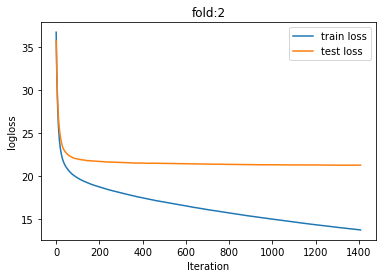

[I 2022-05-28 19:00:53,672] A new study created in memory with name: no-name-09b99482-4236-4298-ade9-7edcd7355520


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 258.675	Test's l2: 586.393


[I 2022-05-28 19:01:06,215] Trial 0 finished with value: 23.40161127268165 and parameters: {'learning_rate': 0.31481292988092924, 'num_leaves': 116, 'tree_learner': 'feature', 'reg_alpha': 7.901336877037415e-05, 'reg_lambda': 1.6786098280525182e-05, 'colsample_bytree': 0.4214274712244728, 'subsample': 0.43232371589219887, 'subsample_freq': 4, 'min_data_in_leaf': 16}. Best is trial 0 with value: 23.40161127268165.


Early stopping, best iteration is:
[23]	Train's l2: 374.163	Test's l2: 547.635
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 415.2	Test's l2: 590.759


[I 2022-05-28 19:01:08,729] Trial 1 finished with value: 24.209209458332268 and parameters: {'learning_rate': 0.7501783200513061, 'num_leaves': 11, 'tree_learner': 'feature', 'reg_alpha': 8.658555536538011e-07, 'reg_lambda': 0.00010785526820761198, 'colsample_bytree': 0.4801414560180395, 'subsample': 0.5944854915574005, 'subsample_freq': 3, 'min_data_in_leaf': 26}. Best is trial 0 with value: 23.40161127268165.


Early stopping, best iteration is:
[46]	Train's l2: 456.296	Test's l2: 586.086
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 213.519	Test's l2: 540.212


[I 2022-05-28 19:01:23,135] Trial 2 finished with value: 22.74774301997911 and parameters: {'learning_rate': 0.29477542763878584, 'num_leaves': 159, 'tree_learner': 'data', 'reg_alpha': 0.0060676296429422955, 'reg_lambda': 0.00018042208868020865, 'colsample_bytree': 0.6667295400722932, 'subsample': 0.6241621549403629, 'subsample_freq': 7, 'min_data_in_leaf': 58}. Best is trial 2 with value: 22.74774301997911.


Early stopping, best iteration is:
[22]	Train's l2: 346.88	Test's l2: 517.46
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 343.198	Test's l2: 498.873
[200]	Train's l2: 294.807	Test's l2: 494.559
[300]	Train's l2: 260.738	Test's l2: 493.653
[400]	Train's l2: 234.083	Test's l2: 493.773
[500]	Train's l2: 212.907	Test's l2: 493.51
Early stopping, best iteration is:
[444]	Train's l2: 224.358	Test's l2: 492.541


[I 2022-05-28 19:01:50,060] Trial 3 finished with value: 22.193265589499237 and parameters: {'learning_rate': 0.11785685206760865, 'num_leaves': 58, 'tree_learner': 'voting', 'reg_alpha': 1.6452296771016155, 'reg_lambda': 7.716908882645823e-05, 'colsample_bytree': 0.6073008934091322, 'subsample': 0.8584752029115876, 'subsample_freq': 5, 'min_data_in_leaf': 17}. Best is trial 3 with value: 22.193265589499237.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 391.429	Test's l2: 526.86
[200]	Train's l2: 354.345	Test's l2: 524.262


[I 2022-05-28 19:01:54,833] Trial 4 finished with value: 22.872274711478266 and parameters: {'learning_rate': 0.3152915316964072, 'num_leaves': 16, 'tree_learner': 'voting', 'reg_alpha': 6.89341161933629e-08, 'reg_lambda': 0.018972864114640407, 'colsample_bytree': 0.6776916981383151, 'subsample': 0.49243730723465395, 'subsample_freq': 6, 'min_data_in_leaf': 48}. Best is trial 3 with value: 22.193265589499237.


Early stopping, best iteration is:
[150]	Train's l2: 369.64	Test's l2: 523.141
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 244.53	Test's l2: 499.993
Early stopping, best iteration is:
[80]	Train's l2: 264.574	Test's l2: 497.962


[I 2022-05-28 19:02:14,897] Trial 5 finished with value: 22.31506832715905 and parameters: {'learning_rate': 0.17807215010742666, 'num_leaves': 162, 'tree_learner': 'data', 'reg_alpha': 0.674307893154383, 'reg_lambda': 4.0031811650209167e-07, 'colsample_bytree': 0.6261547635395059, 'subsample': 0.8341077023531888, 'subsample_freq': 5, 'min_data_in_leaf': 87}. Best is trial 3 with value: 22.193265589499237.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 126.938	Test's l2: 668.35


[I 2022-05-28 19:02:26,549] Trial 6 finished with value: 23.927486463706245 and parameters: {'learning_rate': 0.6084368503883297, 'num_leaves': 178, 'tree_learner': 'data', 'reg_alpha': 2.7850839100427465e-06, 'reg_lambda': 4.515683949363717, 'colsample_bytree': 0.8177693815370334, 'subsample': 0.8410039880890965, 'subsample_freq': 1, 'min_data_in_leaf': 11}. Best is trial 3 with value: 22.193265589499237.


Early stopping, best iteration is:
[4]	Train's l2: 429.841	Test's l2: 572.525
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 131.705	Test's l2: 678.058


[I 2022-05-28 19:02:39,799] Trial 7 finished with value: 24.030154254177777 and parameters: {'learning_rate': 0.6769693659733335, 'num_leaves': 170, 'tree_learner': 'feature', 'reg_alpha': 1.0122821762235874e-06, 'reg_lambda': 2.0083956742525486, 'colsample_bytree': 0.6940102509089037, 'subsample': 0.9160090287491609, 'subsample_freq': 5, 'min_data_in_leaf': 16}. Best is trial 3 with value: 22.193265589499237.


Early stopping, best iteration is:
[5]	Train's l2: 419.722	Test's l2: 577.448
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 193.867	Test's l2: 745.141


[I 2022-05-28 19:02:48,243] Trial 8 finished with value: 24.487864631017477 and parameters: {'learning_rate': 0.7514107431725835, 'num_leaves': 111, 'tree_learner': 'serial', 'reg_alpha': 1.5220424669435332e-07, 'reg_lambda': 0.20484956186697534, 'colsample_bytree': 0.6853879831796083, 'subsample': 0.8188624163647675, 'subsample_freq': 1, 'min_data_in_leaf': 20}. Best is trial 3 with value: 22.193265589499237.


Early stopping, best iteration is:
[6]	Train's l2: 443.941	Test's l2: 599.656
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 160.147	Test's l2: 724.636


[I 2022-05-28 19:02:58,514] Trial 9 finished with value: 24.095106851597937 and parameters: {'learning_rate': 0.7185472410730446, 'num_leaves': 153, 'tree_learner': 'serial', 'reg_alpha': 6.721057035970276e-06, 'reg_lambda': 2.0031515844468752e-05, 'colsample_bytree': 0.6274918915060883, 'subsample': 0.8468356576331246, 'subsample_freq': 3, 'min_data_in_leaf': 44}. Best is trial 3 with value: 22.193265589499237.


Early stopping, best iteration is:
[8]	Train's l2: 403.873	Test's l2: 580.574
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 76.9393	Test's l2: 896.906


[I 2022-05-28 19:03:14,688] Trial 10 finished with value: 24.873728101337598 and parameters: {'learning_rate': 0.9906642928898919, 'num_leaves': 253, 'tree_learner': 'voting', 'reg_alpha': 5.823859125888119, 'reg_lambda': 2.3177795639920694e-08, 'colsample_bytree': 0.8717581346137269, 'subsample': 0.9978749870711817, 'subsample_freq': 7, 'min_data_in_leaf': 75}. Best is trial 3 with value: 22.193265589499237.


Early stopping, best iteration is:
[3]	Train's l2: 444.921	Test's l2: 618.702
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 331.066	Test's l2: 495.583
[200]	Train's l2: 282.41	Test's l2: 491.575
Early stopping, best iteration is:
[196]	Train's l2: 284.137	Test's l2: 490.655


[I 2022-05-28 19:03:31,786] Trial 11 finished with value: 22.150724104958805 and parameters: {'learning_rate': 0.13270744710818821, 'num_leaves': 72, 'tree_learner': 'voting', 'reg_alpha': 2.754207787179858, 'reg_lambda': 7.005282917979705e-08, 'colsample_bytree': 0.5471752661055356, 'subsample': 0.743619756567941, 'subsample_freq': 5, 'min_data_in_leaf': 99}. Best is trial 11 with value: 22.150724104958805.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 343.468	Test's l2: 499.343
[200]	Train's l2: 297.322	Test's l2: 497.358


[I 2022-05-28 19:03:45,673] Trial 12 finished with value: 22.27526994623811 and parameters: {'learning_rate': 0.1338376114387253, 'num_leaves': 60, 'tree_learner': 'voting', 'reg_alpha': 0.060153171134556725, 'reg_lambda': 4.4824779989013434e-07, 'colsample_bytree': 0.521497993650589, 'subsample': 0.6996294238589075, 'subsample_freq': 5, 'min_data_in_leaf': 100}. Best is trial 11 with value: 22.150724104958805.


Early stopping, best iteration is:
[151]	Train's l2: 317.309	Test's l2: 496.188
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 261.307	Test's l2: 572.027


[I 2022-05-28 19:03:52,248] Trial 13 finished with value: 23.266947252777335 and parameters: {'learning_rate': 0.4413002923674173, 'num_leaves': 73, 'tree_learner': 'voting', 'reg_alpha': 7.701176282888316, 'reg_lambda': 0.003303159238728038, 'colsample_bytree': 0.9985097135595711, 'subsample': 0.7113889133919865, 'subsample_freq': 4, 'min_data_in_leaf': 65}. Best is trial 11 with value: 22.150724104958805.


Early stopping, best iteration is:
[18]	Train's l2: 386.401	Test's l2: 541.351
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 349.515	Test's l2: 495.021
[200]	Train's l2: 303.714	Test's l2: 491.194
[300]	Train's l2: 271.632	Test's l2: 488.837
[400]	Train's l2: 247.191	Test's l2: 489.388
Early stopping, best iteration is:
[312]	Train's l2: 268.447	Test's l2: 488.72


[I 2022-05-28 19:04:13,955] Trial 14 finished with value: 22.107018489637632 and parameters: {'learning_rate': 0.10948360260088792, 'num_leaves': 59, 'tree_learner': 'voting', 'reg_alpha': 0.004469111254961012, 'reg_lambda': 1.696714528816224e-08, 'colsample_bytree': 0.5533926453915718, 'subsample': 0.6850150522326239, 'subsample_freq': 6, 'min_data_in_leaf': 33}. Best is trial 14 with value: 22.107018489637632.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 259.031	Test's l2: 582.056


[I 2022-05-28 19:04:21,663] Trial 15 finished with value: 23.424462187639023 and parameters: {'learning_rate': 0.4309775999331245, 'num_leaves': 79, 'tree_learner': 'voting', 'reg_alpha': 0.0016940409433550217, 'reg_lambda': 1.3131578731095605e-08, 'colsample_bytree': 0.5368770051031292, 'subsample': 0.722006111428466, 'subsample_freq': 6, 'min_data_in_leaf': 36}. Best is trial 14 with value: 22.107018489637632.


Early stopping, best iteration is:
[26]	Train's l2: 366.369	Test's l2: 548.705
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 354.824	Test's l2: 507.113
[200]	Train's l2: 311.321	Test's l2: 508.929


[I 2022-05-28 19:04:29,046] Trial 16 finished with value: 22.452144691399024 and parameters: {'learning_rate': 0.2260823807397036, 'num_leaves': 35, 'tree_learner': 'voting', 'reg_alpha': 0.04872040226428471, 'reg_lambda': 3.942739026113239e-07, 'colsample_bytree': 0.40424360567728035, 'subsample': 0.6077514582170473, 'subsample_freq': 6, 'min_data_in_leaf': 35}. Best is trial 14 with value: 22.107018489637632.


Early stopping, best iteration is:
[157]	Train's l2: 328.177	Test's l2: 504.099
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 255.645	Test's l2: 582.928


[I 2022-05-28 19:04:36,149] Trial 17 finished with value: 23.06679476144001 and parameters: {'learning_rate': 0.4506955349670894, 'num_leaves': 93, 'tree_learner': 'voting', 'reg_alpha': 4.5674608160255306e-05, 'reg_lambda': 2.4892242569338256e-06, 'colsample_bytree': 0.7844774355006733, 'subsample': 0.5470878788652533, 'subsample_freq': 3, 'min_data_in_leaf': 77}. Best is trial 14 with value: 22.107018489637632.


Early stopping, best iteration is:
[12]	Train's l2: 405.846	Test's l2: 532.077
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 340.973	Test's l2: 516.223


[I 2022-05-28 19:04:41,894] Trial 18 finished with value: 22.715356672512954 and parameters: {'learning_rate': 0.23416412960151983, 'num_leaves': 42, 'tree_learner': 'serial', 'reg_alpha': 0.16938861023158752, 'reg_lambda': 5.2994147778153e-08, 'colsample_bytree': 0.5651197203983982, 'subsample': 0.7575424442801262, 'subsample_freq': 7, 'min_data_in_leaf': 97}. Best is trial 14 with value: 22.107018489637632.


Early stopping, best iteration is:
[53]	Train's l2: 378.066	Test's l2: 515.987
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 161.61	Test's l2: 674.834


[I 2022-05-28 19:04:55,382] Trial 19 finished with value: 24.084267345929636 and parameters: {'learning_rate': 0.5164557790942222, 'num_leaves': 218, 'tree_learner': 'voting', 'reg_alpha': 0.0017094889108071934, 'reg_lambda': 2.8792927097216312e-06, 'colsample_bytree': 0.4602550637548809, 'subsample': 0.661081956472291, 'subsample_freq': 6, 'min_data_in_leaf': 62}. Best is trial 14 with value: 22.107018489637632.


Early stopping, best iteration is:
[11]	Train's l2: 380.42	Test's l2: 580.052
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 211.022	Test's l2: 869.854


[I 2022-05-28 19:05:03,203] Trial 20 finished with value: 24.799591648120035 and parameters: {'learning_rate': 0.9139801583948466, 'num_leaves': 98, 'tree_learner': 'voting', 'reg_alpha': 0.011486742526515246, 'reg_lambda': 1.006050709023877e-07, 'colsample_bytree': 0.7569619183093367, 'subsample': 0.788570003290722, 'subsample_freq': 2, 'min_data_in_leaf': 5}. Best is trial 14 with value: 22.107018489637632.


Early stopping, best iteration is:
[5]	Train's l2: 457.512	Test's l2: 615.02
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 352.954	Test's l2: 490.508
[200]	Train's l2: 306.788	Test's l2: 485.752
[300]	Train's l2: 275.263	Test's l2: 484.108
[400]	Train's l2: 250.477	Test's l2: 484.076
Early stopping, best iteration is:
[335]	Train's l2: 265.901	Test's l2: 483.523


[I 2022-05-28 19:05:23,802] Trial 21 finished with value: 21.989152505754156 and parameters: {'learning_rate': 0.11631983164198303, 'num_leaves': 52, 'tree_learner': 'voting', 'reg_alpha': 0.9125468693948571, 'reg_lambda': 0.0021873040348816108, 'colsample_bytree': 0.5921631134404954, 'subsample': 0.9097473698727423, 'subsample_freq': 5, 'min_data_in_leaf': 28}. Best is trial 21 with value: 21.989152505754156.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 381.398	Test's l2: 502.763
[200]	Train's l2: 342.353	Test's l2: 494.238
[300]	Train's l2: 316.014	Test's l2: 492.574
[400]	Train's l2: 295.375	Test's l2: 492.171
[500]	Train's l2: 278.117	Test's l2: 490.105
[600]	Train's l2: 262.826	Test's l2: 489.765
[700]	Train's l2: 248.565	Test's l2: 488.802
Early stopping, best iteration is:
[674]	Train's l2: 252.243	Test's l2: 488.786


[I 2022-05-28 19:05:51,917] Trial 22 finished with value: 22.108515776346138 and parameters: {'learning_rate': 0.10426037286868826, 'num_leaves': 35, 'tree_learner': 'voting', 'reg_alpha': 0.5771885916217592, 'reg_lambda': 0.0025206607185461025, 'colsample_bytree': 0.5518391968036004, 'subsample': 0.9321388627404381, 'subsample_freq': 4, 'min_data_in_leaf': 32}. Best is trial 21 with value: 21.989152505754156.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 342.406	Test's l2: 504.258


[I 2022-05-28 19:05:58,770] Trial 23 finished with value: 22.4345679584795 and parameters: {'learning_rate': 0.2331421959730137, 'num_leaves': 36, 'tree_learner': 'voting', 'reg_alpha': 0.40146517574832064, 'reg_lambda': 0.001061232884805472, 'colsample_bytree': 0.5845920780381064, 'subsample': 0.9836806160536059, 'subsample_freq': 4, 'min_data_in_leaf': 31}. Best is trial 21 with value: 21.989152505754156.


Early stopping, best iteration is:
[85]	Train's l2: 351.929	Test's l2: 503.31
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 501.26	Test's l2: 554.218
[200]	Train's l2: 465.416	Test's l2: 539.234
[300]	Train's l2: 444.841	Test's l2: 530.421
[400]	Train's l2: 429.935	Test's l2: 521.705
[500]	Train's l2: 419.294	Test's l2: 516.87
[600]	Train's l2: 410.1	Test's l2: 513.78
[700]	Train's l2: 402.896	Test's l2: 510.141
[800]	Train's l2: 396.321	Test's l2: 506.711
[900]	Train's l2: 390.667	Test's l2: 505.037
[1000]	Train's l2: 385.586	Test's l2: 503.534
[1100]	Train's l2: 381.023	Test's l2: 501.233
[1200]	Train's l2: 376.582	Test's l2: 500.552
[1300]	Train's l2: 372.54	Test's l2: 499.537
[1400]	Train's l2: 368.784	Test's l2: 499.163
[1500]	Train's l2: 365.358	Test's l2: 498.416
[1

[I 2022-05-28 19:06:25,941] Trial 24 finished with value: 22.25339369568267 and parameters: {'learning_rate': 0.11601875713989246, 'num_leaves': 5, 'tree_learner': 'voting', 'reg_alpha': 0.027390911519116542, 'reg_lambda': 0.015034174164326064, 'colsample_bytree': 0.4889580796675125, 'subsample': 0.9057036914051457, 'subsample_freq': 4, 'min_data_in_leaf': 42}. Best is trial 21 with value: 21.989152505754156.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 196.27	Test's l2: 550.93


[I 2022-05-28 19:06:38,480] Trial 25 finished with value: 23.026895871506884 and parameters: {'learning_rate': 0.36632223841105965, 'num_leaves': 138, 'tree_learner': 'voting', 'reg_alpha': 0.00047293408550858393, 'reg_lambda': 0.001640310622932387, 'colsample_bytree': 0.5105309557490784, 'subsample': 0.9362063107817753, 'subsample_freq': 6, 'min_data_in_leaf': 29}. Best is trial 21 with value: 21.989152505754156.


Early stopping, best iteration is:
[21]	Train's l2: 343.069	Test's l2: 530.238
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 328.618	Test's l2: 503.013
[200]	Train's l2: 277.956	Test's l2: 504.066


[I 2022-05-28 19:06:48,192] Trial 26 finished with value: 22.391475429969553 and parameters: {'learning_rate': 0.2079087231396551, 'num_leaves': 47, 'tree_learner': 'serial', 'reg_alpha': 0.22150379072670293, 'reg_lambda': 0.10279617628485928, 'colsample_bytree': 0.7377594942558714, 'subsample': 0.9482528218526107, 'subsample_freq': 3, 'min_data_in_leaf': 54}. Best is trial 21 with value: 21.989152505754156.


Early stopping, best iteration is:
[122]	Train's l2: 315.249	Test's l2: 501.378
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 359.952	Test's l2: 504.407
[200]	Train's l2: 314.394	Test's l2: 500.711
[300]	Train's l2: 280.192	Test's l2: 500.899


[I 2022-05-28 19:06:56,626] Trial 27 finished with value: 22.33511591428712 and parameters: {'learning_rate': 0.28667247456821265, 'num_leaves': 25, 'tree_learner': 'data', 'reg_alpha': 0.004725629340304292, 'reg_lambda': 0.00813772869253482, 'colsample_bytree': 0.6406205052949074, 'subsample': 0.8864114375234314, 'subsample_freq': 5, 'min_data_in_leaf': 24}. Best is trial 21 with value: 21.989152505754156.


Early stopping, best iteration is:
[231]	Train's l2: 302.632	Test's l2: 498.857
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 329.755	Test's l2: 496.893
[200]	Train's l2: 278.096	Test's l2: 492.983
[300]	Train's l2: 243.043	Test's l2: 491.608
[400]	Train's l2: 215.684	Test's l2: 491.834
Early stopping, best iteration is:
[337]	Train's l2: 232.212	Test's l2: 490.952


[I 2022-05-28 19:07:23,227] Trial 28 finished with value: 22.157441353980825 and parameters: {'learning_rate': 0.10142070025086453, 'num_leaves': 89, 'tree_learner': 'feature', 'reg_alpha': 0.9163003450515904, 'reg_lambda': 0.13951484979398981, 'colsample_bytree': 0.44697187807179506, 'subsample': 0.7910246724340861, 'subsample_freq': 4, 'min_data_in_leaf': 38}. Best is trial 21 with value: 21.989152505754156.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 252.829	Test's l2: 594.568


[I 2022-05-28 19:07:32,984] Trial 29 finished with value: 23.430601130609322 and parameters: {'learning_rate': 0.36372341421990617, 'num_leaves': 116, 'tree_learner': 'feature', 'reg_alpha': 8.54517071592846e-05, 'reg_lambda': 0.000494150614998717, 'colsample_bytree': 0.5732896330690316, 'subsample': 0.4623244946807753, 'subsample_freq': 2, 'min_data_in_leaf': 49}. Best is trial 21 with value: 21.989152505754156.


Early stopping, best iteration is:
[20]	Train's l2: 375.966	Test's l2: 548.993
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 330.842	Test's l2: 519.497


[I 2022-05-28 19:07:40,551] Trial 30 finished with value: 22.733516756882423 and parameters: {'learning_rate': 0.17511982681522642, 'num_leaves': 61, 'tree_learner': 'voting', 'reg_alpha': 0.13729725215874988, 'reg_lambda': 2.4698694052306065e-05, 'colsample_bytree': 0.4251530337571732, 'subsample': 0.4065200508706758, 'subsample_freq': 6, 'min_data_in_leaf': 9}. Best is trial 21 with value: 21.989152505754156.


Early stopping, best iteration is:
[74]	Train's l2: 351.038	Test's l2: 516.813
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 321.377	Test's l2: 504.395
[200]	Train's l2: 268.346	Test's l2: 507.028


[I 2022-05-28 19:07:55,361] Trial 31 finished with value: 22.436553549456903 and parameters: {'learning_rate': 0.14481182762388706, 'num_leaves': 73, 'tree_learner': 'voting', 'reg_alpha': 2.5599859714309114, 'reg_lambda': 3.649452232879053e-06, 'colsample_bytree': 0.5397946498929422, 'subsample': 0.6683524833600761, 'subsample_freq': 5, 'min_data_in_leaf': 31}. Best is trial 21 with value: 21.989152505754156.


Early stopping, best iteration is:
[138]	Train's l2: 297.631	Test's l2: 503.399
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 372.482	Test's l2: 520.632
[200]	Train's l2: 332.107	Test's l2: 513.62
[300]	Train's l2: 303.396	Test's l2: 517.549


[I 2022-05-28 19:08:04,332] Trial 32 finished with value: 22.644461826764413 and parameters: {'learning_rate': 0.17932161412398456, 'num_leaves': 27, 'tree_learner': 'voting', 'reg_alpha': 9.677788019671926, 'reg_lambda': 1.7841856737003867e-07, 'colsample_bytree': 0.5670770856697175, 'subsample': 0.7536982243345991, 'subsample_freq': 5, 'min_data_in_leaf': 24}. Best is trial 21 with value: 21.989152505754156.


Early stopping, best iteration is:
[235]	Train's l2: 321.175	Test's l2: 512.772
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 316.684	Test's l2: 534.557


[I 2022-05-28 19:08:10,400] Trial 33 finished with value: 22.963250039986338 and parameters: {'learning_rate': 0.2796097860993646, 'num_leaves': 56, 'tree_learner': 'voting', 'reg_alpha': 1.9407601776219932, 'reg_lambda': 0.0003071095529847711, 'colsample_bytree': 0.4768552279662687, 'subsample': 0.5513640539560893, 'subsample_freq': 4, 'min_data_in_leaf': 42}. Best is trial 21 with value: 21.989152505754156.


Early stopping, best iteration is:
[45]	Train's l2: 367.806	Test's l2: 527.311
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 589.398	Test's l2: 612.679
[200]	Train's l2: 559.081	Test's l2: 595.369
[300]	Train's l2: 544.952	Test's l2: 587.04
[400]	Train's l2: 536.46	Test's l2: 583.22
[500]	Train's l2: 530.659	Test's l2: 579.661
[600]	Train's l2: 526.299	Test's l2: 577.36
[700]	Train's l2: 522.804	Test's l2: 577.378
[800]	Train's l2: 519.966	Test's l2: 575.262
[900]	Train's l2: 517.532	Test's l2: 573.727
[1000]	Train's l2: 515.397	Test's l2: 572.902
[1100]	Train's l2: 513.42	Test's l2: 572.53
[1200]	Train's l2: 511.649	Test's l2: 572.208
[1300]	Train's l2: 510.084	Test's l2: 571.476
[1400]	Train's l2: 508.599	Test's l2: 571.53
[1500]	Train's l2: 507.26	Test's l2: 571.185
Ear

[I 2022-05-28 19:08:26,439] Trial 34 finished with value: 23.889139284275704 and parameters: {'learning_rate': 0.3427292398829812, 'num_leaves': 2, 'tree_learner': 'voting', 'reg_alpha': 0.02860609139771285, 'reg_lambda': 0.030281622311822392, 'colsample_bytree': 0.5991774930878448, 'subsample': 0.9645815646520556, 'subsample_freq': 4, 'min_data_in_leaf': 76}. Best is trial 21 with value: 21.989152505754156.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 406.583	Test's l2: 505.193
[200]	Train's l2: 368.992	Test's l2: 494.35
[300]	Train's l2: 345.603	Test's l2: 491.034
[400]	Train's l2: 327.93	Test's l2: 488.956
[500]	Train's l2: 312.928	Test's l2: 487.651
[600]	Train's l2: 299.719	Test's l2: 486.604
[700]	Train's l2: 287.869	Test's l2: 485.563
[800]	Train's l2: 276.678	Test's l2: 483.981
[900]	Train's l2: 266.849	Test's l2: 483.44
[1000]	Train's l2: 257.74	Test's l2: 483.351
[1100]	Train's l2: 249.244	Test's l2: 483.149
Early stopping, best iteration is:
[1049]	Train's l2: 253.364	Test's l2: 482.873


[I 2022-05-28 19:08:55,971] Trial 35 finished with value: 21.974361201981708 and parameters: {'learning_rate': 0.10018967322040874, 'num_leaves': 23, 'tree_learner': 'feature', 'reg_alpha': 0.6392990638798924, 'reg_lambda': 4.453612003896807e-05, 'colsample_bytree': 0.6516036137196516, 'subsample': 0.8783907491778898, 'subsample_freq': 7, 'min_data_in_leaf': 23}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 383.869	Test's l2: 498.122
[200]	Train's l2: 344.12	Test's l2: 494.127


[I 2022-05-28 19:09:01,401] Trial 36 finished with value: 22.210353679927668 and parameters: {'learning_rate': 0.2557325831200674, 'num_leaves': 18, 'tree_learner': 'feature', 'reg_alpha': 1.2635768446132424e-08, 'reg_lambda': 7.597429203091588e-05, 'colsample_bytree': 0.6208896986694624, 'subsample': 0.8756675752875333, 'subsample_freq': 7, 'min_data_in_leaf': 21}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[157]	Train's l2: 358.721	Test's l2: 493.3
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 322.252	Test's l2: 505.047


[I 2022-05-28 19:09:09,826] Trial 37 finished with value: 22.466738641049194 and parameters: {'learning_rate': 0.20099649109866985, 'num_leaves': 50, 'tree_learner': 'feature', 'reg_alpha': 0.4090527318563426, 'reg_lambda': 0.004098241009272943, 'colsample_bytree': 0.6572888181531353, 'subsample': 0.9136383110988588, 'subsample_freq': 7, 'min_data_in_leaf': 14}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[95]	Train's l2: 325.703	Test's l2: 504.754
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 429.145	Test's l2: 514.032
[200]	Train's l2: 392.619	Test's l2: 497.748
[300]	Train's l2: 371.883	Test's l2: 492.175
[400]	Train's l2: 355.553	Test's l2: 489.361
[500]	Train's l2: 342.348	Test's l2: 487.529
[600]	Train's l2: 331.113	Test's l2: 485.769
[700]	Train's l2: 321.319	Test's l2: 484.415
[800]	Train's l2: 312.014	Test's l2: 483.731
[900]	Train's l2: 303.512	Test's l2: 483.822
Early stopping, best iteration is:
[814]	Train's l2: 310.649	Test's l2: 483.446


[I 2022-05-28 19:09:28,006] Trial 38 finished with value: 21.98740875733766 and parameters: {'learning_rate': 0.10458153184225796, 'num_leaves': 15, 'tree_learner': 'feature', 'reg_alpha': 0.008204052125796196, 'reg_lambda': 0.9246478549841336, 'colsample_bytree': 0.7277342715043642, 'subsample': 0.8051112751626389, 'subsample_freq': 6, 'min_data_in_leaf': 28}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 392.819	Test's l2: 503.647
[200]	Train's l2: 355.55	Test's l2: 496.937
[300]	Train's l2: 330.674	Test's l2: 494.009
[400]	Train's l2: 311.251	Test's l2: 493.92
[500]	Train's l2: 295.188	Test's l2: 492.973
[600]	Train's l2: 280.465	Test's l2: 491.69
[700]	Train's l2: 267.144	Test's l2: 492.565
Early stopping, best iteration is:
[617]	Train's l2: 278.059	Test's l2: 491.167


[I 2022-05-28 19:09:43,639] Trial 39 finished with value: 22.16229242049898 and parameters: {'learning_rate': 0.17046320110543003, 'num_leaves': 19, 'tree_learner': 'feature', 'reg_alpha': 0.0005667963921931421, 'reg_lambda': 1.0519625420554697, 'colsample_bytree': 0.7231090396070319, 'subsample': 0.8134894504580549, 'subsample_freq': 6, 'min_data_in_leaf': 26}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 507.434	Test's l2: 561.742
[200]	Train's l2: 471.62	Test's l2: 542.964
[300]	Train's l2: 451.956	Test's l2: 535.295
[400]	Train's l2: 438.877	Test's l2: 529.415
[500]	Train's l2: 428.996	Test's l2: 524.453
[600]	Train's l2: 421.049	Test's l2: 521.196
[700]	Train's l2: 414.18	Test's l2: 518.484
[800]	Train's l2: 408.575	Test's l2: 517.173
[900]	Train's l2: 403.61	Test's l2: 514.533
[1000]	Train's l2: 399.191	Test's l2: 513.009
[1100]	Train's l2: 395.072	Test's l2: 512.07
[1200]	Train's l2: 391.244	Test's l2: 509.912
[1300]	Train's l2: 387.754	Test's l2: 507.494
[1400]	Train's l2: 384.407	Test's l2: 507.097
Early stopping, best iteration is:
[1316]	Train's l2: 387.121	Test's l2: 506.617


[I 2022-05-28 19:10:00,208] Trial 40 finished with value: 22.50815666968331 and parameters: {'learning_rate': 0.3204330643206148, 'num_leaves': 3, 'tree_learner': 'feature', 'reg_alpha': 0.007390144024326577, 'reg_lambda': 0.8396432394342448, 'colsample_bytree': 0.8208642243328796, 'subsample': 0.8750562815806644, 'subsample_freq': 7, 'min_data_in_leaf': 20}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 363.901	Test's l2: 503.534
[200]	Train's l2: 322.688	Test's l2: 496.647
[300]	Train's l2: 293.475	Test's l2: 495.568
[400]	Train's l2: 270.588	Test's l2: 494.307
[500]	Train's l2: 250.409	Test's l2: 494.813
Early stopping, best iteration is:
[426]	Train's l2: 264.644	Test's l2: 493.936


[I 2022-05-28 19:10:18,925] Trial 41 finished with value: 22.224663257094797 and parameters: {'learning_rate': 0.1589467543564207, 'num_leaves': 34, 'tree_learner': 'feature', 'reg_alpha': 0.10286526243042862, 'reg_lambda': 6.943241400178842, 'colsample_bytree': 0.6587701831896584, 'subsample': 0.9548595275014509, 'subsample_freq': 6, 'min_data_in_leaf': 32}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 437.456	Test's l2: 523.499
[200]	Train's l2: 399.096	Test's l2: 507.372
[300]	Train's l2: 378.521	Test's l2: 500.609
[400]	Train's l2: 362.928	Test's l2: 497.683
[500]	Train's l2: 350.254	Test's l2: 493.029
[600]	Train's l2: 339.614	Test's l2: 490.931
[700]	Train's l2: 330.188	Test's l2: 489.915
[800]	Train's l2: 321.713	Test's l2: 488.867
[900]	Train's l2: 313.511	Test's l2: 488.951
Early stopping, best iteration is:
[812]	Train's l2: 320.749	Test's l2: 488.54


[I 2022-05-28 19:10:39,020] Trial 42 finished with value: 22.102934986847355 and parameters: {'learning_rate': 0.10096175062865523, 'num_leaves': 14, 'tree_learner': 'data', 'reg_alpha': 0.715662208071524, 'reg_lambda': 0.04067466423906609, 'colsample_bytree': 0.6976494480932999, 'subsample': 0.795988717063988, 'subsample_freq': 7, 'min_data_in_leaf': 38}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 424.849	Test's l2: 515.176
[200]	Train's l2: 387.875	Test's l2: 497.181
[300]	Train's l2: 367.199	Test's l2: 495.194
[400]	Train's l2: 351.382	Test's l2: 493.019
[500]	Train's l2: 338.549	Test's l2: 490.87
[600]	Train's l2: 326.891	Test's l2: 490.811
Early stopping, best iteration is:
[553]	Train's l2: 332.219	Test's l2: 490.183


[I 2022-05-28 19:10:54,561] Trial 43 finished with value: 22.140073849339306 and parameters: {'learning_rate': 0.10698154436239639, 'num_leaves': 16, 'tree_learner': 'data', 'reg_alpha': 0.01684145914180133, 'reg_lambda': 0.3445249714948822, 'colsample_bytree': 0.7169785739044511, 'subsample': 0.8017057725842527, 'subsample_freq': 7, 'min_data_in_leaf': 43}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 410.832	Test's l2: 508.966
[200]	Train's l2: 374.402	Test's l2: 503.719
[300]	Train's l2: 352.633	Test's l2: 500.829
[400]	Train's l2: 335.42	Test's l2: 497.423
[500]	Train's l2: 320.41	Test's l2: 498.307
Early stopping, best iteration is:
[415]	Train's l2: 333.001	Test's l2: 496.936


[I 2022-05-28 19:11:05,360] Trial 44 finished with value: 22.292063567178698 and parameters: {'learning_rate': 0.16035063207448513, 'num_leaves': 15, 'tree_learner': 'data', 'reg_alpha': 0.003708897442538795, 'reg_lambda': 0.0741953197809132, 'colsample_bytree': 0.6898398573195551, 'subsample': 0.8449491540245854, 'subsample_freq': 7, 'min_data_in_leaf': 37}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 363.124	Test's l2: 516.703
[200]	Train's l2: 320.321	Test's l2: 518.931


[I 2022-05-28 19:11:11,954] Trial 45 finished with value: 22.67352842946454 and parameters: {'learning_rate': 0.2579092301405831, 'num_leaves': 27, 'tree_learner': 'data', 'reg_alpha': 8.437775646261329e-05, 'reg_lambda': 0.047833104914928086, 'colsample_bytree': 0.6082412667121091, 'subsample': 0.6573115051012769, 'subsample_freq': 6, 'min_data_in_leaf': 49}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[149]	Train's l2: 339.766	Test's l2: 514.089
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 307.011	Test's l2: 508.106
[200]	Train's l2: 250.019	Test's l2: 516.122
Early stopping, best iteration is:
[105]	Train's l2: 303.184	Test's l2: 508.032


[I 2022-05-28 19:11:23,190] Trial 46 finished with value: 22.53956508006332 and parameters: {'learning_rate': 0.19672866480958934, 'num_leaves': 62, 'tree_learner': 'data', 'reg_alpha': 1.6549168828347698, 'reg_lambda': 0.45311487807901696, 'colsample_bytree': 0.7832379937070453, 'subsample': 0.7736378868916594, 'subsample_freq': 7, 'min_data_in_leaf': 16}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 303.769	Test's l2: 676.099


[I 2022-05-28 19:11:27,516] Trial 47 finished with value: 23.914150936885278 and parameters: {'learning_rate': 0.8060423578823802, 'num_leaves': 46, 'tree_learner': 'feature', 'reg_alpha': 0.001764118254150219, 'reg_lambda': 1.9667992797528597, 'colsample_bytree': 0.8838078326036961, 'subsample': 0.6939498174705208, 'subsample_freq': 6, 'min_data_in_leaf': 27}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[11]	Train's l2: 448.641	Test's l2: 571.887
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 231.451	Test's l2: 496.439
Early stopping, best iteration is:
[97]	Train's l2: 234.482	Test's l2: 495.88


[I 2022-05-28 19:11:50,964] Trial 48 finished with value: 22.26837443885927 and parameters: {'learning_rate': 0.13850071710729994, 'num_leaves': 194, 'tree_learner': 'feature', 'reg_alpha': 1.9423800589898483e-05, 'reg_lambda': 0.01809593643809854, 'colsample_bytree': 0.6770346101768472, 'subsample': 0.8221101684554942, 'subsample_freq': 7, 'min_data_in_leaf': 21}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 238.717	Test's l2: 631.875


[I 2022-05-28 19:11:58,223] Trial 49 finished with value: 23.60103901273344 and parameters: {'learning_rate': 0.6171868374022371, 'num_leaves': 85, 'tree_learner': 'data', 'reg_alpha': 0.061981384370572226, 'reg_lambda': 5.8301931776500754e-05, 'colsample_bytree': 0.7504128140614041, 'subsample': 0.7270277864119101, 'subsample_freq': 6, 'min_data_in_leaf': 39}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[13]	Train's l2: 395.87	Test's l2: 557.009
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 212.106	Test's l2: 554.882


[I 2022-05-28 19:12:08,459] Trial 50 finished with value: 22.99008513854788 and parameters: {'learning_rate': 0.39431398033443466, 'num_leaves': 105, 'tree_learner': 'serial', 'reg_alpha': 1.0231661216857069, 'reg_lambda': 0.006462884719667415, 'colsample_bytree': 0.7092312610471105, 'subsample': 0.8542693498546355, 'subsample_freq': 5, 'min_data_in_leaf': 11}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[20]	Train's l2: 355.521	Test's l2: 528.544
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 375.371	Test's l2: 498.47
[200]	Train's l2: 334.698	Test's l2: 489.738
[300]	Train's l2: 307.062	Test's l2: 488.209
Early stopping, best iteration is:
[280]	Train's l2: 312.049	Test's l2: 487.804


[I 2022-05-28 19:12:22,482] Trial 51 finished with value: 22.086296521771512 and parameters: {'learning_rate': 0.11304366478831569, 'num_leaves': 36, 'tree_learner': 'feature', 'reg_alpha': 0.30245755974673744, 'reg_lambda': 0.0023710651678637657, 'colsample_bytree': 0.6498292597824897, 'subsample': 0.8974074882210712, 'subsample_freq': 5, 'min_data_in_leaf': 34}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 464.278	Test's l2: 535.399
[200]	Train's l2: 426.565	Test's l2: 516.744
[300]	Train's l2: 406.164	Test's l2: 505.081
[400]	Train's l2: 392.393	Test's l2: 502.412
[500]	Train's l2: 380.924	Test's l2: 499.947
[600]	Train's l2: 371.604	Test's l2: 497.074
[700]	Train's l2: 363.396	Test's l2: 494.89
[800]	Train's l2: 355.504	Test's l2: 492.722
[900]	Train's l2: 348.858	Test's l2: 491.226
[1000]	Train's l2: 342.756	Test's l2: 490.931
[1100]	Train's l2: 337.113	Test's l2: 489.132
[1200]	Train's l2: 331.946	Test's l2: 488.538
Early stopping, best iteration is:
[1187]	Train's l2: 332.598	Test's l2: 488.266


[I 2022-05-28 19:12:43,464] Trial 52 finished with value: 22.096748756648562 and parameters: {'learning_rate': 0.10171679600590375, 'num_leaves': 9, 'tree_learner': 'feature', 'reg_alpha': 3.37166321974704, 'reg_lambda': 0.000597520978665638, 'colsample_bytree': 0.6428592216074771, 'subsample': 0.8688594204151736, 'subsample_freq': 5, 'min_data_in_leaf': 46}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 429.069	Test's l2: 517.379
[200]	Train's l2: 393.096	Test's l2: 505.73
[300]	Train's l2: 373.251	Test's l2: 500.21
[400]	Train's l2: 358.007	Test's l2: 499.776
[500]	Train's l2: 345.071	Test's l2: 497.339
[600]	Train's l2: 333.568	Test's l2: 495.063
[700]	Train's l2: 323.525	Test's l2: 493.847
[800]	Train's l2: 314.495	Test's l2: 493.958
Early stopping, best iteration is:
[735]	Train's l2: 320.325	Test's l2: 493.236


[I 2022-05-28 19:13:00,622] Trial 53 finished with value: 22.208923798685532 and parameters: {'learning_rate': 0.14605492908799605, 'num_leaves': 12, 'tree_learner': 'feature', 'reg_alpha': 4.072494169826921, 'reg_lambda': 0.0006954111498226694, 'colsample_bytree': 0.6392591858742042, 'subsample': 0.8909061050357113, 'subsample_freq': 5, 'min_data_in_leaf': 54}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 366.517	Test's l2: 497.855
[200]	Train's l2: 323.026	Test's l2: 490.425
[300]	Train's l2: 293.261	Test's l2: 491.789
Early stopping, best iteration is:
[206]	Train's l2: 320.863	Test's l2: 490.105


[I 2022-05-28 19:13:09,727] Trial 54 finished with value: 22.13831330298922 and parameters: {'learning_rate': 0.21261758016377047, 'num_leaves': 27, 'tree_learner': 'feature', 'reg_alpha': 0.27924394536308106, 'reg_lambda': 0.00027069158802382125, 'colsample_bytree': 0.6683120734350041, 'subsample': 0.8596325051636279, 'subsample_freq': 5, 'min_data_in_leaf': 45}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 447.788	Test's l2: 524.042
[200]	Train's l2: 412.475	Test's l2: 507.91
[300]	Train's l2: 392.515	Test's l2: 503.442
[400]	Train's l2: 378.214	Test's l2: 497.483
[500]	Train's l2: 366.439	Test's l2: 495.76
[600]	Train's l2: 356.281	Test's l2: 493.435
[700]	Train's l2: 347.774	Test's l2: 492.519
[800]	Train's l2: 340.034	Test's l2: 491.975
[900]	Train's l2: 332.437	Test's l2: 491.305
Early stopping, best iteration is:
[880]	Train's l2: 333.692	Test's l2: 490.805


[I 2022-05-28 19:13:26,736] Trial 55 finished with value: 22.15412274122972 and parameters: {'learning_rate': 0.13700559735645176, 'num_leaves': 9, 'tree_learner': 'feature', 'reg_alpha': 4.0103165057263865, 'reg_lambda': 0.00011621433160798167, 'colsample_bytree': 0.6992709871192652, 'subsample': 0.90943308611852, 'subsample_freq': 5, 'min_data_in_leaf': 47}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 381.302	Test's l2: 502.914
[200]	Train's l2: 341.229	Test's l2: 494.187
[300]	Train's l2: 314.239	Test's l2: 493.679
[400]	Train's l2: 293.841	Test's l2: 492.915
[500]	Train's l2: 275.894	Test's l2: 491.397
[600]	Train's l2: 259.777	Test's l2: 490.839
[700]	Train's l2: 246.162	Test's l2: 489.798
Early stopping, best iteration is:
[679]	Train's l2: 248.928	Test's l2: 489.664


[I 2022-05-28 19:13:54,543] Trial 56 finished with value: 22.128357959754986 and parameters: {'learning_rate': 0.10151470903478602, 'num_leaves': 37, 'tree_learner': 'feature', 'reg_alpha': 1.0573018779038015, 'reg_lambda': 1.019507147491016e-05, 'colsample_bytree': 0.5931168369573354, 'subsample': 0.8284932483445434, 'subsample_freq': 7, 'min_data_in_leaf': 39}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 363.013	Test's l2: 509.66
[200]	Train's l2: 319.411	Test's l2: 505.97
[300]	Train's l2: 288.784	Test's l2: 507.837
Early stopping, best iteration is:
[204]	Train's l2: 318.045	Test's l2: 505.945


[I 2022-05-28 19:14:02,482] Trial 57 finished with value: 22.49322283738185 and parameters: {'learning_rate': 0.25690667679620993, 'num_leaves': 26, 'tree_learner': 'feature', 'reg_alpha': 0.6061525537104568, 'reg_lambda': 0.0012341264844995044, 'colsample_bytree': 0.6445220489225966, 'subsample': 0.8608583510786021, 'subsample_freq': 5, 'min_data_in_leaf': 59}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 333.138	Test's l2: 505.572
[200]	Train's l2: 282.284	Test's l2: 502.922


[I 2022-05-28 19:14:13,684] Trial 58 finished with value: 22.389249111190846 and parameters: {'learning_rate': 0.188146929979735, 'num_leaves': 46, 'tree_learner': 'feature', 'reg_alpha': 0.08906457077493714, 'reg_lambda': 3.270969467286582e-05, 'colsample_bytree': 0.7717688867023272, 'subsample': 0.9762911975122096, 'subsample_freq': 6, 'min_data_in_leaf': 35}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[180]	Train's l2: 291.408	Test's l2: 501.278
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 208.846	Test's l2: 497.025
Early stopping, best iteration is:
[73]	Train's l2: 239.922	Test's l2: 495.377


[I 2022-05-28 19:14:41,675] Trial 59 finished with value: 22.257057749007558 and parameters: {'learning_rate': 0.13382312321973003, 'num_leaves': 254, 'tree_learner': 'feature', 'reg_alpha': 5.793854479466944, 'reg_lambda': 0.00018091547037260076, 'colsample_bytree': 0.6180080656798622, 'subsample': 0.9237928355336757, 'subsample_freq': 5, 'min_data_in_leaf': 28}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 412.27	Test's l2: 519.062
[200]	Train's l2: 376.771	Test's l2: 512.032
[300]	Train's l2: 354.824	Test's l2: 510.124
[400]	Train's l2: 336.401	Test's l2: 508.796
[500]	Train's l2: 322.245	Test's l2: 507.491
Early stopping, best iteration is:
[452]	Train's l2: 328.68	Test's l2: 506.634


[I 2022-05-28 19:14:51,889] Trial 60 finished with value: 22.508535868284973 and parameters: {'learning_rate': 0.23742562316676663, 'num_leaves': 11, 'tree_learner': 'feature', 'reg_alpha': 0.26684046941464246, 'reg_lambda': 0.009944819200124208, 'colsample_bytree': 0.8126102115770608, 'subsample': 0.834701814934766, 'subsample_freq': 6, 'min_data_in_leaf': 24}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 345.003	Test's l2: 497.681
[200]	Train's l2: 298.991	Test's l2: 495.561
[300]	Train's l2: 265.842	Test's l2: 492.138
[400]	Train's l2: 239.526	Test's l2: 492.416
Early stopping, best iteration is:
[377]	Train's l2: 244.58	Test's l2: 491.558


[I 2022-05-28 19:15:11,476] Trial 61 finished with value: 22.17110658562094 and parameters: {'learning_rate': 0.1287449901221008, 'num_leaves': 52, 'tree_learner': 'serial', 'reg_alpha': 0.026326694048243445, 'reg_lambda': 0.002377904978077433, 'colsample_bytree': 0.7307103680216371, 'subsample': 0.7688264316859285, 'subsample_freq': 6, 'min_data_in_leaf': 34}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 375.581	Test's l2: 500.179
[200]	Train's l2: 334.032	Test's l2: 494.982
[300]	Train's l2: 306.995	Test's l2: 492.872
[400]	Train's l2: 285.159	Test's l2: 491.947
[500]	Train's l2: 266.836	Test's l2: 491.037
[600]	Train's l2: 250.961	Test's l2: 491.805
Early stopping, best iteration is:
[531]	Train's l2: 261.884	Test's l2: 490.722


[I 2022-05-28 19:15:35,901] Trial 62 finished with value: 22.152244558960895 and parameters: {'learning_rate': 0.10106450598977063, 'num_leaves': 40, 'tree_learner': 'data', 'reg_alpha': 0.00027116865867947773, 'reg_lambda': 0.0005952155032135964, 'colsample_bytree': 0.684166462661294, 'subsample': 0.8970259167769076, 'subsample_freq': 7, 'min_data_in_leaf': 40}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 393.127	Test's l2: 505.603
[200]	Train's l2: 357.013	Test's l2: 499.449
[300]	Train's l2: 332.258	Test's l2: 496.423
[400]	Train's l2: 313.062	Test's l2: 495.192
[500]	Train's l2: 296.104	Test's l2: 494.115
Early stopping, best iteration is:
[473]	Train's l2: 300.379	Test's l2: 493.56


[I 2022-05-28 19:15:50,113] Trial 63 finished with value: 22.216206799394147 and parameters: {'learning_rate': 0.15906526060176499, 'num_leaves': 21, 'tree_learner': 'feature', 'reg_alpha': 1.5987886463725318, 'reg_lambda': 0.0340701469709123, 'colsample_bytree': 0.5156653016503133, 'subsample': 0.7391826764978502, 'subsample_freq': 6, 'min_data_in_leaf': 30}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 284.097	Test's l2: 596.746


[I 2022-05-28 19:15:56,311] Trial 64 finished with value: 23.46808567979923 and parameters: {'learning_rate': 0.4947644138909997, 'num_leaves': 65, 'tree_learner': 'feature', 'reg_alpha': 0.19525905891288398, 'reg_lambda': 4.156607631896254, 'colsample_bytree': 0.6340056377956733, 'subsample': 0.6197977486678107, 'subsample_freq': 7, 'min_data_in_leaf': 52}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[18]	Train's l2: 402.073	Test's l2: 550.751
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 245.379	Test's l2: 503.739


[I 2022-05-28 19:16:14,796] Trial 65 finished with value: 22.409785974966955 and parameters: {'learning_rate': 0.18830948903141062, 'num_leaves': 138, 'tree_learner': 'data', 'reg_alpha': 0.6001787037958193, 'reg_lambda': 1.1701602118576493e-08, 'colsample_bytree': 0.5868838601142722, 'subsample': 0.8743001982569513, 'subsample_freq': 5, 'min_data_in_leaf': 34}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[78]	Train's l2: 267.526	Test's l2: 502.199
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 375.59	Test's l2: 506.363
[200]	Train's l2: 333.93	Test's l2: 501.405
[300]	Train's l2: 306.448	Test's l2: 499.502


[I 2022-05-28 19:16:27,732] Trial 66 finished with value: 22.34531686690579 and parameters: {'learning_rate': 0.13029212495453618, 'num_leaves': 32, 'tree_learner': 'feature', 'reg_alpha': 0.04845501242663923, 'reg_lambda': 5.935309323842196e-07, 'colsample_bytree': 0.6572844370498756, 'subsample': 0.8049378145855574, 'subsample_freq': 6, 'min_data_in_leaf': 18}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[278]	Train's l2: 311.997	Test's l2: 499.313
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 301.05	Test's l2: 498.686
[200]	Train's l2: 243.242	Test's l2: 499.765


[I 2022-05-28 19:16:37,949] Trial 67 finished with value: 22.30096284126839 and parameters: {'learning_rate': 0.22475250884702436, 'num_leaves': 69, 'tree_learner': 'voting', 'reg_alpha': 3.010818430318384, 'reg_lambda': 1.0774478550295757e-05, 'colsample_bytree': 0.551899529153319, 'subsample': 0.9994380794656144, 'subsample_freq': 5, 'min_data_in_leaf': 68}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[128]	Train's l2: 282.737	Test's l2: 497.333
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 347.893	Test's l2: 496.612
[200]	Train's l2: 300.193	Test's l2: 499.21


[I 2022-05-28 19:16:45,535] Trial 68 finished with value: 22.274090585219387 and parameters: {'learning_rate': 0.1715699054595073, 'num_leaves': 42, 'tree_learner': 'serial', 'reg_alpha': 8.267723285102415, 'reg_lambda': 2.996609442304716e-08, 'colsample_bytree': 0.610750284738204, 'subsample': 0.6835532408292126, 'subsample_freq': 4, 'min_data_in_leaf': 23}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[112]	Train's l2: 340.679	Test's l2: 496.135
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 270.017	Test's l2: 522.93
Early stopping, best iteration is:
[28]	Train's l2: 364.891	Test's l2: 514.9


[I 2022-05-28 19:16:54,837] Trial 69 finished with value: 22.691416633070084 and parameters: {'learning_rate': 0.3051666315087727, 'num_leaves': 78, 'tree_learner': 'voting', 'reg_alpha': 0.010722437075604182, 'reg_lambda': 0.005207913116153283, 'colsample_bytree': 0.6925116085538884, 'subsample': 0.7813399274718859, 'subsample_freq': 6, 'min_data_in_leaf': 46}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 639.833	Test's l2: 622.66
[200]	Train's l2: 596.678	Test's l2: 606.942
[300]	Train's l2: 576.607	Test's l2: 596.914
[400]	Train's l2: 564.386	Test's l2: 591.96
[500]	Train's l2: 556.051	Test's l2: 588.204
[600]	Train's l2: 549.867	Test's l2: 587.12
[700]	Train's l2: 545.004	Test's l2: 585.418
[800]	Train's l2: 541.106	Test's l2: 583.003
[900]	Train's l2: 537.822	Test's l2: 581.056
[1000]	Train's l2: 535.047	Test's l2: 580.464
[1100]	Train's l2: 532.634	Test's l2: 578.69
[1200]	Train's l2: 530.503	Test's l2: 577.906
[1300]	Train's l2: 528.608	Test's l2: 577.02
[1400]	Train's l2: 526.905	Test's l2: 576.183
[1500]	Train's l2: 525.365	Test's l2: 575.511
[1600]	Train's l2: 523.961	Test's l2: 575.002
[1700]	Train's l2: 522.674	Test's

[I 2022-05-28 19:17:24,585] Trial 70 finished with value: 23.863822274593016 and parameters: {'learning_rate': 0.11934713371910573, 'num_leaves': 2, 'tree_learner': 'feature', 'reg_alpha': 0.003289797930796085, 'reg_lambda': 0.2400208239902993, 'colsample_bytree': 0.7482614904544299, 'subsample': 0.9465664790785445, 'subsample_freq': 5, 'min_data_in_leaf': 29}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 352.632	Test's l2: 492.898
[200]	Train's l2: 306.462	Test's l2: 488.001
[300]	Train's l2: 275.455	Test's l2: 486.496
[400]	Train's l2: 250.402	Test's l2: 486.627
Early stopping, best iteration is:
[321]	Train's l2: 269.678	Test's l2: 485.907


[I 2022-05-28 19:17:47,305] Trial 71 finished with value: 22.043308111896653 and parameters: {'learning_rate': 0.10793642362157552, 'num_leaves': 56, 'tree_learner': 'voting', 'reg_alpha': 0.45371857832099055, 'reg_lambda': 0.0030941442544687543, 'colsample_bytree': 0.5486630684732566, 'subsample': 0.9315937019861197, 'subsample_freq': 3, 'min_data_in_leaf': 33}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 337.201	Test's l2: 498.288
[200]	Train's l2: 288.343	Test's l2: 496.914
[300]	Train's l2: 253.069	Test's l2: 496.313
[400]	Train's l2: 224.764	Test's l2: 496.133
Early stopping, best iteration is:
[315]	Train's l2: 248.3	Test's l2: 495.618


[I 2022-05-28 19:18:08,180] Trial 72 finished with value: 22.26248554579673 and parameters: {'learning_rate': 0.15851501357161982, 'num_leaves': 51, 'tree_learner': 'voting', 'reg_alpha': 1.2587000323964188, 'reg_lambda': 0.00240942918982825, 'colsample_bytree': 0.5597033257669873, 'subsample': 0.9269527850093471, 'subsample_freq': 2, 'min_data_in_leaf': 26}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 345.58	Test's l2: 495.21
[200]	Train's l2: 298.781	Test's l2: 494.787


[I 2022-05-28 19:18:20,910] Trial 73 finished with value: 22.214587688987546 and parameters: {'learning_rate': 0.12166831464686549, 'num_leaves': 56, 'tree_learner': 'voting', 'reg_alpha': 0.43102473730306257, 'reg_lambda': 0.0008707258255137603, 'colsample_bytree': 0.5747339520499194, 'subsample': 0.8988494903170002, 'subsample_freq': 3, 'min_data_in_leaf': 33}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[146]	Train's l2: 321.034	Test's l2: 493.488
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 359.288	Test's l2: 503.878
[200]	Train's l2: 316.729	Test's l2: 501.122


[I 2022-05-28 19:18:30,590] Trial 74 finished with value: 22.382994508061852 and parameters: {'learning_rate': 0.2053775616347207, 'num_leaves': 31, 'tree_learner': 'voting', 'reg_alpha': 0.12623935411248313, 'reg_lambda': 0.0015086547408692506, 'colsample_bytree': 0.5299710317259441, 'subsample': 0.8801909692875083, 'subsample_freq': 4, 'min_data_in_leaf': 41}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[195]	Train's l2: 318.353	Test's l2: 500.998
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 412.531	Test's l2: 509.525
[200]	Train's l2: 374.886	Test's l2: 497.487
[300]	Train's l2: 352.612	Test's l2: 493.335
[400]	Train's l2: 335.179	Test's l2: 492.179
[500]	Train's l2: 320.91	Test's l2: 491.348
[600]	Train's l2: 308.05	Test's l2: 490.734
Early stopping, best iteration is:
[560]	Train's l2: 313.094	Test's l2: 490.485


[I 2022-05-28 19:18:47,836] Trial 75 finished with value: 22.14689447286687 and parameters: {'learning_rate': 0.10399267212735698, 'num_leaves': 21, 'tree_learner': 'voting', 'reg_alpha': 0.8698980573590995, 'reg_lambda': 0.01468787860230927, 'colsample_bytree': 0.6266263395418452, 'subsample': 0.6479716005877368, 'subsample_freq': 4, 'min_data_in_leaf': 37}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 452.21	Test's l2: 520.061
[200]	Train's l2: 416.49	Test's l2: 506.831
[300]	Train's l2: 395.621	Test's l2: 501.503
[400]	Train's l2: 380.992	Test's l2: 498.71
[500]	Train's l2: 368.622	Test's l2: 496.641
Early stopping, best iteration is:
[491]	Train's l2: 369.539	Test's l2: 496.338


[I 2022-05-28 19:18:56,701] Trial 76 finished with value: 22.2786539921144 and parameters: {'learning_rate': 0.1581847500257266, 'num_leaves': 8, 'tree_learner': 'voting', 'reg_alpha': 2.389933711960949, 'reg_lambda': 0.0004610644054081856, 'colsample_bytree': 0.6555845387300208, 'subsample': 0.9455861713823825, 'subsample_freq': 1, 'min_data_in_leaf': 31}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 309.408	Test's l2: 555.244


[I 2022-05-28 19:19:02,153] Trial 77 finished with value: 23.38372812070811 and parameters: {'learning_rate': 0.581336504579765, 'num_leaves': 38, 'tree_learner': 'data', 'reg_alpha': 0.00019927090482063536, 'reg_lambda': 0.00019320065488754928, 'colsample_bytree': 0.4915811185813616, 'subsample': 0.969239493182327, 'subsample_freq': 2, 'min_data_in_leaf': 51}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[41]	Train's l2: 373.898	Test's l2: 546.799
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 209.883	Test's l2: 507.269


[I 2022-05-28 19:19:24,485] Trial 78 finished with value: 22.42824191604551 and parameters: {'learning_rate': 0.18428239444993677, 'num_leaves': 231, 'tree_learner': 'feature', 'reg_alpha': 0.2639121305069329, 'reg_lambda': 0.07634166510076032, 'colsample_bytree': 0.503379525215351, 'subsample': 0.8457951404410077, 'subsample_freq': 3, 'min_data_in_leaf': 91}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[47]	Train's l2: 283.066	Test's l2: 503.026
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 410.676	Test's l2: 509.344
[200]	Train's l2: 372.435	Test's l2: 498.497


[I 2022-05-28 19:19:32,589] Trial 79 finished with value: 22.312237940897752 and parameters: {'learning_rate': 0.1000202359061015, 'num_leaves': 21, 'tree_learner': 'voting', 'reg_alpha': 0.000857456293869068, 'reg_lambda': 0.01084056352216173, 'colsample_bytree': 0.9674353473382438, 'subsample': 0.7092837252904244, 'subsample_freq': 3, 'min_data_in_leaf': 18}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[197]	Train's l2: 373.261	Test's l2: 497.836
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 276.495	Test's l2: 501.567
[200]	Train's l2: 212.352	Test's l2: 498.303
Early stopping, best iteration is:
[191]	Train's l2: 216.679	Test's l2: 497.554


[I 2022-05-28 19:19:59,470] Trial 80 finished with value: 22.305923586643754 and parameters: {'learning_rate': 0.14164445619439542, 'num_leaves': 124, 'tree_learner': 'feature', 'reg_alpha': 0.039497002265242664, 'reg_lambda': 0.003420728610562114, 'colsample_bytree': 0.592805198988752, 'subsample': 0.8665981896721904, 'subsample_freq': 7, 'min_data_in_leaf': 36}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 378.481	Test's l2: 501.632
[200]	Train's l2: 338.169	Test's l2: 496.156
[300]	Train's l2: 311.623	Test's l2: 494.647


[I 2022-05-28 19:20:11,514] Trial 81 finished with value: 22.22005767803823 and parameters: {'learning_rate': 0.13180915119303308, 'num_leaves': 31, 'tree_learner': 'voting', 'reg_alpha': 0.4426623739152137, 'reg_lambda': 0.0029034221799187736, 'colsample_bytree': 0.534029972089382, 'subsample': 0.9275378063310808, 'subsample_freq': 4, 'min_data_in_leaf': 27}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[259]	Train's l2: 321.548	Test's l2: 493.731
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 421.625	Test's l2: 511.051
[200]	Train's l2: 387.172	Test's l2: 496.163
[300]	Train's l2: 366.454	Test's l2: 492.934
[400]	Train's l2: 350.34	Test's l2: 490.995
[500]	Train's l2: 336.983	Test's l2: 487.964
[600]	Train's l2: 325.266	Test's l2: 486.696
[700]	Train's l2: 314.332	Test's l2: 485.643
[800]	Train's l2: 305.156	Test's l2: 485.031
[900]	Train's l2: 296.673	Test's l2: 483.928
[1000]	Train's l2: 288.452	Test's l2: 482.974
[1100]	Train's l2: 280.878	Test's l2: 483.682
Early stopping, best iteration is:
[1001]	Train's l2: 288.385	Test's l2: 482.922


[I 2022-05-28 19:20:34,988] Trial 82 finished with value: 21.975479156428683 and parameters: {'learning_rate': 0.12117106095926194, 'num_leaves': 15, 'tree_learner': 'voting', 'reg_alpha': 0.08420802108500872, 'reg_lambda': 0.005420157343227307, 'colsample_bytree': 0.5529846924230643, 'subsample': 0.9367662622190814, 'subsample_freq': 4, 'min_data_in_leaf': 32}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 392.311	Test's l2: 567.557


[I 2022-05-28 19:20:39,176] Trial 83 finished with value: 23.742086786308658 and parameters: {'learning_rate': 0.8301957632784662, 'num_leaves': 14, 'tree_learner': 'voting', 'reg_alpha': 0.08027112996388465, 'reg_lambda': 0.031312310535186315, 'colsample_bytree': 0.5739796236595643, 'subsample': 0.9123817901765249, 'subsample_freq': 5, 'min_data_in_leaf': 32}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[94]	Train's l2: 396.551	Test's l2: 563.687
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 468.654	Test's l2: 542.812
[200]	Train's l2: 430.353	Test's l2: 521.401
[300]	Train's l2: 409.853	Test's l2: 514.189
[400]	Train's l2: 395.312	Test's l2: 511.654
[500]	Train's l2: 384.168	Test's l2: 504.63
[600]	Train's l2: 374.355	Test's l2: 503.022
Early stopping, best iteration is:
[560]	Train's l2: 378.091	Test's l2: 501.75


[I 2022-05-28 19:20:50,270] Trial 84 finished with value: 22.399772324392284 and parameters: {'learning_rate': 0.17692161124326677, 'num_leaves': 6, 'tree_learner': 'voting', 'reg_alpha': 0.15024972868341158, 'reg_lambda': 0.0059013165738088305, 'colsample_bytree': 0.7097060114337903, 'subsample': 0.8881039268823692, 'subsample_freq': 3, 'min_data_in_leaf': 23}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 362.179	Test's l2: 493.373
[200]	Train's l2: 319.631	Test's l2: 488.444
[300]	Train's l2: 290.974	Test's l2: 485.302
[400]	Train's l2: 267.012	Test's l2: 485.872
Early stopping, best iteration is:
[311]	Train's l2: 287.99	Test's l2: 485.086


[I 2022-05-28 19:21:06,439] Trial 85 finished with value: 22.024660821414187 and parameters: {'learning_rate': 0.11900711868577714, 'num_leaves': 43, 'tree_learner': 'voting', 'reg_alpha': 0.015814877207479323, 'reg_lambda': 0.0018555259446617902, 'colsample_bytree': 0.6740763142549283, 'subsample': 0.9364381367704014, 'subsample_freq': 7, 'min_data_in_leaf': 42}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 350.051	Test's l2: 500.344
[200]	Train's l2: 304.698	Test's l2: 499.973
[300]	Train's l2: 272.697	Test's l2: 498.934
Early stopping, best iteration is:
[295]	Train's l2: 274.165	Test's l2: 498.636


[I 2022-05-28 19:21:23,308] Trial 86 finished with value: 22.330164287570597 and parameters: {'learning_rate': 0.15178388493813047, 'num_leaves': 44, 'tree_learner': 'voting', 'reg_alpha': 0.014208056334605134, 'reg_lambda': 0.0018597252100240318, 'colsample_bytree': 0.6446548785720815, 'subsample': 0.9857650577279317, 'subsample_freq': 7, 'min_data_in_leaf': 42}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 371.495	Test's l2: 511.692
[200]	Train's l2: 329.656	Test's l2: 506.155
[300]	Train's l2: 300.459	Test's l2: 504.971
[400]	Train's l2: 278.369	Test's l2: 505.49
Early stopping, best iteration is:
[338]	Train's l2: 292.141	Test's l2: 503.073


[I 2022-05-28 19:21:34,889] Trial 87 finished with value: 22.42928268692133 and parameters: {'learning_rate': 0.21979931782146406, 'num_leaves': 24, 'tree_learner': 'data', 'reg_alpha': 0.020854970150116517, 'reg_lambda': 0.00038220670060099297, 'colsample_bytree': 0.6780068697472637, 'subsample': 0.9557915159127357, 'subsample_freq': 7, 'min_data_in_leaf': 45}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 454.063	Test's l2: 526.626
[200]	Train's l2: 417.425	Test's l2: 512.891
[300]	Train's l2: 397.192	Test's l2: 508.402
[400]	Train's l2: 382.358	Test's l2: 503.285
[500]	Train's l2: 371.051	Test's l2: 501.348
[600]	Train's l2: 361.17	Test's l2: 500.228
[700]	Train's l2: 352.541	Test's l2: 498.906
[800]	Train's l2: 344.656	Test's l2: 497.169
[900]	Train's l2: 337.339	Test's l2: 498.295
Early stopping, best iteration is:
[806]	Train's l2: 344.204	Test's l2: 497.101


[I 2022-05-28 19:21:49,866] Trial 88 finished with value: 22.295760127311265 and parameters: {'learning_rate': 0.12463971923526349, 'num_leaves': 9, 'tree_learner': 'voting', 'reg_alpha': 0.7598083878630163, 'reg_lambda': 0.0009618874714810067, 'colsample_bytree': 0.6682267600847136, 'subsample': 0.9083739510242049, 'subsample_freq': 7, 'min_data_in_leaf': 38}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 346.631	Test's l2: 510.882
[200]	Train's l2: 296.641	Test's l2: 509.553
[300]	Train's l2: 261.29	Test's l2: 512.289


[I 2022-05-28 19:22:01,090] Trial 89 finished with value: 22.555466675875355 and parameters: {'learning_rate': 0.27416011662071765, 'num_leaves': 30, 'tree_learner': 'feature', 'reg_alpha': 3.7092826217361896, 'reg_lambda': 0.00012773083472984834, 'colsample_bytree': 0.601487962839512, 'subsample': 0.9360913409464082, 'subsample_freq': 4, 'min_data_in_leaf': 14}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[211]	Train's l2: 291.868	Test's l2: 508.749
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 418.697	Test's l2: 506.772
[200]	Train's l2: 382.847	Test's l2: 493.415
[300]	Train's l2: 360.996	Test's l2: 487.742
[400]	Train's l2: 344.075	Test's l2: 485.667
[500]	Train's l2: 330.344	Test's l2: 484.355
[600]	Train's l2: 318.309	Test's l2: 484.21
Early stopping, best iteration is:
[508]	Train's l2: 329.281	Test's l2: 484.103


[I 2022-05-28 19:22:13,778] Trial 90 finished with value: 22.00233749844562 and parameters: {'learning_rate': 0.12086340475715439, 'num_leaves': 16, 'tree_learner': 'serial', 'reg_alpha': 0.03703749396608509, 'reg_lambda': 4.856731731636576e-05, 'colsample_bytree': 0.7353054908259213, 'subsample': 0.9177611865650124, 'subsample_freq': 7, 'min_data_in_leaf': 43}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 411.785	Test's l2: 509.677
[200]	Train's l2: 374.985	Test's l2: 497.96
[300]	Train's l2: 353.134	Test's l2: 493.195
[400]	Train's l2: 336.135	Test's l2: 492.501
[500]	Train's l2: 322.29	Test's l2: 491.85
[600]	Train's l2: 309.509	Test's l2: 492
[700]	Train's l2: 297.726	Test's l2: 490.148
[800]	Train's l2: 287.42	Test's l2: 490.375
Early stopping, best iteration is:
[780]	Train's l2: 289.254	Test's l2: 489.686


[I 2022-05-28 19:22:34,616] Trial 91 finished with value: 22.12885229476171 and parameters: {'learning_rate': 0.11399927783859345, 'num_leaves': 19, 'tree_learner': 'serial', 'reg_alpha': 0.006727868916004135, 'reg_lambda': 4.831561309275931e-05, 'colsample_bytree': 0.7271444173177107, 'subsample': 0.9623315462231381, 'subsample_freq': 7, 'min_data_in_leaf': 44}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 417.115	Test's l2: 513.581
[200]	Train's l2: 381.363	Test's l2: 503.567
[300]	Train's l2: 360.428	Test's l2: 502.084
[400]	Train's l2: 344.287	Test's l2: 500.283
[500]	Train's l2: 330.27	Test's l2: 498.755
[600]	Train's l2: 317.798	Test's l2: 499.373
Early stopping, best iteration is:
[536]	Train's l2: 325.761	Test's l2: 498.323


[I 2022-05-28 19:22:47,106] Trial 92 finished with value: 22.32315010767913 and parameters: {'learning_rate': 0.14774639294193484, 'num_leaves': 14, 'tree_learner': 'serial', 'reg_alpha': 0.31603642502534535, 'reg_lambda': 0.00029397165038976437, 'colsample_bytree': 0.7038410699700506, 'subsample': 0.9223262974246362, 'subsample_freq': 7, 'min_data_in_leaf': 40}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 345.697	Test's l2: 502.583
[200]	Train's l2: 299.062	Test's l2: 501.763


[I 2022-05-28 19:22:56,425] Trial 93 finished with value: 22.371725048882556 and parameters: {'learning_rate': 0.19996680296345104, 'num_leaves': 37, 'tree_learner': 'serial', 'reg_alpha': 3.7416905857026005e-07, 'reg_lambda': 1.7370541062867383e-05, 'colsample_bytree': 0.7613871274088786, 'subsample': 0.940423676882937, 'subsample_freq': 7, 'min_data_in_leaf': 49}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[143]	Train's l2: 322.404	Test's l2: 500.494
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 378.117	Test's l2: 507.012
[200]	Train's l2: 338.336	Test's l2: 503.785
[300]	Train's l2: 310.904	Test's l2: 501.937
[400]	Train's l2: 289.376	Test's l2: 504.351
Early stopping, best iteration is:
[328]	Train's l2: 304.676	Test's l2: 500.934


[I 2022-05-28 19:23:08,295] Trial 94 finished with value: 22.38155015431926 and parameters: {'learning_rate': 0.17384514801282192, 'num_leaves': 24, 'tree_learner': 'feature', 'reg_alpha': 0.04244795179246415, 'reg_lambda': 5.280790927638219e-06, 'colsample_bytree': 0.7455538540187782, 'subsample': 0.8957142887102173, 'subsample_freq': 7, 'min_data_in_leaf': 26}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 346.414	Test's l2: 489.515
[200]	Train's l2: 299.213	Test's l2: 485.511
[300]	Train's l2: 267.265	Test's l2: 485.259
Early stopping, best iteration is:
[203]	Train's l2: 297.887	Test's l2: 485.029


[I 2022-05-28 19:23:22,890] Trial 95 finished with value: 22.02337570415658 and parameters: {'learning_rate': 0.12120207655010078, 'num_leaves': 53, 'tree_learner': 'serial', 'reg_alpha': 0.09557836418775405, 'reg_lambda': 0.004002917555889833, 'colsample_bytree': 0.7147577857585584, 'subsample': 0.9822265358068172, 'subsample_freq': 6, 'min_data_in_leaf': 29}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 344.725	Test's l2: 495.995
[200]	Train's l2: 297.596	Test's l2: 492.978
[300]	Train's l2: 264.826	Test's l2: 491.77
[400]	Train's l2: 238.755	Test's l2: 490.791
[500]	Train's l2: 216.633	Test's l2: 489.65
Early stopping, best iteration is:
[444]	Train's l2: 228.712	Test's l2: 488.725


[I 2022-05-28 19:23:48,384] Trial 96 finished with value: 22.107126331115417 and parameters: {'learning_rate': 0.12245322012026322, 'num_leaves': 54, 'tree_learner': 'serial', 'reg_alpha': 0.09684050272618512, 'reg_lambda': 8.723399901076482e-05, 'colsample_bytree': 0.736829887999152, 'subsample': 0.984098521296332, 'subsample_freq': 6, 'min_data_in_leaf': 29}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 317.108	Test's l2: 499.598
[200]	Train's l2: 262.994	Test's l2: 499.862


[I 2022-05-28 19:24:03,061] Trial 97 finished with value: 22.287415778415326 and parameters: {'learning_rate': 0.1507234930185393, 'num_leaves': 68, 'tree_learner': 'serial', 'reg_alpha': 0.06457036613381345, 'reg_lambda': 0.004093929231430365, 'colsample_bytree': 0.798595454850015, 'subsample': 0.9691586365177225, 'subsample_freq': 5, 'min_data_in_leaf': 35}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[139]	Train's l2: 292.478	Test's l2: 496.729
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 299.88	Test's l2: 509.591
[200]	Train's l2: 239.085	Test's l2: 514.622
Early stopping, best iteration is:
[103]	Train's l2: 297.601	Test's l2: 508.506


[I 2022-05-28 19:24:12,842] Trial 98 finished with value: 22.55006745384778 and parameters: {'learning_rate': 0.248572717431341, 'num_leaves': 61, 'tree_learner': 'serial', 'reg_alpha': 0.1733660389887673, 'reg_lambda': 3.7667466899978786e-05, 'colsample_bytree': 0.7180339769703444, 'subsample': 0.9155986226099009, 'subsample_freq': 6, 'min_data_in_leaf': 56}. Best is trial 35 with value: 21.974361201981708.


[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 280.981	Test's l2: 599.777


[I 2022-05-28 19:24:18,415] Trial 99 finished with value: 23.730559789095793 and parameters: {'learning_rate': 0.6985751045368856, 'num_leaves': 48, 'tree_learner': 'serial', 'reg_alpha': 0.011289799077454712, 'reg_lambda': 0.0015021495279723906, 'colsample_bytree': 0.6224491648579635, 'subsample': 0.9508898911226935, 'subsample_freq': 6, 'min_data_in_leaf': 22}. Best is trial 35 with value: 21.974361201981708.


Early stopping, best iteration is:
[15]	Train's l2: 423.796	Test's l2: 563.139
{'learning_rate': 0.10018967322040874, 'num_leaves': 23, 'tree_learner': 'feature', 'reg_alpha': 0.6392990638798924, 'reg_lambda': 4.453612003896807e-05, 'colsample_bytree': 0.6516036137196516, 'subsample': 0.8783907491778898, 'subsample_freq': 7, 'min_data_in_leaf': 23}
{'learning_rate': 0.10018967322040874, 'num_leaves': 23, 'tree_learner': 'feature', 'reg_alpha': 0.6392990638798924, 'reg_lambda': 4.453612003896807e-05, 'colsample_bytree': 0.6516036137196516, 'subsample': 0.8783907491778898, 'subsample_freq': 7, 'min_data_in_leaf': 23, 'objective': 'rmse', 'task': 'train', 'feature_pre_filter': False, 'random_state': 2022}
[LightGBM] [Info] Total Bins 18802
[LightGBM] [Info] Number of data points in the train set: 152592, number of used features: 86
[LightGBM] [Info] Start training from score 59.117426
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 386.983	Test's l2: 505.78

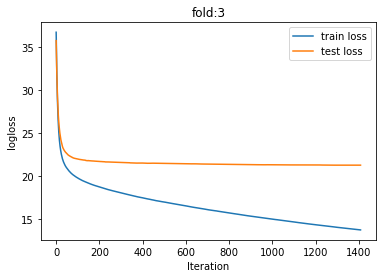

[I 2022-05-28 19:24:33,956] A new study created in memory with name: no-name-78b55442-9740-448d-8f3c-ac222c00726e


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 142.7	Test's l2: 708.811


[I 2022-05-28 19:24:50,524] Trial 0 finished with value: 24.766487635797688 and parameters: {'learning_rate': 0.5571537639018527, 'num_leaves': 187, 'tree_learner': 'feature', 'reg_alpha': 4.682348218007839e-06, 'reg_lambda': 7.531567293266711e-07, 'colsample_bytree': 0.9022957720110908, 'subsample': 0.7591686711474656, 'subsample_freq': 2, 'min_data_in_leaf': 33}. Best is trial 0 with value: 24.766487635797688.


Early stopping, best iteration is:
[10]	Train's l2: 363.418	Test's l2: 613.379
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 325.423	Test's l2: 915.826


[I 2022-05-28 19:24:59,460] Trial 1 finished with value: 25.89504733930687 and parameters: {'learning_rate': 0.8260182742116386, 'num_leaves': 71, 'tree_learner': 'voting', 'reg_alpha': 1.2318328031332877e-05, 'reg_lambda': 0.3642791845783852, 'colsample_bytree': 0.7512538451656253, 'subsample': 0.5209642028161343, 'subsample_freq': 1, 'min_data_in_leaf': 61}. Best is trial 0 with value: 24.766487635797688.


Early stopping, best iteration is:
[6]	Train's l2: 469.802	Test's l2: 670.553
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 180.871	Test's l2: 650.646


[I 2022-05-28 19:25:12,861] Trial 2 finished with value: 24.28199654838108 and parameters: {'learning_rate': 0.3738939303310872, 'num_leaves': 167, 'tree_learner': 'feature', 'reg_alpha': 0.008228288469594256, 'reg_lambda': 4.105678736019277e-08, 'colsample_bytree': 0.8923656899111369, 'subsample': 0.5867937675484042, 'subsample_freq': 7, 'min_data_in_leaf': 6}. Best is trial 2 with value: 24.28199654838108.


Early stopping, best iteration is:
[15]	Train's l2: 352.875	Test's l2: 589.615
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 282.177	Test's l2: 719.397


[I 2022-05-28 19:25:18,082] Trial 3 finished with value: 25.671172803507854 and parameters: {'learning_rate': 0.8800669950430101, 'num_leaves': 48, 'tree_learner': 'voting', 'reg_alpha': 0.06687070978300888, 'reg_lambda': 0.0010109450003495293, 'colsample_bytree': 0.8179473833338067, 'subsample': 0.965658120882508, 'subsample_freq': 4, 'min_data_in_leaf': 66}. Best is trial 2 with value: 24.28199654838108.


Early stopping, best iteration is:
[25]	Train's l2: 395.455	Test's l2: 659.009
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 152.933	Test's l2: 668.841


[I 2022-05-28 19:25:34,599] Trial 4 finished with value: 24.607764495523487 and parameters: {'learning_rate': 0.5213334364343186, 'num_leaves': 198, 'tree_learner': 'feature', 'reg_alpha': 0.0012124797522140736, 'reg_lambda': 0.00010448957720398584, 'colsample_bytree': 0.5309792445813004, 'subsample': 0.7890461961777471, 'subsample_freq': 3, 'min_data_in_leaf': 56}. Best is trial 2 with value: 24.28199654838108.


Early stopping, best iteration is:
[15]	Train's l2: 344.014	Test's l2: 605.542
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 204.115	Test's l2: 594.598


[I 2022-05-28 19:25:50,289] Trial 5 finished with value: 23.841063829091052 and parameters: {'learning_rate': 0.23251327850463377, 'num_leaves': 209, 'tree_learner': 'voting', 'reg_alpha': 3.289802079830972e-07, 'reg_lambda': 9.987648589460652e-05, 'colsample_bytree': 0.7802486631368835, 'subsample': 0.42414005970511004, 'subsample_freq': 3, 'min_data_in_leaf': 16}. Best is trial 5 with value: 23.841063829091052.


Early stopping, best iteration is:
[21]	Train's l2: 344.94	Test's l2: 568.396
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 438.943	Test's l2: 594.645
[200]	Train's l2: 406.059	Test's l2: 579.77
[300]	Train's l2: 385.652	Test's l2: 572.892
[400]	Train's l2: 371.411	Test's l2: 570.778
[500]	Train's l2: 359.817	Test's l2: 569.512


[I 2022-05-28 19:25:57,600] Trial 6 finished with value: 23.838186393074235 and parameters: {'learning_rate': 0.4597045872092749, 'num_leaves': 6, 'tree_learner': 'data', 'reg_alpha': 0.0009278395317780331, 'reg_lambda': 0.00039587971236587367, 'colsample_bytree': 0.40871940519239114, 'subsample': 0.7214775705659306, 'subsample_freq': 1, 'min_data_in_leaf': 75}. Best is trial 6 with value: 23.838186393074235.


Early stopping, best iteration is:
[450]	Train's l2: 365.589	Test's l2: 568.259
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 329.32	Test's l2: 568.127


[I 2022-05-28 19:26:03,665] Trial 7 finished with value: 23.7631189853475 and parameters: {'learning_rate': 0.295730081960971, 'num_leaves': 44, 'tree_learner': 'voting', 'reg_alpha': 8.765388410496457e-07, 'reg_lambda': 0.006171551663962957, 'colsample_bytree': 0.4248344596270717, 'subsample': 0.6750987445178411, 'subsample_freq': 7, 'min_data_in_leaf': 33}. Best is trial 7 with value: 23.7631189853475.


Early stopping, best iteration is:
[67]	Train's l2: 354.367	Test's l2: 564.686
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 168.001	Test's l2: 942.846


[I 2022-05-28 19:26:14,832] Trial 8 finished with value: 26.538063850686964 and parameters: {'learning_rate': 0.8778174296869657, 'num_leaves': 154, 'tree_learner': 'voting', 'reg_alpha': 0.017044868307128022, 'reg_lambda': 1.1007968665102394e-07, 'colsample_bytree': 0.5203795027814734, 'subsample': 0.84082885319816, 'subsample_freq': 5, 'min_data_in_leaf': 14}. Best is trial 7 with value: 23.7631189853475.


Early stopping, best iteration is:
[7]	Train's l2: 429.695	Test's l2: 704.269
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 207.429	Test's l2: 561.511


[I 2022-05-28 19:26:30,191] Trial 9 finished with value: 23.494731598843387 and parameters: {'learning_rate': 0.24609842223835168, 'num_leaves': 192, 'tree_learner': 'feature', 'reg_alpha': 0.0001619775664131692, 'reg_lambda': 0.28068684500479535, 'colsample_bytree': 0.7018952070551521, 'subsample': 0.7032768551628066, 'subsample_freq': 6, 'min_data_in_leaf': 89}. Best is trial 9 with value: 23.494731598843387.


Early stopping, best iteration is:
[38]	Train's l2: 299.692	Test's l2: 552.002
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 249.667	Test's l2: 523.033
[200]	Train's l2: 180.297	Test's l2: 524.333
Early stopping, best iteration is:
[149]	Train's l2: 210.678	Test's l2: 522.122


[I 2022-05-28 19:27:07,835] Trial 10 finished with value: 22.849987074026235 and parameters: {'learning_rate': 0.10559806574073222, 'num_leaves': 250, 'tree_learner': 'serial', 'reg_alpha': 5.298694794418606, 'reg_lambda': 0.797536194399143, 'colsample_bytree': 0.6301920899077533, 'subsample': 0.9176941590875968, 'subsample_freq': 6, 'min_data_in_leaf': 100}. Best is trial 10 with value: 22.849987074026235.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 243.269	Test's l2: 524.109
[200]	Train's l2: 174.56	Test's l2: 524.986
Early stopping, best iteration is:
[107]	Train's l2: 236.846	Test's l2: 523.85


[I 2022-05-28 19:27:38,950] Trial 11 finished with value: 22.887768017931307 and parameters: {'learning_rate': 0.10982818733943761, 'num_leaves': 254, 'tree_learner': 'serial', 'reg_alpha': 0.9723656247249916, 'reg_lambda': 3.191246884708065, 'colsample_bytree': 0.6401986121186958, 'subsample': 0.9676193041428964, 'subsample_freq': 6, 'min_data_in_leaf': 95}. Best is trial 10 with value: 22.849987074026235.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 249.01	Test's l2: 522.436
[200]	Train's l2: 181.275	Test's l2: 521.078
Early stopping, best iteration is:
[189]	Train's l2: 186.795	Test's l2: 520.652


[I 2022-05-28 19:28:21,364] Trial 12 finished with value: 22.817801514985753 and parameters: {'learning_rate': 0.10649115624942991, 'num_leaves': 252, 'tree_learner': 'serial', 'reg_alpha': 9.049376122489496, 'reg_lambda': 9.636756925202507, 'colsample_bytree': 0.6398580664043594, 'subsample': 0.9968634024174133, 'subsample_freq': 5, 'min_data_in_leaf': 97}. Best is trial 12 with value: 22.817801514985753.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 251.986	Test's l2: 525.838
[200]	Train's l2: 181.904	Test's l2: 523.079
Early stopping, best iteration is:
[176]	Train's l2: 195.673	Test's l2: 522.569


[I 2022-05-28 19:29:01,805] Trial 13 finished with value: 22.85976474141324 and parameters: {'learning_rate': 0.10561590253668349, 'num_leaves': 253, 'tree_learner': 'serial', 'reg_alpha': 4.136710596879279, 'reg_lambda': 7.797790267795573, 'colsample_bytree': 0.6257965628682479, 'subsample': 0.8872306488059923, 'subsample_freq': 5, 'min_data_in_leaf': 100}. Best is trial 12 with value: 22.817801514985753.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 189.435	Test's l2: 665.831


[I 2022-05-28 19:29:10,107] Trial 14 finished with value: 24.634670739726896 and parameters: {'learning_rate': 0.6518597553674427, 'num_leaves': 109, 'tree_learner': 'serial', 'reg_alpha': 0.26301845531818624, 'reg_lambda': 0.03890559130701091, 'colsample_bytree': 0.9980721822161776, 'subsample': 0.9875710932031727, 'subsample_freq': 5, 'min_data_in_leaf': 82}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[17]	Train's l2: 352.947	Test's l2: 606.867
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 209.526	Test's l2: 547.02


[I 2022-05-28 19:29:34,042] Trial 15 finished with value: 23.357181601505552 and parameters: {'learning_rate': 0.1896617585989791, 'num_leaves': 221, 'tree_learner': 'serial', 'reg_alpha': 6.8836803166554645, 'reg_lambda': 0.7726702083588903, 'colsample_bytree': 0.6072063449025789, 'subsample': 0.8718575730309024, 'subsample_freq': 6, 'min_data_in_leaf': 76}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[69]	Train's l2: 246.043	Test's l2: 545.558
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 144.864	Test's l2: 592.108


[I 2022-05-28 19:29:51,793] Trial 16 finished with value: 23.743989232839397 and parameters: {'learning_rate': 0.3612803502316117, 'num_leaves': 231, 'tree_learner': 'serial', 'reg_alpha': 8.773787429825516, 'reg_lambda': 0.029761666903248586, 'colsample_bytree': 0.529367071642756, 'subsample': 0.9034930120173027, 'subsample_freq': 4, 'min_data_in_leaf': 43}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[16]	Train's l2: 330.161	Test's l2: 563.777
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 180.708	Test's l2: 668.501


[I 2022-05-28 19:30:01,824] Trial 17 finished with value: 24.6440451825363 and parameters: {'learning_rate': 0.6489319575132282, 'num_leaves': 129, 'tree_learner': 'data', 'reg_alpha': 0.17694987188454347, 'reg_lambda': 3.774393806654068, 'colsample_bytree': 0.6911468404160621, 'subsample': 0.9973171424199359, 'subsample_freq': 6, 'min_data_in_leaf': 89}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[11]	Train's l2: 387.601	Test's l2: 607.329
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 222.844	Test's l2: 541.169


[I 2022-05-28 19:30:25,162] Trial 18 finished with value: 23.172691576562933 and parameters: {'learning_rate': 0.15847479031726813, 'num_leaves': 239, 'tree_learner': 'serial', 'reg_alpha': 2.7850866252689237e-08, 'reg_lambda': 5.367524305716341e-06, 'colsample_bytree': 0.5664962912479656, 'subsample': 0.8286595686093858, 'subsample_freq': 4, 'min_data_in_leaf': 99}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[50]	Train's l2: 289.705	Test's l2: 536.974
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 179.847	Test's l2: 973.066


[I 2022-05-28 19:30:35,626] Trial 19 finished with value: 26.74622944405616 and parameters: {'learning_rate': 0.9945350954143045, 'num_leaves': 151, 'tree_learner': 'serial', 'reg_alpha': 0.44431045131035835, 'reg_lambda': 0.045709783687555156, 'colsample_bytree': 0.4796303209145217, 'subsample': 0.9231998474619001, 'subsample_freq': 7, 'min_data_in_leaf': 71}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[8]	Train's l2: 439.462	Test's l2: 715.361
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 246.002	Test's l2: 598.903


[I 2022-05-28 19:30:44,609] Trial 20 finished with value: 23.98185549210204 and parameters: {'learning_rate': 0.34156572771328764, 'num_leaves': 115, 'tree_learner': 'serial', 'reg_alpha': 0.010229628369794842, 'reg_lambda': 0.007554626550808827, 'colsample_bytree': 0.6774081403843579, 'subsample': 0.6132501001765993, 'subsample_freq': 5, 'min_data_in_leaf': 85}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[17]	Train's l2: 382.728	Test's l2: 575.129
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 221.192	Test's l2: 530.393
Early stopping, best iteration is:
[76]	Train's l2: 248.086	Test's l2: 529.24


[I 2022-05-28 19:31:11,494] Trial 21 finished with value: 23.00522165808312 and parameters: {'learning_rate': 0.14690075429910043, 'num_leaves': 256, 'tree_learner': 'serial', 'reg_alpha': 1.5546536003869476, 'reg_lambda': 4.176450377573692, 'colsample_bytree': 0.6106077520782703, 'subsample': 0.906514373107982, 'subsample_freq': 5, 'min_data_in_leaf': 99}. Best is trial 12 with value: 22.817801514985753.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 244.384	Test's l2: 531.21
[200]	Train's l2: 175.481	Test's l2: 530.515
Early stopping, best iteration is:
[196]	Train's l2: 177.618	Test's l2: 530.494


[I 2022-05-28 19:31:53,615] Trial 22 finished with value: 23.032459395832735 and parameters: {'learning_rate': 0.1264153743499618, 'num_leaves': 228, 'tree_learner': 'serial', 'reg_alpha': 9.378133752884823, 'reg_lambda': 9.609744051957694, 'colsample_bytree': 0.6438689453861456, 'subsample': 0.9316791876995822, 'subsample_freq': 5, 'min_data_in_leaf': 92}. Best is trial 12 with value: 22.817801514985753.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 177.534	Test's l2: 555.738


[I 2022-05-28 19:32:12,293] Trial 23 finished with value: 23.414071782182916 and parameters: {'learning_rate': 0.23920840681744404, 'num_leaves': 247, 'tree_learner': 'serial', 'reg_alpha': 2.439016460862547, 'reg_lambda': 0.45710006924372154, 'colsample_bytree': 0.7364742866545892, 'subsample': 0.8212393245188162, 'subsample_freq': 6, 'min_data_in_leaf': 81}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[34]	Train's l2: 285.388	Test's l2: 548.219
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 257.5	Test's l2: 532.909
Early stopping, best iteration is:
[92]	Train's l2: 265.049	Test's l2: 531.873


[I 2022-05-28 19:32:38,269] Trial 24 finished with value: 23.06236406862036 and parameters: {'learning_rate': 0.11685381141235111, 'num_leaves': 213, 'tree_learner': 'data', 'reg_alpha': 0.06299465671012822, 'reg_lambda': 0.9707951902211326, 'colsample_bytree': 0.6107385531969067, 'subsample': 0.864427128047402, 'subsample_freq': 4, 'min_data_in_leaf': 100}. Best is trial 12 with value: 22.817801514985753.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 203.969	Test's l2: 554.676


[I 2022-05-28 19:32:53,620] Trial 25 finished with value: 23.360312699278257 and parameters: {'learning_rate': 0.2999744130709748, 'num_leaves': 175, 'tree_learner': 'serial', 'reg_alpha': 0.5531065940305108, 'reg_lambda': 0.1944582851335457, 'colsample_bytree': 0.47197282405743257, 'subsample': 0.9421274320428534, 'subsample_freq': 3, 'min_data_in_leaf': 92}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[44]	Train's l2: 280.624	Test's l2: 545.704
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 200.794	Test's l2: 551.158


[I 2022-05-28 19:33:13,158] Trial 26 finished with value: 23.380931372840855 and parameters: {'learning_rate': 0.20358368217065265, 'num_leaves': 231, 'tree_learner': 'serial', 'reg_alpha': 2.0985025293820585, 'reg_lambda': 7.998661392942643, 'colsample_bytree': 0.5747411724917245, 'subsample': 0.775859938950654, 'subsample_freq': 5, 'min_data_in_leaf': 47}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[37]	Train's l2: 298.067	Test's l2: 546.668
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 121.825	Test's l2: 630.31


[I 2022-05-28 19:33:29,086] Trial 27 finished with value: 24.04719570213252 and parameters: {'learning_rate': 0.43689818046662665, 'num_leaves': 256, 'tree_learner': 'serial', 'reg_alpha': 0.06826289813657778, 'reg_lambda': 1.8496134392669021, 'colsample_bytree': 0.8084752085094312, 'subsample': 0.8851511734677341, 'subsample_freq': 6, 'min_data_in_leaf': 81}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[11]	Train's l2: 346.113	Test's l2: 578.268
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 172.513	Test's l2: 556.594


[I 2022-05-28 19:33:44,664] Trial 28 finished with value: 23.31485344128163 and parameters: {'learning_rate': 0.2785456491145565, 'num_leaves': 218, 'tree_learner': 'serial', 'reg_alpha': 5.914378841988928e-05, 'reg_lambda': 0.07042195101157543, 'colsample_bytree': 0.6683233038581251, 'subsample': 0.9999001008446674, 'subsample_freq': 7, 'min_data_in_leaf': 67}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[25]	Train's l2: 305.664	Test's l2: 543.582
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 218.739	Test's l2: 545.978
Early stopping, best iteration is:
[70]	Train's l2: 253.854	Test's l2: 542.295


[I 2022-05-28 19:34:05,826] Trial 29 finished with value: 23.28722963333985 and parameters: {'learning_rate': 0.1823297048519349, 'num_leaves': 200, 'tree_learner': 'data', 'reg_alpha': 1.7828658343674895, 'reg_lambda': 1.926230531634516e-06, 'colsample_bytree': 0.8548723190960147, 'subsample': 0.8026254266625549, 'subsample_freq': 2, 'min_data_in_leaf': 87}. Best is trial 12 with value: 22.817801514985753.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 282.278	Test's l2: 528.934
[200]	Train's l2: 216.713	Test's l2: 525.942
[300]	Train's l2: 174.489	Test's l2: 526.629
Early stopping, best iteration is:
[244]	Train's l2: 196.268	Test's l2: 525.221


[I 2022-05-28 19:34:43,398] Trial 30 finished with value: 22.91769341079925 and parameters: {'learning_rate': 0.1030520523833626, 'num_leaves': 179, 'tree_learner': 'feature', 'reg_alpha': 0.02421705720651076, 'reg_lambda': 0.0032694156004950334, 'colsample_bytree': 0.7176501726676799, 'subsample': 0.7347419783743886, 'subsample_freq': 4, 'min_data_in_leaf': 94}. Best is trial 12 with value: 22.817801514985753.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 254.835	Test's l2: 525.75
[200]	Train's l2: 186.794	Test's l2: 522.876
Early stopping, best iteration is:
[192]	Train's l2: 191.003	Test's l2: 522.766


[I 2022-05-28 19:35:24,145] Trial 31 finished with value: 22.864071669646428 and parameters: {'learning_rate': 0.1011743365854661, 'num_leaves': 243, 'tree_learner': 'serial', 'reg_alpha': 1.1216000806216024, 'reg_lambda': 2.160121435766339, 'colsample_bytree': 0.6417078549070987, 'subsample': 0.9554968702933585, 'subsample_freq': 6, 'min_data_in_leaf': 96}. Best is trial 12 with value: 22.817801514985753.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 207.676	Test's l2: 527.065


[I 2022-05-28 19:35:50,617] Trial 32 finished with value: 22.901792402045636 and parameters: {'learning_rate': 0.1794400726111916, 'num_leaves': 237, 'tree_learner': 'serial', 'reg_alpha': 3.900353837124053, 'reg_lambda': 1.4190226142284552, 'colsample_bytree': 0.6472006682615712, 'subsample': 0.9512584849249776, 'subsample_freq': 6, 'min_data_in_leaf': 100}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[78]	Train's l2: 232.626	Test's l2: 524.492
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 259.055	Test's l2: 526.895
[200]	Train's l2: 189.714	Test's l2: 525.168
Early stopping, best iteration is:
[195]	Train's l2: 192.634	Test's l2: 524.747


[I 2022-05-28 19:36:39,262] Trial 33 finished with value: 22.907363385214673 and parameters: {'learning_rate': 0.10536069238298083, 'num_leaves': 241, 'tree_learner': 'serial', 'reg_alpha': 0.2334096517476884, 'reg_lambda': 9.731027786385155, 'colsample_bytree': 0.571752235970949, 'subsample': 0.8677767378385776, 'subsample_freq': 5, 'min_data_in_leaf': 94}. Best is trial 12 with value: 22.817801514985753.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 120.149	Test's l2: 728.284


[I 2022-05-28 19:36:51,851] Trial 34 finished with value: 24.780957174958253 and parameters: {'learning_rate': 0.6639395848344398, 'num_leaves': 208, 'tree_learner': 'serial', 'reg_alpha': 8.97912681511365, 'reg_lambda': 0.11755405097458477, 'colsample_bytree': 0.7641404823643497, 'subsample': 0.940238101778445, 'subsample_freq': 7, 'min_data_in_leaf': 79}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[5]	Train's l2: 406.145	Test's l2: 614.096
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 153.025	Test's l2: 658.45


[I 2022-05-28 19:37:08,724] Trial 35 finished with value: 24.377825251714967 and parameters: {'learning_rate': 0.42395691994410584, 'num_leaves': 241, 'tree_learner': 'serial', 'reg_alpha': 0.6375849139086146, 'reg_lambda': 0.6281913328238592, 'colsample_bytree': 0.609493098874175, 'subsample': 0.658604290697088, 'subsample_freq': 6, 'min_data_in_leaf': 62}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[13]	Train's l2: 354.774	Test's l2: 594.278
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 214.887	Test's l2: 564.877


[I 2022-05-28 19:37:27,004] Trial 36 finished with value: 23.426926164812297 and parameters: {'learning_rate': 0.23246216555855187, 'num_leaves': 220, 'tree_learner': 'feature', 'reg_alpha': 0.002442801648484728, 'reg_lambda': 1.8405597386554178, 'colsample_bytree': 0.733356229274261, 'subsample': 0.49958580335786695, 'subsample_freq': 5, 'min_data_in_leaf': 86}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[39]	Train's l2: 304.488	Test's l2: 548.821
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 152.217	Test's l2: 658.378


[I 2022-05-28 19:37:40,457] Trial 37 finished with value: 24.420681569559672 and parameters: {'learning_rate': 0.5431328127741291, 'num_leaves': 187, 'tree_learner': 'voting', 'reg_alpha': 0.12087212122550338, 'reg_lambda': 1.2369880353668851e-05, 'colsample_bytree': 0.5555264838257956, 'subsample': 0.9625904148533025, 'subsample_freq': 7, 'min_data_in_leaf': 96}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[16]	Train's l2: 341.06	Test's l2: 596.37
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 282.048	Test's l2: 561.409


[I 2022-05-28 19:37:48,969] Trial 38 finished with value: 23.61434722296398 and parameters: {'learning_rate': 0.30518002087592383, 'num_leaves': 74, 'tree_learner': 'serial', 'reg_alpha': 0.00387053265681455, 'reg_lambda': 0.21329705849543412, 'colsample_bytree': 0.4954141402413629, 'subsample': 0.9002162284795625, 'subsample_freq': 6, 'min_data_in_leaf': 72}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[54]	Train's l2: 327.751	Test's l2: 557.637
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 226.035	Test's l2: 536.897


[I 2022-05-28 19:38:09,180] Trial 39 finished with value: 23.140501810756174 and parameters: {'learning_rate': 0.15249800416261655, 'num_leaves': 203, 'tree_learner': 'serial', 'reg_alpha': 2.1397245955824292e-05, 'reg_lambda': 4.825411890414636e-05, 'colsample_bytree': 0.6451159594047691, 'subsample': 0.7568284210866342, 'subsample_freq': 5, 'min_data_in_leaf': 27}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[49]	Train's l2: 293.87	Test's l2: 535.483
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 150.147	Test's l2: 779.063


[I 2022-05-28 19:38:19,965] Trial 40 finished with value: 25.43663209137096 and parameters: {'learning_rate': 0.7247968824092398, 'num_leaves': 166, 'tree_learner': 'voting', 'reg_alpha': 3.322263761312739, 'reg_lambda': 0.016051028562865454, 'colsample_bytree': 0.7809732450825532, 'subsample': 0.8527388853835393, 'subsample_freq': 3, 'min_data_in_leaf': 58}. Best is trial 12 with value: 22.817801514985753.


Early stopping, best iteration is:
[6]	Train's l2: 409.639	Test's l2: 647.022
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 249.823	Test's l2: 518.438
[200]	Train's l2: 181.272	Test's l2: 516.797
Early stopping, best iteration is:
[191]	Train's l2: 185.862	Test's l2: 516.118


[I 2022-05-28 19:39:03,431] Trial 41 finished with value: 22.71823195541278 and parameters: {'learning_rate': 0.10060438365356983, 'num_leaves': 256, 'tree_learner': 'serial', 'reg_alpha': 1.082517479514153, 'reg_lambda': 2.5599794353585055, 'colsample_bytree': 0.6463247623556444, 'subsample': 0.9671526623513719, 'subsample_freq': 6, 'min_data_in_leaf': 94}. Best is trial 41 with value: 22.71823195541278.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 186.269	Test's l2: 545.649


[I 2022-05-28 19:39:22,333] Trial 42 finished with value: 23.310478297682135 and parameters: {'learning_rate': 0.21106430408608381, 'num_leaves': 247, 'tree_learner': 'serial', 'reg_alpha': 0.9415935135231587, 'reg_lambda': 3.5366396966918545, 'colsample_bytree': 0.669492238140337, 'subsample': 0.971812427333705, 'subsample_freq': 6, 'min_data_in_leaf': 90}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[32]	Train's l2: 299.405	Test's l2: 543.378
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 212.052	Test's l2: 534.974
[200]	Train's l2: 138.125	Test's l2: 538.52
Early stopping, best iteration is:
[113]	Train's l2: 199.848	Test's l2: 534.533


[I 2022-05-28 19:39:57,355] Trial 43 finished with value: 23.119964671023848 and parameters: {'learning_rate': 0.1626296456951157, 'num_leaves': 256, 'tree_learner': 'serial', 'reg_alpha': 3.4814196576370455, 'reg_lambda': 0.5218676816638457, 'colsample_bytree': 0.5901800375792665, 'subsample': 0.921182763379944, 'subsample_freq': 5, 'min_data_in_leaf': 96}. Best is trial 41 with value: 22.71823195541278.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 178.639	Test's l2: 563.527


[I 2022-05-28 19:40:15,020] Trial 44 finished with value: 23.559470172535 and parameters: {'learning_rate': 0.2598433499583168, 'num_leaves': 225, 'tree_learner': 'feature', 'reg_alpha': 0.03344787995204415, 'reg_lambda': 1.2602336181088068e-07, 'colsample_bytree': 0.6299608609313636, 'subsample': 0.9741867117196582, 'subsample_freq': 6, 'min_data_in_leaf': 83}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[42]	Train's l2: 265.852	Test's l2: 555.049
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 252.373	Test's l2: 526.291
[200]	Train's l2: 183.386	Test's l2: 526.662
Early stopping, best iteration is:
[130]	Train's l2: 226.619	Test's l2: 525.342


[I 2022-05-28 19:40:48,576] Trial 45 finished with value: 22.92034425766322 and parameters: {'learning_rate': 0.10094688044315192, 'num_leaves': 244, 'tree_learner': 'serial', 'reg_alpha': 0.463008785906789, 'reg_lambda': 1.529036768903672, 'colsample_bytree': 0.7084182555839355, 'subsample': 0.9019984853067822, 'subsample_freq': 7, 'min_data_in_leaf': 89}. Best is trial 41 with value: 22.71823195541278.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 199.687	Test's l2: 540.252


[I 2022-05-28 19:41:10,632] Trial 46 finished with value: 23.186785019845228 and parameters: {'learning_rate': 0.21247770294523738, 'num_leaves': 232, 'tree_learner': 'data', 'reg_alpha': 1.3920689538099578, 'reg_lambda': 4.5491991766542315, 'colsample_bytree': 0.5514041264697728, 'subsample': 0.9463425852108241, 'subsample_freq': 5, 'min_data_in_leaf': 96}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[54]	Train's l2: 260.337	Test's l2: 537.627
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 504.58	Test's l2: 631.442
[200]	Train's l2: 468.437	Test's l2: 611.562
[300]	Train's l2: 448.489	Test's l2: 599.696
[400]	Train's l2: 435.158	Test's l2: 588.901
[500]	Train's l2: 424.658	Test's l2: 580.167
[600]	Train's l2: 416.991	Test's l2: 576.538
[700]	Train's l2: 410.625	Test's l2: 574.331
[800]	Train's l2: 405.038	Test's l2: 570.348
[900]	Train's l2: 399.72	Test's l2: 566.734
[1000]	Train's l2: 395.234	Test's l2: 563.04
[1100]	Train's l2: 391.422	Test's l2: 561.741
[1200]	Train's l2: 387.558	Test's l2: 561.43
[1300]	Train's l2: 383.82	Test's l2: 559.261
[1400]	Train's l2: 380.301	Test's l2: 558.59
[1500]	Train's l2: 377.29	Test's l2: 556.666
[1

[I 2022-05-28 19:41:32,917] Trial 47 finished with value: 23.564685001343168 and parameters: {'learning_rate': 0.1450358960332306, 'num_leaves': 4, 'tree_learner': 'serial', 'reg_alpha': 0.10729117489412178, 'reg_lambda': 0.1775087201166688, 'colsample_bytree': 0.6809196866393428, 'subsample': 0.9901439111473678, 'subsample_freq': 6, 'min_data_in_leaf': 75}. Best is trial 41 with value: 22.71823195541278.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 198.549	Test's l2: 623.698


[I 2022-05-28 19:41:47,977] Trial 48 finished with value: 23.98703457001379 and parameters: {'learning_rate': 0.3349166826119263, 'num_leaves': 211, 'tree_learner': 'voting', 'reg_alpha': 4.414302306673688, 'reg_lambda': 0.002346687654248531, 'colsample_bytree': 0.5983905102422528, 'subsample': 0.5294810487434622, 'subsample_freq': 4, 'min_data_in_leaf': 87}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[17]	Train's l2: 360.528	Test's l2: 575.378
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 199.107	Test's l2: 552.442


[I 2022-05-28 19:42:11,669] Trial 49 finished with value: 23.47345825196704 and parameters: {'learning_rate': 0.1769046980905238, 'num_leaves': 246, 'tree_learner': 'serial', 'reg_alpha': 0.0006893341543320497, 'reg_lambda': 0.39317170991025485, 'colsample_bytree': 0.9847413344308173, 'subsample': 0.8844318444557014, 'subsample_freq': 7, 'min_data_in_leaf': 100}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[56]	Train's l2: 257.386	Test's l2: 551.003
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 271.366	Test's l2: 638.674


[I 2022-05-28 19:42:18,808] Trial 50 finished with value: 24.533569226250115 and parameters: {'learning_rate': 0.5936090839041119, 'num_leaves': 70, 'tree_learner': 'serial', 'reg_alpha': 4.090256467606444e-06, 'reg_lambda': 2.6116809665861487, 'colsample_bytree': 0.5157977100507395, 'subsample': 0.8339016904198155, 'subsample_freq': 6, 'min_data_in_leaf': 92}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[31]	Train's l2: 364.206	Test's l2: 601.896
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 224.483	Test's l2: 531.518
[200]	Train's l2: 153.283	Test's l2: 533.346
Early stopping, best iteration is:
[151]	Train's l2: 183.366	Test's l2: 530.164


[I 2022-05-28 19:42:57,023] Trial 51 finished with value: 23.025288705965668 and parameters: {'learning_rate': 0.1384830625307477, 'num_leaves': 254, 'tree_learner': 'serial', 'reg_alpha': 1.0334161647335542, 'reg_lambda': 5.194179595546277, 'colsample_bytree': 0.631545447808395, 'subsample': 0.9697628539403795, 'subsample_freq': 6, 'min_data_in_leaf': 96}. Best is trial 41 with value: 22.71823195541278.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 258.896	Test's l2: 524.086
[200]	Train's l2: 191.207	Test's l2: 519.655
[300]	Train's l2: 147.982	Test's l2: 521.633
Early stopping, best iteration is:
[223]	Train's l2: 180.091	Test's l2: 519.413


[I 2022-05-28 19:43:40,783] Trial 52 finished with value: 22.790639046250764 and parameters: {'learning_rate': 0.10036678365967788, 'num_leaves': 232, 'tree_learner': 'serial', 'reg_alpha': 0.23443851726104953, 'reg_lambda': 1.0681584169640557, 'colsample_bytree': 0.6600438023306077, 'subsample': 0.9181284565512047, 'subsample_freq': 6, 'min_data_in_leaf': 96}. Best is trial 41 with value: 22.71823195541278.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 232.726	Test's l2: 528.146


[I 2022-05-28 19:44:06,511] Trial 53 finished with value: 22.961667750864848 and parameters: {'learning_rate': 0.13804087895155154, 'num_leaves': 226, 'tree_learner': 'serial', 'reg_alpha': 0.2745307301526208, 'reg_lambda': 0.8920355376735833, 'colsample_bytree': 0.6647007303919027, 'subsample': 0.9136041721812284, 'subsample_freq': 6, 'min_data_in_leaf': 90}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[86]	Train's l2: 247.366	Test's l2: 527.238
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 193.722	Test's l2: 545.693


[I 2022-05-28 19:44:30,213] Trial 54 finished with value: 23.308060856726737 and parameters: {'learning_rate': 0.2091819686013307, 'num_leaves': 235, 'tree_learner': 'serial', 'reg_alpha': 9.780631420421903, 'reg_lambda': 0.0006413609381139872, 'colsample_bytree': 0.693449058404787, 'subsample': 0.9285045002125095, 'subsample_freq': 5, 'min_data_in_leaf': 97}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[72]	Train's l2: 226.399	Test's l2: 543.266
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 272.041	Test's l2: 521.599
[200]	Train's l2: 208.93	Test's l2: 520.771
Early stopping, best iteration is:
[182]	Train's l2: 218.194	Test's l2: 519.854


[I 2022-05-28 19:45:05,253] Trial 55 finished with value: 22.80029826257779 and parameters: {'learning_rate': 0.1005328020357799, 'num_leaves': 192, 'tree_learner': 'serial', 'reg_alpha': 1.0489800112428735e-08, 'reg_lambda': 0.08134916091003339, 'colsample_bytree': 0.6248166027377179, 'subsample': 0.9994912457174213, 'subsample_freq': 7, 'min_data_in_leaf': 85}. Best is trial 41 with value: 22.71823195541278.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 174.969	Test's l2: 565.858


[I 2022-05-28 19:45:20,550] Trial 56 finished with value: 23.581451558136212 and parameters: {'learning_rate': 0.25549268559314514, 'num_leaves': 195, 'tree_learner': 'serial', 'reg_alpha': 3.576203454998359e-08, 'reg_lambda': 1.1286124295742616e-08, 'colsample_bytree': 0.6205586273601467, 'subsample': 0.984609256849959, 'subsample_freq': 7, 'min_data_in_leaf': 7}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[26]	Train's l2: 306.584	Test's l2: 556.085
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 248.095	Test's l2: 538.071


[I 2022-05-28 19:45:38,893] Trial 57 finished with value: 23.14921011062152 and parameters: {'learning_rate': 0.182911811631017, 'num_leaves': 147, 'tree_learner': 'data', 'reg_alpha': 2.3482278953410892e-07, 'reg_lambda': 0.09648582846049725, 'colsample_bytree': 0.722566966112508, 'subsample': 0.9987762416413938, 'subsample_freq': 7, 'min_data_in_leaf': 84}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[87]	Train's l2: 259.867	Test's l2: 535.886
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 147.073	Test's l2: 1114.28


[I 2022-05-28 19:45:52,818] Trial 58 finished with value: 27.076886257604897 and parameters: {'learning_rate': 0.9881145684592658, 'num_leaves': 217, 'tree_learner': 'feature', 'reg_alpha': 0.00012956883139740938, 'reg_lambda': 0.3541994083741232, 'colsample_bytree': 0.5934190706358189, 'subsample': 0.8115124948460976, 'subsample_freq': 1, 'min_data_in_leaf': 77}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[4]	Train's l2: 473.125	Test's l2: 733.158
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 234.263	Test's l2: 530.63


[I 2022-05-28 19:46:15,597] Trial 59 finished with value: 22.999816547016948 and parameters: {'learning_rate': 0.13896184067421796, 'num_leaves': 231, 'tree_learner': 'serial', 'reg_alpha': 8.02736479302212e-07, 'reg_lambda': 0.02354432985247404, 'colsample_bytree': 0.5457494640580095, 'subsample': 0.8817454454739306, 'subsample_freq': 7, 'min_data_in_leaf': 92}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[56]	Train's l2: 288.969	Test's l2: 528.992
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 222.967	Test's l2: 522.333


[I 2022-05-28 19:46:36,327] Trial 60 finished with value: 22.852279077419684 and parameters: {'learning_rate': 0.16472916542232732, 'num_leaves': 207, 'tree_learner': 'serial', 'reg_alpha': 9.848822633300186e-08, 'reg_lambda': 8.769671132947678, 'colsample_bytree': 0.6619653207010567, 'subsample': 0.9316817433912269, 'subsample_freq': 5, 'min_data_in_leaf': 38}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[57]	Train's l2: 274.818	Test's l2: 522.227
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 221.113	Test's l2: 526.975
[200]	Train's l2: 150.757	Test's l2: 526.089
[300]	Train's l2: 109.637	Test's l2: 527.312
Early stopping, best iteration is:
[212]	Train's l2: 144.54	Test's l2: 525.284


[I 2022-05-28 19:47:24,820] Trial 61 finished with value: 22.919074952863284 and parameters: {'learning_rate': 0.1343110323765067, 'num_leaves': 249, 'tree_learner': 'serial', 'reg_alpha': 1.1576793065484544e-08, 'reg_lambda': 8.779817283148898, 'colsample_bytree': 0.6585784781599576, 'subsample': 0.9267183391743083, 'subsample_freq': 4, 'min_data_in_leaf': 36}. Best is trial 41 with value: 22.71823195541278.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 216.911	Test's l2: 533.332


[I 2022-05-28 19:47:48,089] Trial 62 finished with value: 23.024405555831354 and parameters: {'learning_rate': 0.16898733637851043, 'num_leaves': 207, 'tree_learner': 'serial', 'reg_alpha': 2.3041150791618198e-08, 'reg_lambda': 0.9853669069356209, 'colsample_bytree': 0.6894117840475031, 'subsample': 0.955322554205732, 'subsample_freq': 5, 'min_data_in_leaf': 52}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[67]	Train's l2: 255.039	Test's l2: 530.123
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 182.408	Test's l2: 548.001


[I 2022-05-28 19:48:07,313] Trial 63 finished with value: 23.28754158257025 and parameters: {'learning_rate': 0.2309262007796355, 'num_leaves': 223, 'tree_learner': 'serial', 'reg_alpha': 1.006951590922388e-08, 'reg_lambda': 4.856757391580884, 'colsample_bytree': 0.5853691361549809, 'subsample': 0.9772829635628889, 'subsample_freq': 5, 'min_data_in_leaf': 24}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[30]	Train's l2: 299.621	Test's l2: 542.31
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 264.652	Test's l2: 530.623
[200]	Train's l2: 197.812	Test's l2: 527.224
Early stopping, best iteration is:
[158]	Train's l2: 220.816	Test's l2: 526.638


[I 2022-05-28 19:48:40,885] Trial 64 finished with value: 22.94859880479607 and parameters: {'learning_rate': 0.10794389739875637, 'num_leaves': 187, 'tree_learner': 'serial', 'reg_alpha': 7.71374805452748e-08, 'reg_lambda': 2.151204788457069, 'colsample_bytree': 0.6265842592125377, 'subsample': 0.8541768930541505, 'subsample_freq': 4, 'min_data_in_leaf': 35}. Best is trial 41 with value: 22.71823195541278.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 192.441	Test's l2: 539.712


[I 2022-05-28 19:49:07,835] Trial 65 finished with value: 23.197549538704685 and parameters: {'learning_rate': 0.19855184375947096, 'num_leaves': 238, 'tree_learner': 'serial', 'reg_alpha': 5.954348982935835e-08, 'reg_lambda': 5.758293036301136, 'colsample_bytree': 0.6544177650100677, 'subsample': 0.9019211893510944, 'subsample_freq': 6, 'min_data_in_leaf': 44}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[66]	Train's l2: 233.611	Test's l2: 538.126
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 406.876	Test's l2: 556.942
[200]	Train's l2: 371.964	Test's l2: 541.615
[300]	Train's l2: 351.116	Test's l2: 534.108
[400]	Train's l2: 334.674	Test's l2: 531.096
[500]	Train's l2: 320.694	Test's l2: 530.09
[600]	Train's l2: 308.304	Test's l2: 529.478
[700]	Train's l2: 296.903	Test's l2: 527.542
[800]	Train's l2: 286.584	Test's l2: 528.216
Early stopping, best iteration is:
[731]	Train's l2: 293.715	Test's l2: 527.191


[I 2022-05-28 19:49:28,329] Trial 66 finished with value: 22.960650134519646 and parameters: {'learning_rate': 0.12850268332440645, 'num_leaves': 18, 'tree_learner': 'serial', 'reg_alpha': 3.562149904196853e-06, 'reg_lambda': 0.9656929301650105, 'colsample_bytree': 0.6977698302162887, 'subsample': 0.939339823839204, 'subsample_freq': 5, 'min_data_in_leaf': 40}. Best is trial 41 with value: 22.71823195541278.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 131.796	Test's l2: 594.662


[I 2022-05-28 19:49:50,575] Trial 67 finished with value: 23.929882352744254 and parameters: {'learning_rate': 0.3947225667917737, 'num_leaves': 250, 'tree_learner': 'voting', 'reg_alpha': 1.5027399821867337e-07, 'reg_lambda': 3.5998855796844578, 'colsample_bytree': 0.7580043557614573, 'subsample': 0.9579139650236427, 'subsample_freq': 5, 'min_data_in_leaf': 99}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[22]	Train's l2: 290.49	Test's l2: 572.639
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 214.029	Test's l2: 535.206
Early stopping, best iteration is:
[67]	Train's l2: 251.828	Test's l2: 532.935


[I 2022-05-28 19:50:18,631] Trial 68 finished with value: 23.08537467544838 and parameters: {'learning_rate': 0.15985480405310235, 'num_leaves': 235, 'tree_learner': 'serial', 'reg_alpha': 4.602735417091485, 'reg_lambda': 9.157032800207109, 'colsample_bytree': 0.6154272648916688, 'subsample': 0.917694304210169, 'subsample_freq': 4, 'min_data_in_leaf': 28}. Best is trial 41 with value: 22.71823195541278.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 268.462	Test's l2: 748.42


[I 2022-05-28 19:50:29,035] Trial 69 finished with value: 24.850929875084443 and parameters: {'learning_rate': 0.5080668602671725, 'num_leaves': 138, 'tree_learner': 'serial', 'reg_alpha': 1.0114076177677303e-06, 'reg_lambda': 0.07636216403513757, 'colsample_bytree': 0.6803205505803134, 'subsample': 0.4123990721071935, 'subsample_freq': 6, 'min_data_in_leaf': 93}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[10]	Train's l2: 419.866	Test's l2: 617.569
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 199.527	Test's l2: 554.747


[I 2022-05-28 19:50:45,921] Trial 70 finished with value: 23.364395595115717 and parameters: {'learning_rate': 0.269699180007579, 'num_leaves': 174, 'tree_learner': 'data', 'reg_alpha': 1.9232034328335084, 'reg_lambda': 0.2643308717075707, 'colsample_bytree': 0.5661174965189049, 'subsample': 0.9982600695839939, 'subsample_freq': 6, 'min_data_in_leaf': 52}. Best is trial 41 with value: 22.71823195541278.


Early stopping, best iteration is:
[44]	Train's l2: 276.773	Test's l2: 545.895
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 236.88	Test's l2: 526.41
[200]	Train's l2: 166.474	Test's l2: 526.658
Early stopping, best iteration is:
[119]	Train's l2: 219.621	Test's l2: 524.744


[I 2022-05-28 19:51:21,350] Trial 71 finished with value: 22.907290010501548 and parameters: {'learning_rate': 0.12560158413782754, 'num_leaves': 241, 'tree_learner': 'serial', 'reg_alpha': 5.76485827401423, 'reg_lambda': 1.902882629100753, 'colsample_bytree': 0.6490522907739318, 'subsample': 0.9562061006243778, 'subsample_freq': 7, 'min_data_in_leaf': 97}. Best is trial 41 with value: 22.71823195541278.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 260.023	Test's l2: 520.631
[200]	Train's l2: 194.009	Test's l2: 518.848
Early stopping, best iteration is:
[184]	Train's l2: 202.13	Test's l2: 517.452


[I 2022-05-28 19:52:01,939] Trial 72 finished with value: 22.74757844301789 and parameters: {'learning_rate': 0.10584358717069636, 'num_leaves': 217, 'tree_learner': 'serial', 'reg_alpha': 0.7292967239976315, 'reg_lambda': 2.76372181541403, 'colsample_bytree': 0.6319351305346164, 'subsample': 0.9791703306855563, 'subsample_freq': 6, 'min_data_in_leaf': 88}. Best is trial 41 with value: 22.71823195541278.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 262.833	Test's l2: 518.357
[200]	Train's l2: 197.285	Test's l2: 516.269
[300]	Train's l2: 155.913	Test's l2: 515.548
Early stopping, best iteration is:
[290]	Train's l2: 159.394	Test's l2: 515.06


[I 2022-05-28 19:52:57,221] Trial 73 finished with value: 22.69493532721425 and parameters: {'learning_rate': 0.1014515665286651, 'num_leaves': 217, 'tree_learner': 'serial', 'reg_alpha': 0.641619631056804, 'reg_lambda': 0.5963175585575874, 'colsample_bytree': 0.6040502993643101, 'subsample': 0.9806132676225496, 'subsample_freq': 6, 'min_data_in_leaf': 88}. Best is trial 73 with value: 22.69493532721425.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 263.488	Test's l2: 520.207
[200]	Train's l2: 197.83	Test's l2: 518.77
Early stopping, best iteration is:
[187]	Train's l2: 204.532	Test's l2: 518.105


[I 2022-05-28 19:53:43,848] Trial 74 finished with value: 22.76192487555702 and parameters: {'learning_rate': 0.10123288541922405, 'num_leaves': 216, 'tree_learner': 'serial', 'reg_alpha': 0.3663549379491401, 'reg_lambda': 0.6075249537470698, 'colsample_bytree': 0.6034154471180682, 'subsample': 0.9825259623656466, 'subsample_freq': 6, 'min_data_in_leaf': 88}. Best is trial 73 with value: 22.69493532721425.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 264.231	Test's l2: 517.778
[200]	Train's l2: 197.933	Test's l2: 515.18
Early stopping, best iteration is:
[180]	Train's l2: 209.267	Test's l2: 514.541


[I 2022-05-28 19:54:24,186] Trial 75 finished with value: 22.68348574518722 and parameters: {'learning_rate': 0.10051119651142577, 'num_leaves': 214, 'tree_learner': 'serial', 'reg_alpha': 0.049645419468861106, 'reg_lambda': 0.6126994525281032, 'colsample_bytree': 0.5879780730887396, 'subsample': 0.9785764603184196, 'subsample_freq': 6, 'min_data_in_leaf': 80}. Best is trial 75 with value: 22.68348574518722.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 250.996	Test's l2: 522.383
[200]	Train's l2: 184.261	Test's l2: 520.27
Early stopping, best iteration is:
[196]	Train's l2: 186.437	Test's l2: 520.058


[I 2022-05-28 19:55:03,467] Trial 76 finished with value: 22.80476951168034 and parameters: {'learning_rate': 0.1280678429150371, 'num_leaves': 200, 'tree_learner': 'serial', 'reg_alpha': 0.05151544186449464, 'reg_lambda': 0.14911722681741219, 'colsample_bytree': 0.5352142002387194, 'subsample': 0.9815393759251985, 'subsample_freq': 6, 'min_data_in_leaf': 79}. Best is trial 75 with value: 22.68348574518722.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 274.915	Test's l2: 521.324
[200]	Train's l2: 212.527	Test's l2: 518.478
Early stopping, best iteration is:
[189]	Train's l2: 218.128	Test's l2: 517.952


[I 2022-05-28 19:55:45,563] Trial 77 finished with value: 22.75856450977167 and parameters: {'learning_rate': 0.10005101809517761, 'num_leaves': 192, 'tree_learner': 'serial', 'reg_alpha': 0.045499037401737476, 'reg_lambda': 0.010676004067150111, 'colsample_bytree': 0.5278892483534847, 'subsample': 0.9808033575154621, 'subsample_freq': 7, 'min_data_in_leaf': 79}. Best is trial 75 with value: 22.68348574518722.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 225.142	Test's l2: 525.126
Early stopping, best iteration is:
[73]	Train's l2: 254.782	Test's l2: 522.339


[I 2022-05-28 19:56:07,899] Trial 78 finished with value: 22.85474386545515 and parameters: {'learning_rate': 0.18490614918821693, 'num_leaves': 191, 'tree_learner': 'feature', 'reg_alpha': 0.008217114811511298, 'reg_lambda': 0.007161723315769791, 'colsample_bytree': 0.4849114298687787, 'subsample': 0.9787997552907447, 'subsample_freq': 7, 'min_data_in_leaf': 70}. Best is trial 75 with value: 22.68348574518722.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 224.833	Test's l2: 536.632


[I 2022-05-28 19:56:26,019] Trial 79 finished with value: 23.082342685061317 and parameters: {'learning_rate': 0.2312931342413504, 'num_leaves': 164, 'tree_learner': 'serial', 'reg_alpha': 0.015774958589927814, 'reg_lambda': 0.035759601506883704, 'colsample_bytree': 0.5736637165321218, 'subsample': 0.9632065588383185, 'subsample_freq': 7, 'min_data_in_leaf': 80}. Best is trial 75 with value: 22.68348574518722.


Early stopping, best iteration is:
[54]	Train's l2: 280.995	Test's l2: 532.795
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 269.733	Test's l2: 514.378
[200]	Train's l2: 205.28	Test's l2: 513.391
[300]	Train's l2: 162.402	Test's l2: 513.187
Early stopping, best iteration is:
[283]	Train's l2: 168.993	Test's l2: 512.61


[I 2022-05-28 19:57:16,994] Trial 80 finished with value: 22.640898182641145 and parameters: {'learning_rate': 0.10245107959916047, 'num_leaves': 214, 'tree_learner': 'serial', 'reg_alpha': 0.2990026249760526, 'reg_lambda': 0.015308811334841285, 'colsample_bytree': 0.43439798577244276, 'subsample': 0.9426116387777276, 'subsample_freq': 7, 'min_data_in_leaf': 86}. Best is trial 80 with value: 22.640898182641145.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 255.281	Test's l2: 522.873
[200]	Train's l2: 189.217	Test's l2: 520.427
Early stopping, best iteration is:
[168]	Train's l2: 206.773	Test's l2: 519.901


[I 2022-05-28 19:57:52,410] Trial 81 finished with value: 22.801347954537015 and parameters: {'learning_rate': 0.11984164428860312, 'num_leaves': 214, 'tree_learner': 'serial', 'reg_alpha': 0.14605145430067415, 'reg_lambda': 0.05903136492316508, 'colsample_bytree': 0.44017565586260676, 'subsample': 0.9423691709801115, 'subsample_freq': 7, 'min_data_in_leaf': 84}. Best is trial 80 with value: 22.640898182641145.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 281.106	Test's l2: 518.334
[200]	Train's l2: 218.332	Test's l2: 514.875
[300]	Train's l2: 177.618	Test's l2: 515.338
Early stopping, best iteration is:
[229]	Train's l2: 204.939	Test's l2: 514.554


[I 2022-05-28 19:58:30,251] Trial 82 finished with value: 22.683782907564044 and parameters: {'learning_rate': 0.10305558705046061, 'num_leaves': 184, 'tree_learner': 'serial', 'reg_alpha': 0.5945178389382205, 'reg_lambda': 0.010373961449344517, 'colsample_bytree': 0.4353680364119393, 'subsample': 0.9836448640506249, 'subsample_freq': 7, 'min_data_in_leaf': 86}. Best is trial 80 with value: 22.640898182641145.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 231.216	Test's l2: 530.132
Early stopping, best iteration is:
[90]	Train's l2: 241.676	Test's l2: 529.718


[I 2022-05-28 19:58:55,760] Trial 83 finished with value: 23.015613978554363 and parameters: {'learning_rate': 0.1536019284934515, 'num_leaves': 218, 'tree_learner': 'serial', 'reg_alpha': 0.4239224033362845, 'reg_lambda': 0.0027360403778654992, 'colsample_bytree': 0.5163148640897273, 'subsample': 0.9698472782781405, 'subsample_freq': 7, 'min_data_in_leaf': 88}. Best is trial 80 with value: 22.640898182641145.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 268.726	Test's l2: 519.504
[200]	Train's l2: 205.171	Test's l2: 518.516
Early stopping, best iteration is:
[128]	Train's l2: 247.648	Test's l2: 517.388


[I 2022-05-28 19:59:20,703] Trial 84 finished with value: 22.74616327049739 and parameters: {'learning_rate': 0.12484352486271233, 'num_leaves': 178, 'tree_learner': 'serial', 'reg_alpha': 0.7506945784528661, 'reg_lambda': 0.0001148528905642096, 'colsample_bytree': 0.40271344417223653, 'subsample': 0.9500988220416733, 'subsample_freq': 6, 'min_data_in_leaf': 74}. Best is trial 80 with value: 22.640898182641145.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 147.115	Test's l2: 819.727


[I 2022-05-28 19:59:32,416] Trial 85 finished with value: 25.908627730729133 and parameters: {'learning_rate': 0.8076194147547442, 'num_leaves': 183, 'tree_learner': 'serial', 'reg_alpha': 0.1044282803108079, 'reg_lambda': 0.00011966526669232411, 'colsample_bytree': 0.4148256081394672, 'subsample': 0.9473396706989268, 'subsample_freq': 6, 'min_data_in_leaf': 73}. Best is trial 80 with value: 22.640898182641145.


Early stopping, best iteration is:
[6]	Train's l2: 437.764	Test's l2: 671.257
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 253.038	Test's l2: 526.286


[I 2022-05-28 19:59:52,600] Trial 86 finished with value: 22.925766371247732 and parameters: {'learning_rate': 0.15632030110649925, 'num_leaves': 172, 'tree_learner': 'serial', 'reg_alpha': 0.6897679576354498, 'reg_lambda': 0.0014437908978004793, 'colsample_bytree': 0.4348661033289611, 'subsample': 0.9827576738920645, 'subsample_freq': 7, 'min_data_in_leaf': 77}. Best is trial 80 with value: 22.640898182641145.


Early stopping, best iteration is:
[82]	Train's l2: 270.023	Test's l2: 525.591
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 220.61	Test's l2: 529.173


[I 2022-05-28 20:00:13,919] Trial 87 finished with value: 22.980338743941545 and parameters: {'learning_rate': 0.19906324371403888, 'num_leaves': 198, 'tree_learner': 'voting', 'reg_alpha': 0.032531438025343785, 'reg_lambda': 0.012763251305782793, 'colsample_bytree': 0.45489238863833176, 'subsample': 0.9691686089915897, 'subsample_freq': 6, 'min_data_in_leaf': 82}. Best is trial 80 with value: 22.640898182641145.


Early stopping, best iteration is:
[67]	Train's l2: 257.653	Test's l2: 528.096
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 276.891	Test's l2: 521.118
[200]	Train's l2: 215.107	Test's l2: 521.089
[300]	Train's l2: 173.639	Test's l2: 519.697
Early stopping, best iteration is:
[281]	Train's l2: 180.602	Test's l2: 519.227


[I 2022-05-28 20:00:52,462] Trial 88 finished with value: 22.786561197922005 and parameters: {'learning_rate': 0.124758514437969, 'num_leaves': 160, 'tree_learner': 'serial', 'reg_alpha': 0.3722915488604304, 'reg_lambda': 0.00023229195582892773, 'colsample_bytree': 0.4000129949441418, 'subsample': 0.9387902396607828, 'subsample_freq': 7, 'min_data_in_leaf': 64}. Best is trial 80 with value: 22.640898182641145.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 260.931	Test's l2: 535.596


[I 2022-05-28 20:01:12,586] Trial 89 finished with value: 23.098110517967577 and parameters: {'learning_rate': 0.14920029047836145, 'num_leaves': 179, 'tree_learner': 'serial', 'reg_alpha': 0.07343929458275572, 'reg_lambda': 4.852046776771629e-05, 'colsample_bytree': 0.44880718537381065, 'subsample': 0.6459819503001151, 'subsample_freq': 6, 'min_data_in_leaf': 68}. Best is trial 80 with value: 22.640898182641145.


Early stopping, best iteration is:
[79]	Train's l2: 281.342	Test's l2: 533.523
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 221.667	Test's l2: 524.405
Early stopping, best iteration is:
[88]	Train's l2: 234.042	Test's l2: 523.271


[I 2022-05-28 20:01:41,034] Trial 90 finished with value: 22.87512693805201 and parameters: {'learning_rate': 0.1802343681877938, 'num_leaves': 206, 'tree_learner': 'serial', 'reg_alpha': 0.7331207646466892, 'reg_lambda': 0.004866935328922831, 'colsample_bytree': 0.4677239490366658, 'subsample': 0.9888401192026103, 'subsample_freq': 2, 'min_data_in_leaf': 74}. Best is trial 80 with value: 22.640898182641145.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 277.244	Test's l2: 518.127
[200]	Train's l2: 215.695	Test's l2: 518.381
Early stopping, best iteration is:
[129]	Train's l2: 255.058	Test's l2: 515.95


[I 2022-05-28 20:02:07,785] Trial 91 finished with value: 22.714534288915612 and parameters: {'learning_rate': 0.12401144160291998, 'num_leaves': 160, 'tree_learner': 'serial', 'reg_alpha': 0.3119951828160733, 'reg_lambda': 0.0003036660521101642, 'colsample_bytree': 0.4006777974147261, 'subsample': 0.9378800377902015, 'subsample_freq': 7, 'min_data_in_leaf': 64}. Best is trial 80 with value: 22.640898182641145.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 277.47	Test's l2: 517.164
[200]	Train's l2: 215.87	Test's l2: 518.073
Early stopping, best iteration is:
[133]	Train's l2: 253.524	Test's l2: 516.399


[I 2022-05-28 20:02:32,647] Trial 92 finished with value: 22.72440378453965 and parameters: {'learning_rate': 0.12817550379166084, 'num_leaves': 157, 'tree_learner': 'serial', 'reg_alpha': 0.189719011109021, 'reg_lambda': 0.0002026682374603581, 'colsample_bytree': 0.4131794390450771, 'subsample': 0.9545358665583166, 'subsample_freq': 7, 'min_data_in_leaf': 78}. Best is trial 80 with value: 22.640898182641145.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 281.348	Test's l2: 514.307
[200]	Train's l2: 220.372	Test's l2: 513.31
Early stopping, best iteration is:
[169]	Train's l2: 236.257	Test's l2: 512.413


[I 2022-05-28 20:02:59,099] Trial 93 finished with value: 22.636533507479342 and parameters: {'learning_rate': 0.12348466738664902, 'num_leaves': 157, 'tree_learner': 'serial', 'reg_alpha': 0.1762370245360623, 'reg_lambda': 0.0002644242367492269, 'colsample_bytree': 0.4208071858531119, 'subsample': 0.8946943111100188, 'subsample_freq': 7, 'min_data_in_leaf': 78}. Best is trial 93 with value: 22.636533507479342.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 245.819	Test's l2: 535.216


[I 2022-05-28 20:03:12,799] Trial 94 finished with value: 23.036497843899934 and parameters: {'learning_rate': 0.22246215031798286, 'num_leaves': 144, 'tree_learner': 'serial', 'reg_alpha': 0.2097122053874062, 'reg_lambda': 0.00031376541862651044, 'colsample_bytree': 0.4213023569726272, 'subsample': 0.8937579276177692, 'subsample_freq': 7, 'min_data_in_leaf': 77}. Best is trial 93 with value: 22.636533507479342.


Early stopping, best iteration is:
[51]	Train's l2: 304.23	Test's l2: 530.68
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 291.99	Test's l2: 523.455
[200]	Train's l2: 232.863	Test's l2: 522.471
Early stopping, best iteration is:
[183]	Train's l2: 240.901	Test's l2: 521.936


[I 2022-05-28 20:03:42,073] Trial 95 finished with value: 22.84591077243583 and parameters: {'learning_rate': 0.12553634976692626, 'num_leaves': 132, 'tree_learner': 'serial', 'reg_alpha': 2.632049874845232, 'reg_lambda': 0.00013915100199254972, 'colsample_bytree': 0.4291604488791052, 'subsample': 0.9113153549091816, 'subsample_freq': 7, 'min_data_in_leaf': 69}. Best is trial 93 with value: 22.636533507479342.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 254.246	Test's l2: 528.483
Early stopping, best iteration is:
[95]	Train's l2: 258.687	Test's l2: 527.383


[I 2022-05-28 20:04:04,053] Trial 96 finished with value: 22.96482423288774 and parameters: {'learning_rate': 0.16710371427320347, 'num_leaves': 155, 'tree_learner': 'data', 'reg_alpha': 1.2962276588227293, 'reg_lambda': 4.9537697035162584e-05, 'colsample_bytree': 0.5000703979935957, 'subsample': 0.9504175975629715, 'subsample_freq': 7, 'min_data_in_leaf': 66}. Best is trial 93 with value: 22.636533507479342.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 295.492	Test's l2: 514.296
[200]	Train's l2: 238.86	Test's l2: 514.24
Early stopping, best iteration is:
[158]	Train's l2: 259.322	Test's l2: 512.81


[I 2022-05-28 20:04:25,251] Trial 97 finished with value: 22.645308791633248 and parameters: {'learning_rate': 0.14280038603441475, 'num_leaves': 115, 'tree_learner': 'serial', 'reg_alpha': 0.15072721644608458, 'reg_lambda': 0.0006584120282472665, 'colsample_bytree': 0.40136890641213463, 'subsample': 0.9357438685578974, 'subsample_freq': 7, 'min_data_in_leaf': 82}. Best is trial 93 with value: 22.636533507479342.


[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 297.926	Test's l2: 519.697


[I 2022-05-28 20:04:40,724] Trial 98 finished with value: 22.787971596564347 and parameters: {'learning_rate': 0.14361837666955285, 'num_leaves': 112, 'tree_learner': 'serial', 'reg_alpha': 0.15098917521164182, 'reg_lambda': 2.83751934320586e-05, 'colsample_bytree': 0.4000392185723872, 'subsample': 0.9276556415996167, 'subsample_freq': 7, 'min_data_in_leaf': 83}. Best is trial 93 with value: 22.636533507479342.


Early stopping, best iteration is:
[95]	Train's l2: 301.934	Test's l2: 519.292
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 265.858	Test's l2: 532.735


[I 2022-05-28 20:04:57,105] Trial 99 finished with value: 23.044280178990302 and parameters: {'learning_rate': 0.19596985072594478, 'num_leaves': 125, 'tree_learner': 'feature', 'reg_alpha': 0.2699449486242949, 'reg_lambda': 0.0006977415422125545, 'colsample_bytree': 0.46058915817883733, 'subsample': 0.8700740954092792, 'subsample_freq': 7, 'min_data_in_leaf': 72}. Best is trial 93 with value: 22.636533507479342.


Early stopping, best iteration is:
[71]	Train's l2: 294.152	Test's l2: 531.039
{'learning_rate': 0.12348466738664902, 'num_leaves': 157, 'tree_learner': 'serial', 'reg_alpha': 0.1762370245360623, 'reg_lambda': 0.0002644242367492269, 'colsample_bytree': 0.4208071858531119, 'subsample': 0.8946943111100188, 'subsample_freq': 7, 'min_data_in_leaf': 78}
{'learning_rate': 0.12348466738664902, 'num_leaves': 157, 'tree_learner': 'serial', 'reg_alpha': 0.1762370245360623, 'reg_lambda': 0.0002644242367492269, 'colsample_bytree': 0.4208071858531119, 'subsample': 0.8946943111100188, 'subsample_freq': 7, 'min_data_in_leaf': 78, 'objective': 'rmse', 'task': 'train', 'feature_pre_filter': False, 'random_state': 2022}
[LightGBM] [Info] Total Bins 18873
[LightGBM] [Info] Number of data points in the train set: 160237, number of used features: 86
[LightGBM] [Info] Start training from score 58.344109
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 386.091	Test's l2: 550.28

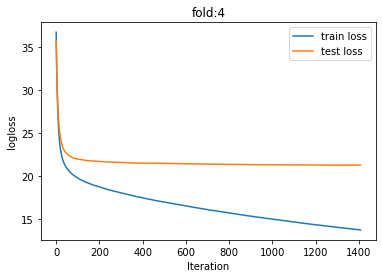

[I 2022-05-28 20:05:30,233] A new study created in memory with name: no-name-ecbb92c8-b321-4f15-b449-eae57189aa04


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 326.904	Test's l2: 1017.53


[I 2022-05-28 20:05:40,831] Trial 0 finished with value: 25.349299241509065 and parameters: {'learning_rate': 0.9855667741215816, 'num_leaves': 95, 'tree_learner': 'data', 'reg_alpha': 2.313178984982949, 'reg_lambda': 1.3158173723056636e-06, 'colsample_bytree': 0.5797360706823113, 'subsample': 0.6046447760793646, 'subsample_freq': 7, 'min_data_in_leaf': 10}. Best is trial 0 with value: 25.349299241509065.


Early stopping, best iteration is:
[5]	Train's l2: 507.1	Test's l2: 642.587
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 218.945	Test's l2: 590.471


[I 2022-05-28 20:05:48,140] Trial 1 finished with value: 23.190014778163494 and parameters: {'learning_rate': 0.6676430302148904, 'num_leaves': 90, 'tree_learner': 'feature', 'reg_alpha': 0.0002544094497957078, 'reg_lambda': 0.0005005894090031086, 'colsample_bytree': 0.9831311529037481, 'subsample': 0.8822229471620173, 'subsample_freq': 6, 'min_data_in_leaf': 66}. Best is trial 1 with value: 23.190014778163494.


Early stopping, best iteration is:
[11]	Train's l2: 406.563	Test's l2: 537.777
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 313.971	Test's l2: 1053.42


[I 2022-05-28 20:05:59,012] Trial 2 finished with value: 25.067655849384597 and parameters: {'learning_rate': 0.8483119422488306, 'num_leaves': 148, 'tree_learner': 'voting', 'reg_alpha': 5.287490390674201, 'reg_lambda': 4.4070751487877446e-08, 'colsample_bytree': 0.5816873526793456, 'subsample': 0.49450695529894306, 'subsample_freq': 7, 'min_data_in_leaf': 42}. Best is trial 1 with value: 23.190014778163494.


Early stopping, best iteration is:
[4]	Train's l2: 499.627	Test's l2: 628.387
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 393.953	Test's l2: 1311.59


[I 2022-05-28 20:06:09,671] Trial 3 finished with value: 24.828545650522326 and parameters: {'learning_rate': 0.8489609600418168, 'num_leaves': 175, 'tree_learner': 'serial', 'reg_alpha': 7.379333494582987e-06, 'reg_lambda': 5.3765128085799214e-05, 'colsample_bytree': 0.6976139741241125, 'subsample': 0.4222777976368772, 'subsample_freq': 5, 'min_data_in_leaf': 45}. Best is trial 1 with value: 23.190014778163494.


Early stopping, best iteration is:
[3]	Train's l2: 501.136	Test's l2: 616.457
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 246.656	Test's l2: 619.754


[I 2022-05-28 20:06:15,468] Trial 4 finished with value: 23.42193533544811 and parameters: {'learning_rate': 0.7809647388167095, 'num_leaves': 73, 'tree_learner': 'data', 'reg_alpha': 0.0003131982695889571, 'reg_lambda': 4.281017967351535e-05, 'colsample_bytree': 0.8167333632324016, 'subsample': 0.9036484674733439, 'subsample_freq': 1, 'min_data_in_leaf': 100}. Best is trial 1 with value: 23.190014778163494.


Early stopping, best iteration is:
[8]	Train's l2: 446.535	Test's l2: 548.587
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 194.748	Test's l2: 604.265


[I 2022-05-28 20:06:30,676] Trial 5 finished with value: 22.70210108947291 and parameters: {'learning_rate': 0.3833259338887469, 'num_leaves': 233, 'tree_learner': 'data', 'reg_alpha': 4.882471028567795e-05, 'reg_lambda': 3.1739599684455273, 'colsample_bytree': 0.7222821400511384, 'subsample': 0.4023704112247306, 'subsample_freq': 1, 'min_data_in_leaf': 66}. Best is trial 5 with value: 22.70210108947291.


Early stopping, best iteration is:
[13]	Train's l2: 372.448	Test's l2: 515.385
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 339.577	Test's l2: 469.048
[200]	Train's l2: 289.147	Test's l2: 462.331
[300]	Train's l2: 254.743	Test's l2: 459.567
[400]	Train's l2: 227.415	Test's l2: 458.09
[500]	Train's l2: 205.064	Test's l2: 457.323
Early stopping, best iteration is:
[488]	Train's l2: 207.504	Test's l2: 457.13


[I 2022-05-28 20:06:58,842] Trial 6 finished with value: 21.38060737594338 and parameters: {'learning_rate': 0.12538708573744609, 'num_leaves': 67, 'tree_learner': 'voting', 'reg_alpha': 1.2786544969565093e-05, 'reg_lambda': 1.1491615760142176e-06, 'colsample_bytree': 0.46083893751824195, 'subsample': 0.8035957791967714, 'subsample_freq': 5, 'min_data_in_leaf': 37}. Best is trial 6 with value: 21.38060737594338.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 328.262	Test's l2: 511.465


[I 2022-05-28 20:07:05,664] Trial 7 finished with value: 22.547395025078806 and parameters: {'learning_rate': 0.45534827638538067, 'num_leaves': 38, 'tree_learner': 'voting', 'reg_alpha': 0.00022326144727459268, 'reg_lambda': 4.681378745904272e-05, 'colsample_bytree': 0.7321917008899645, 'subsample': 0.6742555808912198, 'subsample_freq': 4, 'min_data_in_leaf': 89}. Best is trial 6 with value: 21.38060737594338.


Early stopping, best iteration is:
[68]	Train's l2: 354.297	Test's l2: 508.385
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 288.722	Test's l2: 708.008


[I 2022-05-28 20:07:11,426] Trial 8 finished with value: 24.49048326034749 and parameters: {'learning_rate': 0.8972616321463959, 'num_leaves': 67, 'tree_learner': 'voting', 'reg_alpha': 4.459442211691655e-07, 'reg_lambda': 0.00472762304428572, 'colsample_bytree': 0.6385645383167045, 'subsample': 0.7585483739418917, 'subsample_freq': 5, 'min_data_in_leaf': 65}. Best is trial 6 with value: 21.38060737594338.


Early stopping, best iteration is:
[13]	Train's l2: 446.378	Test's l2: 599.784
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 359.755	Test's l2: 1286.99


[I 2022-05-28 20:07:22,417] Trial 9 finished with value: 25.137170506568513 and parameters: {'learning_rate': 0.8552587598239924, 'num_leaves': 147, 'tree_learner': 'feature', 'reg_alpha': 1.3849819520882445, 'reg_lambda': 3.1922788235008105e-05, 'colsample_bytree': 0.49208985850910936, 'subsample': 0.46597982391925924, 'subsample_freq': 2, 'min_data_in_leaf': 10}. Best is trial 6 with value: 21.38060737594338.


Early stopping, best iteration is:
[5]	Train's l2: 506.013	Test's l2: 631.877
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 500.973	Test's l2: 537.661
[200]	Train's l2: 464.619	Test's l2: 512.192
[300]	Train's l2: 443.265	Test's l2: 498.18
[400]	Train's l2: 429.022	Test's l2: 488.211
[500]	Train's l2: 417.117	Test's l2: 481.189
[600]	Train's l2: 408.084	Test's l2: 475.914
[700]	Train's l2: 400.348	Test's l2: 472.48
[800]	Train's l2: 394.165	Test's l2: 469.697
[900]	Train's l2: 388.679	Test's l2: 467.632
[1000]	Train's l2: 383.58	Test's l2: 465.169
[1100]	Train's l2: 378.56	Test's l2: 463.869
[1200]	Train's l2: 373.882	Test's l2: 462.073
[1300]	Train's l2: 369.619	Test's l2: 461.304
[1400]	Train's l2: 365.626	Test's l2: 460.512
[1500]	Train's l2: 361.774	Test's l2: 459.545


[I 2022-05-28 20:07:53,141] Trial 10 finished with value: 21.330734905550393 and parameters: {'learning_rate': 0.10133028879320488, 'num_leaves': 6, 'tree_learner': 'serial', 'reg_alpha': 2.2398639348476215e-08, 'reg_lambda': 1.6052968957383845e-08, 'colsample_bytree': 0.4080057916984067, 'subsample': 0.9955850647902547, 'subsample_freq': 3, 'min_data_in_leaf': 27}. Best is trial 10 with value: 21.330734905550393.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 640.521	Test's l2: 669.771
[200]	Train's l2: 599.709	Test's l2: 628.292
[300]	Train's l2: 581.5	Test's l2: 609.667
[400]	Train's l2: 571.147	Test's l2: 598.781
[500]	Train's l2: 564.035	Test's l2: 591.448
[600]	Train's l2: 558.476	Test's l2: 585.199
[700]	Train's l2: 553.957	Test's l2: 580.638
[800]	Train's l2: 550.141	Test's l2: 577.163
[900]	Train's l2: 546.836	Test's l2: 573.71
[1000]	Train's l2: 543.979	Test's l2: 571.056
[1100]	Train's l2: 541.435	Test's l2: 569.125
[1200]	Train's l2: 539.178	Test's l2: 567.091
[1300]	Train's l2: 537.153	Test's l2: 565.331
[1400]	Train's l2: 535.336	Test's l2: 563.999
[1500]	Train's l2: 533.684	Test's l2: 562.843
[1600]	Train's l2: 532.169	Test's l2: 561.363
[1700]	Train's l2: 530.792	Test

[I 2022-05-28 20:08:51,756] Trial 11 finished with value: 23.331895870283734 and parameters: {'learning_rate': 0.10181997628768004, 'num_leaves': 2, 'tree_learner': 'serial', 'reg_alpha': 2.5249927846438e-08, 'reg_lambda': 1.2288419363456046e-08, 'colsample_bytree': 0.42154054538562075, 'subsample': 0.9902959774404689, 'subsample_freq': 3, 'min_data_in_leaf': 28}. Best is trial 10 with value: 21.330734905550393.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 637.14	Test's l2: 665.25
[200]	Train's l2: 597.447	Test's l2: 624.815
[300]	Train's l2: 579.742	Test's l2: 608.123
[400]	Train's l2: 569.524	Test's l2: 597.65
[500]	Train's l2: 562.067	Test's l2: 589.214
[600]	Train's l2: 556.245	Test's l2: 582.819
[700]	Train's l2: 551.502	Test's l2: 577.994
[800]	Train's l2: 547.511	Test's l2: 574.075
[900]	Train's l2: 544.112	Test's l2: 570.984
[1000]	Train's l2: 541.133	Test's l2: 567.543
[1100]	Train's l2: 538.476	Test's l2: 565.518
[1200]	Train's l2: 536.163	Test's l2: 563.485
[1300]	Train's l2: 534.064	Test's l2: 561.646
[1400]	Train's l2: 532.203	Test's l2: 560.723
[1500]	Train's l2: 530.444	Test's l2: 559.014
[1600]	Train's l2: 528.872	Test's l2: 557.771
[1700]	Train's l2: 527.456	Test

[I 2022-05-28 20:09:33,621] Trial 12 finished with value: 23.29156020816429 and parameters: {'learning_rate': 0.10925545203972015, 'num_leaves': 2, 'tree_learner': 'serial', 'reg_alpha': 0.0192481406891532, 'reg_lambda': 2.7365328963458717e-07, 'colsample_bytree': 0.40216712404939775, 'subsample': 0.8159134449413826, 'subsample_freq': 3, 'min_data_in_leaf': 29}. Best is trial 10 with value: 21.330734905550393.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 343.292	Test's l2: 476.552
[200]	Train's l2: 292.124	Test's l2: 474.866
[300]	Train's l2: 255.751	Test's l2: 476.115
Early stopping, best iteration is:
[206]	Train's l2: 289.837	Test's l2: 474.597


[I 2022-05-28 20:09:45,446] Trial 13 finished with value: 21.785256119550763 and parameters: {'learning_rate': 0.27224726948067157, 'num_leaves': 35, 'tree_learner': 'voting', 'reg_alpha': 1.2403284908788789e-08, 'reg_lambda': 1.0430901143427071e-06, 'colsample_bytree': 0.49999839408375457, 'subsample': 0.9939270309253232, 'subsample_freq': 4, 'min_data_in_leaf': 29}. Best is trial 10 with value: 21.330734905550393.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 337.098	Test's l2: 480.379
[200]	Train's l2: 284.416	Test's l2: 478.781


[I 2022-05-28 20:09:55,811] Trial 14 finished with value: 21.866862421220812 and parameters: {'learning_rate': 0.27027782443610615, 'num_leaves': 37, 'tree_learner': 'serial', 'reg_alpha': 5.092168748337174e-07, 'reg_lambda': 1.194652655687022e-07, 'colsample_bytree': 0.49287929272844416, 'subsample': 0.8841256056395188, 'subsample_freq': 3, 'min_data_in_leaf': 18}. Best is trial 10 with value: 21.330734905550393.


Early stopping, best iteration is:
[191]	Train's l2: 288.041	Test's l2: 478.16
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 255.56	Test's l2: 482.196


[I 2022-05-28 20:10:10,092] Trial 15 finished with value: 21.92066226818256 and parameters: {'learning_rate': 0.22532944115505496, 'num_leaves': 114, 'tree_learner': 'serial', 'reg_alpha': 9.74558417213346e-07, 'reg_lambda': 2.2367446292534726e-06, 'colsample_bytree': 0.8617627779291599, 'subsample': 0.6874180913709468, 'subsample_freq': 5, 'min_data_in_leaf': 52}. Best is trial 10 with value: 21.330734905550393.


Early stopping, best iteration is:
[67]	Train's l2: 291.608	Test's l2: 480.515
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 302.458	Test's l2: 522.244


[I 2022-05-28 20:10:15,765] Trial 16 finished with value: 22.611480482695846 and parameters: {'learning_rate': 0.4959398898645069, 'num_leaves': 51, 'tree_learner': 'voting', 'reg_alpha': 0.04900581826033932, 'reg_lambda': 0.3377670177618374, 'colsample_bytree': 0.45561566590493346, 'subsample': 0.7868517354727987, 'subsample_freq': 2, 'min_data_in_leaf': 37}. Best is trial 10 with value: 21.330734905550393.


Early stopping, best iteration is:
[26]	Train's l2: 399.531	Test's l2: 511.279
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 401.535	Test's l2: 487.683
[200]	Train's l2: 363.253	Test's l2: 477.171
[300]	Train's l2: 338.069	Test's l2: 471.431
[400]	Train's l2: 317.553	Test's l2: 469.685


[I 2022-05-28 20:10:24,912] Trial 17 finished with value: 21.64922084635318 and parameters: {'learning_rate': 0.20790701191211247, 'num_leaves': 17, 'tree_learner': 'feature', 'reg_alpha': 7.709382584874814e-06, 'reg_lambda': 0.012476281476404392, 'colsample_bytree': 0.5590645152834424, 'subsample': 0.6097729925592078, 'subsample_freq': 4, 'min_data_in_leaf': 19}. Best is trial 10 with value: 21.330734905550393.


Early stopping, best iteration is:
[364]	Train's l2: 324.24	Test's l2: 468.689
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 156.353	Test's l2: 513.802


[I 2022-05-28 20:10:42,891] Trial 18 finished with value: 22.243647366941623 and parameters: {'learning_rate': 0.3802014930686509, 'num_leaves': 208, 'tree_learner': 'voting', 'reg_alpha': 0.007990579304591818, 'reg_lambda': 1.222419578990802e-08, 'colsample_bytree': 0.540965695534777, 'subsample': 0.9395562125838413, 'subsample_freq': 6, 'min_data_in_leaf': 57}. Best is trial 10 with value: 21.330734905550393.


Early stopping, best iteration is:
[21]	Train's l2: 315.249	Test's l2: 494.78
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 211.23	Test's l2: 599.433


[I 2022-05-28 20:10:51,158] Trial 19 finished with value: 23.027889368784237 and parameters: {'learning_rate': 0.6159276606626867, 'num_leaves': 112, 'tree_learner': 'serial', 'reg_alpha': 7.316417356945554e-08, 'reg_lambda': 2.5949417358567482e-06, 'colsample_bytree': 0.6417796880074196, 'subsample': 0.8165300504191506, 'subsample_freq': 6, 'min_data_in_leaf': 77}. Best is trial 10 with value: 21.330734905550393.


Early stopping, best iteration is:
[14]	Train's l2: 387.223	Test's l2: 530.284
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 318.099	Test's l2: 473.009
[200]	Train's l2: 260.571	Test's l2: 472.724


[I 2022-05-28 20:11:04,179] Trial 20 finished with value: 21.707354425631124 and parameters: {'learning_rate': 0.16438568977016363, 'num_leaves': 69, 'tree_learner': 'voting', 'reg_alpha': 8.098525234469847e-06, 'reg_lambda': 2.417771068297245e-07, 'colsample_bytree': 0.4001987381356355, 'subsample': 0.7435776885055835, 'subsample_freq': 2, 'min_data_in_leaf': 5}. Best is trial 10 with value: 21.330734905550393.


Early stopping, best iteration is:
[114]	Train's l2: 308.18	Test's l2: 471.209
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 410.45	Test's l2: 487.858
[200]	Train's l2: 373.713	Test's l2: 475.868
[300]	Train's l2: 349.304	Test's l2: 469.192
[400]	Train's l2: 330.914	Test's l2: 468.315
[500]	Train's l2: 315.188	Test's l2: 468.751
[600]	Train's l2: 301.742	Test's l2: 467.399
Early stopping, best iteration is:
[559]	Train's l2: 307.094	Test's l2: 466.77


[I 2022-05-28 20:11:17,115] Trial 21 finished with value: 21.6048593605426 and parameters: {'learning_rate': 0.19738321231868056, 'num_leaves': 15, 'tree_learner': 'feature', 'reg_alpha': 1.1073516362263967e-05, 'reg_lambda': 0.028223392154425455, 'colsample_bytree': 0.5457033453668826, 'subsample': 0.5848409643400626, 'subsample_freq': 4, 'min_data_in_leaf': 20}. Best is trial 10 with value: 21.330734905550393.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 378.444	Test's l2: 485.328
[200]	Train's l2: 336.328	Test's l2: 484.376


[I 2022-05-28 20:11:24,408] Trial 22 finished with value: 21.959385703295833 and parameters: {'learning_rate': 0.30946933028370605, 'num_leaves': 21, 'tree_learner': 'feature', 'reg_alpha': 0.001471618117653334, 'reg_lambda': 0.09643626861008778, 'colsample_bytree': 0.47178570828844857, 'subsample': 0.5604261268544807, 'subsample_freq': 4, 'min_data_in_leaf': 20}. Best is trial 10 with value: 21.330734905550393.


Early stopping, best iteration is:
[168]	Train's l2: 347.783	Test's l2: 482.215
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 338.277	Test's l2: 472.001
[200]	Train's l2: 288.371	Test's l2: 470.711
Early stopping, best iteration is:
[184]	Train's l2: 295.168	Test's l2: 470.337


[I 2022-05-28 20:11:38,100] Trial 23 finished with value: 21.687257406364363 and parameters: {'learning_rate': 0.16924996565237804, 'num_leaves': 54, 'tree_learner': 'feature', 'reg_alpha': 1.3571027189258367e-07, 'reg_lambda': 0.0010697499920583793, 'colsample_bytree': 0.5277873742661013, 'subsample': 0.624087957387087, 'subsample_freq': 3, 'min_data_in_leaf': 35}. Best is trial 10 with value: 21.330734905550393.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 388.45	Test's l2: 492.599
[200]	Train's l2: 348.668	Test's l2: 491.672


[I 2022-05-28 20:11:44,187] Trial 24 finished with value: 22.153237491909344 and parameters: {'learning_rate': 0.3500128632888726, 'num_leaves': 18, 'tree_learner': 'feature', 'reg_alpha': 3.520307651049592e-05, 'reg_lambda': 0.04262829798223016, 'colsample_bytree': 0.45130450551397205, 'subsample': 0.5373646123544545, 'subsample_freq': 5, 'min_data_in_leaf': 24}. Best is trial 10 with value: 21.330734905550393.


Early stopping, best iteration is:
[181]	Train's l2: 354.096	Test's l2: 490.766
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 304.025	Test's l2: 471.406
[200]	Train's l2: 245.023	Test's l2: 468.943
Early stopping, best iteration is:
[175]	Train's l2: 257.569	Test's l2: 467.975


[I 2022-05-28 20:12:03,888] Trial 25 finished with value: 21.63272879118416 and parameters: {'learning_rate': 0.1564681839515809, 'num_leaves': 89, 'tree_learner': 'serial', 'reg_alpha': 1.892600644574806e-06, 'reg_lambda': 0.8621103423028764, 'colsample_bytree': 0.61740333391771, 'subsample': 0.7275633805286267, 'subsample_freq': 4, 'min_data_in_leaf': 49}. Best is trial 10 with value: 21.330734905550393.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 369.835	Test's l2: 473.28
[200]	Train's l2: 326.431	Test's l2: 462.035
[300]	Train's l2: 297.193	Test's l2: 457.757
[400]	Train's l2: 274.17	Test's l2: 457.283
[500]	Train's l2: 254.342	Test's l2: 456.997
[600]	Train's l2: 237.223	Test's l2: 456.057
[700]	Train's l2: 222.465	Test's l2: 456.819
Early stopping, best iteration is:
[611]	Train's l2: 235.578	Test's l2: 456.009


[I 2022-05-28 20:12:32,616] Trial 26 finished with value: 21.354373453199898 and parameters: {'learning_rate': 0.10108906804664915, 'num_leaves': 51, 'tree_learner': 'feature', 'reg_alpha': 1.0188343143984503e-07, 'reg_lambda': 9.183560235081498e-06, 'colsample_bytree': 0.44249700043110357, 'subsample': 0.6573910445014663, 'subsample_freq': 3, 'min_data_in_leaf': 38}. Best is trial 10 with value: 21.330734905550393.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 369.407	Test's l2: 470.45
[200]	Train's l2: 326.332	Test's l2: 461.879
[300]	Train's l2: 297.545	Test's l2: 459.259
[400]	Train's l2: 274.007	Test's l2: 456.727
[500]	Train's l2: 254.166	Test's l2: 456.014
[600]	Train's l2: 237.278	Test's l2: 454.556
[700]	Train's l2: 222.152	Test's l2: 452.941
[800]	Train's l2: 208.155	Test's l2: 453.255
Early stopping, best iteration is:
[712]	Train's l2: 220.45	Test's l2: 452.736


[I 2022-05-28 20:13:04,658] Trial 27 finished with value: 21.277596877176542 and parameters: {'learning_rate': 0.10018518700375265, 'num_leaves': 52, 'tree_learner': 'data', 'reg_alpha': 1.490240820245493e-07, 'reg_lambda': 5.508091558465299e-06, 'colsample_bytree': 0.4414718952933037, 'subsample': 0.6443485002914509, 'subsample_freq': 2, 'min_data_in_leaf': 36}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 326.058	Test's l2: 477.956


[I 2022-05-28 20:13:12,437] Trial 28 finished with value: 21.848136441347066 and parameters: {'learning_rate': 0.25778687465615313, 'num_leaves': 51, 'tree_learner': 'data', 'reg_alpha': 8.72213860671256e-08, 'reg_lambda': 8.936860863968778e-06, 'colsample_bytree': 0.4317052243323314, 'subsample': 0.6790180749963715, 'subsample_freq': 2, 'min_data_in_leaf': 42}. Best is trial 27 with value: 21.277596877176542.


[200]	Train's l2: 270.255	Test's l2: 483.097
Early stopping, best iteration is:
[102]	Train's l2: 324.782	Test's l2: 477.341
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 239.502	Test's l2: 551.067


[I 2022-05-28 20:13:20,289] Trial 29 finished with value: 22.614246662473853 and parameters: {'learning_rate': 0.4366025622679234, 'num_leaves': 106, 'tree_learner': 'data', 'reg_alpha': 1.2783206741189431e-08, 'reg_lambda': 8.603620062649277e-06, 'colsample_bytree': 0.5956432786670678, 'subsample': 0.6292979715381799, 'subsample_freq': 1, 'min_data_in_leaf': 58}. Best is trial 27 with value: 21.277596877176542.


Early stopping, best iteration is:
[16]	Train's l2: 386.045	Test's l2: 511.404
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 340.902	Test's l2: 490.272


[I 2022-05-28 20:13:26,778] Trial 30 finished with value: 22.137655110432974 and parameters: {'learning_rate': 0.32190497618530833, 'num_leaves': 35, 'tree_learner': 'data', 'reg_alpha': 2.372847937556526e-07, 'reg_lambda': 0.0018198061515783456, 'colsample_bytree': 0.5185618829899445, 'subsample': 0.6429001820637025, 'subsample_freq': 3, 'min_data_in_leaf': 33}. Best is trial 27 with value: 21.277596877176542.


Early stopping, best iteration is:
[95]	Train's l2: 344.265	Test's l2: 490.076
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 340.152	Test's l2: 467.706
[200]	Train's l2: 289.391	Test's l2: 460.26
[300]	Train's l2: 254.393	Test's l2: 456.268
[400]	Train's l2: 227.078	Test's l2: 456.258
Early stopping, best iteration is:
[315]	Train's l2: 249.695	Test's l2: 455.861


[I 2022-05-28 20:13:50,065] Trial 31 finished with value: 21.350889959108116 and parameters: {'learning_rate': 0.10353092603521367, 'num_leaves': 79, 'tree_learner': 'data', 'reg_alpha': 5.0326403307232994e-08, 'reg_lambda': 8.088090091808936e-07, 'colsample_bytree': 0.4604005853246309, 'subsample': 0.8358147676334662, 'subsample_freq': 2, 'min_data_in_leaf': 38}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 289.021	Test's l2: 467.108
[200]	Train's l2: 227.301	Test's l2: 469.205


[I 2022-05-28 20:14:04,441] Trial 32 finished with value: 21.589066596787845 and parameters: {'learning_rate': 0.21122782643113763, 'num_leaves': 87, 'tree_learner': 'data', 'reg_alpha': 3.9696499419788077e-08, 'reg_lambda': 0.0001600892619367664, 'colsample_bytree': 0.43222934129015683, 'subsample': 0.9504376102683406, 'subsample_freq': 2, 'min_data_in_leaf': 42}. Best is trial 27 with value: 21.277596877176542.


Early stopping, best iteration is:
[123]	Train's l2: 271.218	Test's l2: 466.088
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 319.874	Test's l2: 467.716
[200]	Train's l2: 262.066	Test's l2: 461.173
[300]	Train's l2: 224.041	Test's l2: 458.829
[400]	Train's l2: 194.687	Test's l2: 457.621
[500]	Train's l2: 171.201	Test's l2: 457.626
[600]	Train's l2: 152.155	Test's l2: 457.199
[700]	Train's l2: 135.188	Test's l2: 456.756
Early stopping, best iteration is:
[697]	Train's l2: 135.646	Test's l2: 456.578


[I 2022-05-28 20:14:49,790] Trial 33 finished with value: 21.367689346812316 and parameters: {'learning_rate': 0.1151508101490415, 'num_leaves': 80, 'tree_learner': 'data', 'reg_alpha': 1.7613787240602017e-06, 'reg_lambda': 7.876795503465227e-08, 'colsample_bytree': 0.9737424549253159, 'subsample': 0.862222766599063, 'subsample_freq': 2, 'min_data_in_leaf': 12}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 188.873	Test's l2: 633.656


[I 2022-05-28 20:15:00,408] Trial 34 finished with value: 23.63543033410862 and parameters: {'learning_rate': 0.6792526611389585, 'num_leaves': 134, 'tree_learner': 'data', 'reg_alpha': 4.952908593985792e-08, 'reg_lambda': 6.270860982084884e-06, 'colsample_bytree': 0.4683224692859553, 'subsample': 0.851086693716027, 'subsample_freq': 3, 'min_data_in_leaf': 47}. Best is trial 27 with value: 21.277596877176542.


Early stopping, best iteration is:
[14]	Train's l2: 385.267	Test's l2: 558.634
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 336.645	Test's l2: 468.46
[200]	Train's l2: 285.516	Test's l2: 463.544
[300]	Train's l2: 249.95	Test's l2: 461.335
[400]	Train's l2: 222.363	Test's l2: 462.762
Early stopping, best iteration is:
[360]	Train's l2: 233.043	Test's l2: 461.331


[I 2022-05-28 20:15:20,375] Trial 35 finished with value: 21.478618922825618 and parameters: {'learning_rate': 0.1598292678055359, 'num_leaves': 55, 'tree_learner': 'data', 'reg_alpha': 2.9788768761451717e-07, 'reg_lambda': 6.321600160074705e-07, 'colsample_bytree': 0.5759946028957483, 'subsample': 0.9268508884699471, 'subsample_freq': 1, 'min_data_in_leaf': 38}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 260.841	Test's l2: 934.831


[I 2022-05-28 20:15:28,534] Trial 36 finished with value: 25.06283991521712 and parameters: {'learning_rate': 0.9720281573297369, 'num_leaves': 100, 'tree_learner': 'data', 'reg_alpha': 1.9762865186674904e-06, 'reg_lambda': 4.037863436318192e-08, 'colsample_bytree': 0.6786388161349292, 'subsample': 0.7133276434491156, 'subsample_freq': 2, 'min_data_in_leaf': 31}. Best is trial 27 with value: 21.277596877176542.


Early stopping, best iteration is:
[8]	Train's l2: 468.328	Test's l2: 628.146
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 204.536	Test's l2: 504.31


[I 2022-05-28 20:15:43,269] Trial 37 finished with value: 22.14990351695178 and parameters: {'learning_rate': 0.23912427979537015, 'num_leaves': 186, 'tree_learner': 'data', 'reg_alpha': 2.075868697305352e-08, 'reg_lambda': 0.0001853852778007338, 'colsample_bytree': 0.809850826559122, 'subsample': 0.5220894703138257, 'subsample_freq': 1, 'min_data_in_leaf': 25}. Best is trial 27 with value: 21.277596877176542.


Early stopping, best iteration is:
[25]	Train's l2: 334.475	Test's l2: 490.618
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 285.648	Test's l2: 461.866
[200]	Train's l2: 221.786	Test's l2: 463.764


[I 2022-05-28 20:16:02,792] Trial 38 finished with value: 21.47544188720966 and parameters: {'learning_rate': 0.1397011932084924, 'num_leaves': 129, 'tree_learner': 'feature', 'reg_alpha': 1.0536385383961788e-08, 'reg_lambda': 2.4057885557023243e-05, 'colsample_bytree': 0.5043604157361049, 'subsample': 0.657446259555893, 'subsample_freq': 3, 'min_data_in_leaf': 43}. Best is trial 27 with value: 21.277596877176542.


Early stopping, best iteration is:
[114]	Train's l2: 273.753	Test's l2: 461.195
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 168.156	Test's l2: 512.446


[I 2022-05-28 20:16:23,474] Trial 39 finished with value: 22.198930628879623 and parameters: {'learning_rate': 0.2985261636336662, 'num_leaves': 246, 'tree_learner': 'serial', 'reg_alpha': 1.5218843523132872e-07, 'reg_lambda': 4.3779903321184427e-07, 'colsample_bytree': 0.4032379977339446, 'subsample': 0.7698026249090868, 'subsample_freq': 2, 'min_data_in_leaf': 57}. Best is trial 27 with value: 21.277596877176542.


Early stopping, best iteration is:
[38]	Train's l2: 271.462	Test's l2: 492.793
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 304.234	Test's l2: 687.963


[I 2022-05-28 20:16:32,734] Trial 40 finished with value: 23.746195996570354 and parameters: {'learning_rate': 0.7193030245691288, 'num_leaves': 74, 'tree_learner': 'data', 'reg_alpha': 6.897642016262225e-05, 'reg_lambda': 5.28254272933237e-08, 'colsample_bytree': 0.44222749052146737, 'subsample': 0.5815037221821717, 'subsample_freq': 3, 'min_data_in_leaf': 48}. Best is trial 27 with value: 21.277596877176542.


Early stopping, best iteration is:
[16]	Train's l2: 431.336	Test's l2: 563.882
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 319.685	Test's l2: 467.883
[200]	Train's l2: 262.544	Test's l2: 461.659
[300]	Train's l2: 223.895	Test's l2: 459.361
[400]	Train's l2: 193.806	Test's l2: 456.992
[500]	Train's l2: 169.816	Test's l2: 457.309
Early stopping, best iteration is:
[412]	Train's l2: 190.545	Test's l2: 456.645


[I 2022-05-28 20:17:05,351] Trial 41 finished with value: 21.369259349235467 and parameters: {'learning_rate': 0.1179061935080849, 'num_leaves': 79, 'tree_learner': 'data', 'reg_alpha': 1.271964590710191e-06, 'reg_lambda': 8.998217030365005e-08, 'colsample_bytree': 0.9748613096852732, 'subsample': 0.8574963223451517, 'subsample_freq': 2, 'min_data_in_leaf': 13}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 348.405	Test's l2: 471.217
[200]	Train's l2: 298.795	Test's l2: 463.15
[300]	Train's l2: 265.848	Test's l2: 460.202
[400]	Train's l2: 238.244	Test's l2: 457.021
[500]	Train's l2: 215.97	Test's l2: 455.759
[600]	Train's l2: 197.307	Test's l2: 455.35
[700]	Train's l2: 180.765	Test's l2: 455.018
[800]	Train's l2: 166.44	Test's l2: 455.249
Early stopping, best iteration is:
[787]	Train's l2: 168.194	Test's l2: 454.881


[I 2022-05-28 20:17:46,128] Trial 42 finished with value: 21.327934246820124 and parameters: {'learning_rate': 0.10379157319868258, 'num_leaves': 60, 'tree_learner': 'data', 'reg_alpha': 4.989746447665694e-07, 'reg_lambda': 2.39499597654626e-08, 'colsample_bytree': 0.8937538833122639, 'subsample': 0.9661272640848803, 'subsample_freq': 1, 'min_data_in_leaf': 14}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 313.579	Test's l2: 480.733
[200]	Train's l2: 256.065	Test's l2: 476.854
[300]	Train's l2: 216.045	Test's l2: 475.904
Early stopping, best iteration is:
[291]	Train's l2: 219.285	Test's l2: 475.45


[I 2022-05-28 20:18:03,401] Trial 43 finished with value: 21.804817090874682 and parameters: {'learning_rate': 0.18717463324059463, 'num_leaves': 62, 'tree_learner': 'data', 'reg_alpha': 4.6650885448250105e-08, 'reg_lambda': 1.9608807907913482e-08, 'colsample_bytree': 0.9212408979050826, 'subsample': 0.9693589614208565, 'subsample_freq': 1, 'min_data_in_leaf': 39}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 368.247	Test's l2: 474.834
[200]	Train's l2: 323.022	Test's l2: 464.952
[300]	Train's l2: 293.528	Test's l2: 460.881
[400]	Train's l2: 269.706	Test's l2: 458.705
[500]	Train's l2: 249.336	Test's l2: 456.656
[600]	Train's l2: 231.863	Test's l2: 456.185
Early stopping, best iteration is:
[572]	Train's l2: 236.861	Test's l2: 455.889


[I 2022-05-28 20:18:28,513] Trial 44 finished with value: 21.351550409524688 and parameters: {'learning_rate': 0.10207894774440172, 'num_leaves': 46, 'tree_learner': 'data', 'reg_alpha': 5.652424126800713e-07, 'reg_lambda': 3.44693789813417e-06, 'colsample_bytree': 0.8405694902579229, 'subsample': 0.9173972998833474, 'subsample_freq': 1, 'min_data_in_leaf': 24}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 377.15	Test's l2: 483.057
[200]	Train's l2: 333.978	Test's l2: 472.558
[300]	Train's l2: 303.197	Test's l2: 469.469
[400]	Train's l2: 279.015	Test's l2: 467.901
[500]	Train's l2: 258.776	Test's l2: 467.048
[600]	Train's l2: 242.306	Test's l2: 465.542
[700]	Train's l2: 226.703	Test's l2: 465.499
Early stopping, best iteration is:
[601]	Train's l2: 242.123	Test's l2: 465.283


[I 2022-05-28 20:18:47,844] Trial 45 finished with value: 21.570423784388304 and parameters: {'learning_rate': 0.14812253530589312, 'num_leaves': 29, 'tree_learner': 'data', 'reg_alpha': 6.788084005799528e-07, 'reg_lambda': 1.6764214810456566e-07, 'colsample_bytree': 0.7815611795475633, 'subsample': 0.9124659806138442, 'subsample_freq': 1, 'min_data_in_leaf': 6}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 284.571	Test's l2: 533.756


[I 2022-05-28 20:18:52,861] Trial 46 finished with value: 22.778371153674446 and parameters: {'learning_rate': 0.5637755895938031, 'num_leaves': 45, 'tree_learner': 'data', 'reg_alpha': 3.868482204682824e-06, 'reg_lambda': 2.562978731450554e-06, 'colsample_bytree': 0.878796597585442, 'subsample': 0.9683519335875314, 'subsample_freq': 1, 'min_data_in_leaf': 24}. Best is trial 27 with value: 21.277596877176542.


Early stopping, best iteration is:
[30]	Train's l2: 377.993	Test's l2: 518.854
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 532.367	Test's l2: 579.025
[200]	Train's l2: 495.384	Test's l2: 543.921
[300]	Train's l2: 475.126	Test's l2: 527.591
[400]	Train's l2: 461.578	Test's l2: 517.395
[500]	Train's l2: 451.64	Test's l2: 512.135
[600]	Train's l2: 444.063	Test's l2: 507.322
[700]	Train's l2: 437.179	Test's l2: 502.871
[800]	Train's l2: 431.281	Test's l2: 498.863
[900]	Train's l2: 426.131	Test's l2: 494.476
[1000]	Train's l2: 421.963	Test's l2: 492.834
[1100]	Train's l2: 418.018	Test's l2: 490.366
[1200]	Train's l2: 414.023	Test's l2: 486.852
[1300]	Train's l2: 410.564	Test's l2: 484.338
[1400]	Train's l2: 407.382	Test's l2: 483.009
[1500]	Train's l2: 404.4	Test's l2: 481.61

[I 2022-05-28 20:19:12,495] Trial 47 finished with value: 21.853529165484808 and parameters: {'learning_rate': 0.19626143910418642, 'num_leaves': 3, 'tree_learner': 'data', 'reg_alpha': 2.941565510685949e-07, 'reg_lambda': 2.453091360268484e-08, 'colsample_bytree': 0.9321637821525167, 'subsample': 0.8914550509805845, 'subsample_freq': 1, 'min_data_in_leaf': 17}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 358.618	Test's l2: 479.821
[200]	Train's l2: 311.157	Test's l2: 472.72
[300]	Train's l2: 277.003	Test's l2: 473.22


[I 2022-05-28 20:19:21,697] Trial 48 finished with value: 21.72586668844779 and parameters: {'learning_rate': 0.23340026368828387, 'num_leaves': 28, 'tree_learner': 'serial', 'reg_alpha': 3.2416857967307115e-08, 'reg_lambda': 8.022512641435043e-07, 'colsample_bytree': 0.8531956954617708, 'subsample': 0.9996044289019393, 'subsample_freq': 1, 'min_data_in_leaf': 15}. Best is trial 27 with value: 21.277596877176542.


Early stopping, best iteration is:
[240]	Train's l2: 296.398	Test's l2: 472.013
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 330.105	Test's l2: 468.367
[200]	Train's l2: 278.592	Test's l2: 465.166
[300]	Train's l2: 241.121	Test's l2: 463.58
Early stopping, best iteration is:
[292]	Train's l2: 243.75	Test's l2: 463.387


[I 2022-05-28 20:19:42,652] Trial 49 finished with value: 21.526418983019873 and parameters: {'learning_rate': 0.13698345166753353, 'num_leaves': 63, 'tree_learner': 'data', 'reg_alpha': 0.5817961376224421, 'reg_lambda': 2.8767656737255615e-07, 'colsample_bytree': 0.7689505769478862, 'subsample': 0.9647808410306097, 'subsample_freq': 2, 'min_data_in_leaf': 24}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 320.515	Test's l2: 484.567
[200]	Train's l2: 261.283	Test's l2: 485.054


[I 2022-05-28 20:19:53,796] Trial 50 finished with value: 21.967472183448983 and parameters: {'learning_rate': 0.28811355438115, 'num_leaves': 43, 'tree_learner': 'data', 'reg_alpha': 4.855433014627645e-07, 'reg_lambda': 1.8769143808461442e-05, 'colsample_bytree': 0.9347741845054053, 'subsample': 0.9137696532685207, 'subsample_freq': 2, 'min_data_in_leaf': 28}. Best is trial 27 with value: 21.277596877176542.


Early stopping, best iteration is:
[151]	Train's l2: 287.309	Test's l2: 482.57
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 318.553	Test's l2: 463.167
[200]	Train's l2: 262.639	Test's l2: 457.495
[300]	Train's l2: 224.621	Test's l2: 455.156
[400]	Train's l2: 195.309	Test's l2: 454.973
[500]	Train's l2: 171.226	Test's l2: 454.338
[600]	Train's l2: 151.733	Test's l2: 453.508
Early stopping, best iteration is:
[560]	Train's l2: 159.317	Test's l2: 453.175


[I 2022-05-28 20:20:43,234] Trial 51 finished with value: 21.287906983284184 and parameters: {'learning_rate': 0.10311314088209138, 'num_leaves': 95, 'tree_learner': 'feature', 'reg_alpha': 8.851174267430168e-08, 'reg_lambda': 5.957466395945047e-05, 'colsample_bytree': 0.904543281300922, 'subsample': 0.9473757745716163, 'subsample_freq': 3, 'min_data_in_leaf': 35}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 312.383	Test's l2: 464.184
[200]	Train's l2: 255.209	Test's l2: 458.394
[300]	Train's l2: 216.594	Test's l2: 456.548
[400]	Train's l2: 187.223	Test's l2: 455.878
[500]	Train's l2: 163.275	Test's l2: 456.538
Early stopping, best iteration is:
[407]	Train's l2: 185.219	Test's l2: 455.772


[I 2022-05-28 20:21:16,776] Trial 52 finished with value: 21.348809635843313 and parameters: {'learning_rate': 0.11381741510300734, 'num_leaves': 93, 'tree_learner': 'serial', 'reg_alpha': 1.612509821475963e-07, 'reg_lambda': 0.0001389367894713123, 'colsample_bytree': 0.9029161638031709, 'subsample': 0.9382794522897476, 'subsample_freq': 1, 'min_data_in_leaf': 33}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 282.975	Test's l2: 475.264
[200]	Train's l2: 219.421	Test's l2: 470.837
Early stopping, best iteration is:
[181]	Train's l2: 228.827	Test's l2: 470.772


[I 2022-05-28 20:21:38,456] Trial 53 finished with value: 21.697274044121684 and parameters: {'learning_rate': 0.1679226435441355, 'num_leaves': 96, 'tree_learner': 'serial', 'reg_alpha': 1.4479035705699546e-07, 'reg_lambda': 9.328380749295155e-05, 'colsample_bytree': 0.9073956062931818, 'subsample': 0.9462523121897302, 'subsample_freq': 2, 'min_data_in_leaf': 32}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 282.039	Test's l2: 465.569
[200]	Train's l2: 219.132	Test's l2: 462.487
[300]	Train's l2: 177.161	Test's l2: 461.854
Early stopping, best iteration is:
[227]	Train's l2: 206.349	Test's l2: 461.237


[I 2022-05-28 20:22:04,322] Trial 54 finished with value: 21.47642172419737 and parameters: {'learning_rate': 0.13717159375303373, 'num_leaves': 114, 'tree_learner': 'serial', 'reg_alpha': 2.4767672978092044e-08, 'reg_lambda': 0.0005522236392853161, 'colsample_bytree': 0.901681305520924, 'subsample': 0.982734024955034, 'subsample_freq': 3, 'min_data_in_leaf': 34}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 226.969	Test's l2: 473.774


[I 2022-05-28 20:22:21,227] Trial 55 finished with value: 21.766353155352082 and parameters: {'learning_rate': 0.24410437010797048, 'num_leaves': 134, 'tree_learner': 'serial', 'reg_alpha': 8.133224389741817e-08, 'reg_lambda': 5.186506898180676e-05, 'colsample_bytree': 0.9957437058897518, 'subsample': 0.8741698421591114, 'subsample_freq': 1, 'min_data_in_leaf': 51}. Best is trial 27 with value: 21.277596877176542.


[200]	Train's l2: 151.641	Test's l2: 480.694
Early stopping, best iteration is:
[100]	Train's l2: 226.969	Test's l2: 473.774
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 290.602	Test's l2: 473.599
[200]	Train's l2: 229.122	Test's l2: 476.221
Early stopping, best iteration is:
[101]	Train's l2: 289.919	Test's l2: 473.451


[I 2022-05-28 20:22:34,992] Trial 56 finished with value: 21.7589196596876 and parameters: {'learning_rate': 0.18638493946484402, 'num_leaves': 83, 'tree_learner': 'serial', 'reg_alpha': 3.7835151464663373e-06, 'reg_lambda': 0.0002637957573047771, 'colsample_bytree': 0.9535045747436173, 'subsample': 0.8338904822663431, 'subsample_freq': 2, 'min_data_in_leaf': 45}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 303.868	Test's l2: 466.824
[200]	Train's l2: 244.027	Test's l2: 460.91
[300]	Train's l2: 205.273	Test's l2: 457.799
[400]	Train's l2: 175.323	Test's l2: 458.407
Early stopping, best iteration is:
[305]	Train's l2: 203.631	Test's l2: 457.605


[I 2022-05-28 20:23:10,905] Trial 57 finished with value: 21.391700724555356 and parameters: {'learning_rate': 0.10574350240825788, 'num_leaves': 123, 'tree_learner': 'serial', 'reg_alpha': 2.3529894812463993e-08, 'reg_lambda': 7.838610629407819e-05, 'colsample_bytree': 0.8878325092625952, 'subsample': 0.8937475118100324, 'subsample_freq': 3, 'min_data_in_leaf': 95}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 228.373	Test's l2: 481.027


[I 2022-05-28 20:23:27,224] Trial 58 finished with value: 21.899146139159395 and parameters: {'learning_rate': 0.21760983683945898, 'num_leaves': 151, 'tree_learner': 'feature', 'reg_alpha': 1.899742388522141e-07, 'reg_lambda': 1.8752001548533304e-05, 'colsample_bytree': 0.4815446872271489, 'subsample': 0.9390561309582514, 'subsample_freq': 1, 'min_data_in_leaf': 28}. Best is trial 27 with value: 21.277596877176542.


Early stopping, best iteration is:
[78]	Train's l2: 252.62	Test's l2: 479.573
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 289.734	Test's l2: 469.626
[200]	Train's l2: 227.676	Test's l2: 466.365
[300]	Train's l2: 186.089	Test's l2: 465.688
[400]	Train's l2: 155.199	Test's l2: 464.431
Early stopping, best iteration is:
[390]	Train's l2: 158.17	Test's l2: 464.258


[I 2022-05-28 20:24:03,708] Trial 59 finished with value: 21.54664037237013 and parameters: {'learning_rate': 0.1393223721688616, 'num_leaves': 99, 'tree_learner': 'voting', 'reg_alpha': 1.084104482333312e-08, 'reg_lambda': 3.881339986212823e-06, 'colsample_bytree': 0.7533848766262786, 'subsample': 0.9775255332180364, 'subsample_freq': 7, 'min_data_in_leaf': 8}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 299.05	Test's l2: 468.042
[200]	Train's l2: 241.103	Test's l2: 462.837


[I 2022-05-28 20:24:19,110] Trial 60 finished with value: 21.5039893831521 and parameters: {'learning_rate': 0.18376767214329456, 'num_leaves': 72, 'tree_learner': 'serial', 'reg_alpha': 5.861816235162809e-08, 'reg_lambda': 1.287358142789968e-06, 'colsample_bytree': 0.8204142654181199, 'subsample': 0.9986708214341984, 'subsample_freq': 4, 'min_data_in_leaf': 21}. Best is trial 27 with value: 21.277596877176542.


Early stopping, best iteration is:
[152]	Train's l2: 265.159	Test's l2: 462.422
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 347.141	Test's l2: 470.365
[200]	Train's l2: 296.921	Test's l2: 460.494
[300]	Train's l2: 263.013	Test's l2: 457.444
[400]	Train's l2: 236.64	Test's l2: 455.531
[500]	Train's l2: 214.818	Test's l2: 455.482
[600]	Train's l2: 196.034	Test's l2: 454.874
[700]	Train's l2: 179.796	Test's l2: 455.035
Early stopping, best iteration is:
[610]	Train's l2: 194.159	Test's l2: 454.534


[I 2022-05-28 20:24:56,531] Trial 61 finished with value: 21.319807586744883 and parameters: {'learning_rate': 0.1040570682475854, 'num_leaves': 64, 'tree_learner': 'data', 'reg_alpha': 5.210984863871848e-07, 'reg_lambda': 1.17151812351764e-08, 'colsample_bytree': 0.8554982123358827, 'subsample': 0.9248269874751984, 'subsample_freq': 1, 'min_data_in_leaf': 35}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 336.005	Test's l2: 466.778
[200]	Train's l2: 285.43	Test's l2: 460.358
[300]	Train's l2: 250.255	Test's l2: 457.915
[400]	Train's l2: 222.596	Test's l2: 457.915
Early stopping, best iteration is:
[305]	Train's l2: 248.749	Test's l2: 457.518


[I 2022-05-28 20:25:20,197] Trial 62 finished with value: 21.389660114403057 and parameters: {'learning_rate': 0.12767433844018472, 'num_leaves': 62, 'tree_learner': 'feature', 'reg_alpha': 0.0007243739145091502, 'reg_lambda': 1.3629817825553889e-08, 'colsample_bytree': 0.8820275337228928, 'subsample': 0.9593037577492093, 'subsample_freq': 1, 'min_data_in_leaf': 36}. Best is trial 27 with value: 21.277596877176542.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 318.66	Test's l2: 464.227
[200]	Train's l2: 261.277	Test's l2: 457.494
[300]	Train's l2: 224.651	Test's l2: 454.158
[400]	Train's l2: 195.685	Test's l2: 453.774
[500]	Train's l2: 171.736	Test's l2: 453.854
[600]	Train's l2: 151.786	Test's l2: 453.686
[700]	Train's l2: 135.002	Test's l2: 452.987
[800]	Train's l2: 120.437	Test's l2: 452.616
Early stopping, best iteration is:
[762]	Train's l2: 125.722	Test's l2: 452.484


[I 2022-05-28 20:26:16,330] Trial 63 finished with value: 21.27167311011179 and parameters: {'learning_rate': 0.10108320470172451, 'num_leaves': 94, 'tree_learner': 'data', 'reg_alpha': 2.428351870880002e-05, 'reg_lambda': 2.848494478671698e-08, 'colsample_bytree': 0.9523758726334526, 'subsample': 0.9245714841670303, 'subsample_freq': 1, 'min_data_in_leaf': 30}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 273.866	Test's l2: 466.618
[200]	Train's l2: 209.046	Test's l2: 463.106
[300]	Train's l2: 166.459	Test's l2: 464.063
Early stopping, best iteration is:
[219]	Train's l2: 199.837	Test's l2: 462.47


[I 2022-05-28 20:26:39,359] Trial 64 finished with value: 21.50511779844916 and parameters: {'learning_rate': 0.1628358984383649, 'num_leaves': 106, 'tree_learner': 'serial', 'reg_alpha': 0.00012897351490941217, 'reg_lambda': 2.2609428637185625e-08, 'colsample_bytree': 0.9596470977080653, 'subsample': 0.942246146310875, 'subsample_freq': 1, 'min_data_in_leaf': 28}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 270.461	Test's l2: 474.401
[200]	Train's l2: 203.123	Test's l2: 475.32


[I 2022-05-28 20:26:53,647] Trial 65 finished with value: 21.762419928857405 and parameters: {'learning_rate': 0.20724585984906058, 'num_leaves': 92, 'tree_learner': 'feature', 'reg_alpha': 3.797092018026353e-06, 'reg_lambda': 3.8798194751155445e-08, 'colsample_bytree': 0.9488183991955149, 'subsample': 0.9293755287308539, 'subsample_freq': 1, 'min_data_in_leaf': 31}. Best is trial 63 with value: 21.27167311011179.


Early stopping, best iteration is:
[106]	Train's l2: 264.915	Test's l2: 473.603
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 422.272	Test's l2: 496.886
[200]	Train's l2: 389.241	Test's l2: 483.457
[300]	Train's l2: 369.273	Test's l2: 481.011
[400]	Train's l2: 353.079	Test's l2: 482.707


[I 2022-05-28 20:27:01,554] Trial 66 finished with value: 21.911331144885324 and parameters: {'learning_rate': 0.268121796924113, 'num_leaves': 10, 'tree_learner': 'data', 'reg_alpha': 1.5217168299895655e-05, 'reg_lambda': 0.0027981014145596673, 'colsample_bytree': 0.868174185057448, 'subsample': 0.44276743706766475, 'subsample_freq': 1, 'min_data_in_leaf': 41}. Best is trial 63 with value: 21.27167311011179.


Early stopping, best iteration is:
[345]	Train's l2: 361.253	Test's l2: 480.106
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 182.369	Test's l2: 682.713


[I 2022-05-28 20:27:12,156] Trial 67 finished with value: 23.533499786221494 and parameters: {'learning_rate': 0.8017958897082451, 'num_leaves': 120, 'tree_learner': 'voting', 'reg_alpha': 2.1396118999785686e-05, 'reg_lambda': 1.1280026288925083e-08, 'colsample_bytree': 0.8270802900518265, 'subsample': 0.8995313375062859, 'subsample_freq': 1, 'min_data_in_leaf': 74}. Best is trial 63 with value: 21.27167311011179.


Early stopping, best iteration is:
[6]	Train's l2: 434.813	Test's l2: 553.826
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 289.014	Test's l2: 465.096
[200]	Train's l2: 227.878	Test's l2: 460.799
[300]	Train's l2: 186.147	Test's l2: 460.431
Early stopping, best iteration is:
[264]	Train's l2: 200.036	Test's l2: 459.547


[I 2022-05-28 20:27:45,489] Trial 68 finished with value: 21.437055831827983 and parameters: {'learning_rate': 0.13589738189804823, 'num_leaves': 106, 'tree_learner': 'data', 'reg_alpha': 3.156999796735901e-07, 'reg_lambda': 6.90764153320893e-08, 'colsample_bytree': 0.9003263542509693, 'subsample': 0.8781875076708919, 'subsample_freq': 2, 'min_data_in_leaf': 34}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 285.928	Test's l2: 480.804


[I 2022-05-28 20:27:54,351] Trial 69 finished with value: 21.890836147004375 and parameters: {'learning_rate': 0.3369860828353066, 'num_leaves': 57, 'tree_learner': 'serial', 'reg_alpha': 9.634323091876017e-07, 'reg_lambda': 1.3480897467076254e-07, 'colsample_bytree': 0.924878308972538, 'subsample': 0.9549226062127222, 'subsample_freq': 2, 'min_data_in_leaf': 26}. Best is trial 63 with value: 21.27167311011179.


Early stopping, best iteration is:
[70]	Train's l2: 314.41	Test's l2: 479.209
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 337.058	Test's l2: 493.811


[I 2022-05-28 20:28:00,542] Trial 70 finished with value: 22.217320836967026 and parameters: {'learning_rate': 0.4422891580848277, 'num_leaves': 27, 'tree_learner': 'feature', 'reg_alpha': 1.2147068975380445e-07, 'reg_lambda': 0.0005370399972530642, 'colsample_bytree': 0.999718240538516, 'subsample': 0.9808762925644131, 'subsample_freq': 4, 'min_data_in_leaf': 22}. Best is trial 63 with value: 21.27167311011179.


Early stopping, best iteration is:
[95]	Train's l2: 341.152	Test's l2: 493.609
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 332.784	Test's l2: 467.987
[200]	Train's l2: 278.967	Test's l2: 461.321
[300]	Train's l2: 243.267	Test's l2: 460.445
[400]	Train's l2: 215.249	Test's l2: 458.846
[500]	Train's l2: 191.974	Test's l2: 458.139
[600]	Train's l2: 172.687	Test's l2: 457.521
Early stopping, best iteration is:
[507]	Train's l2: 190.536	Test's l2: 457.277


[I 2022-05-28 20:28:35,080] Trial 71 finished with value: 21.384025295764133 and parameters: {'learning_rate': 0.10854793736727678, 'num_leaves': 77, 'tree_learner': 'data', 'reg_alpha': 0.003725406655829922, 'reg_lambda': 3.177831189014244e-08, 'colsample_bytree': 0.6991154198688525, 'subsample': 0.7996713683329858, 'subsample_freq': 2, 'min_data_in_leaf': 30}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 336.224	Test's l2: 467.268
[200]	Train's l2: 283.741	Test's l2: 460.138
[300]	Train's l2: 247.907	Test's l2: 456.79
[400]	Train's l2: 220.848	Test's l2: 455.453
[500]	Train's l2: 198.369	Test's l2: 454.477
[600]	Train's l2: 179.136	Test's l2: 454.144
[700]	Train's l2: 162.723	Test's l2: 453.973
Early stopping, best iteration is:
[666]	Train's l2: 168.18	Test's l2: 453.694


[I 2022-05-28 20:29:21,119] Trial 72 finished with value: 21.300086617477394 and parameters: {'learning_rate': 0.10039253640257906, 'num_leaves': 88, 'tree_learner': 'data', 'reg_alpha': 6.545069079879067e-08, 'reg_lambda': 2.0439209130844504e-07, 'colsample_bytree': 0.41996140567412615, 'subsample': 0.8336845717846071, 'subsample_freq': 1, 'min_data_in_leaf': 39}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 292.962	Test's l2: 468.884
[200]	Train's l2: 231.688	Test's l2: 468.678
Early stopping, best iteration is:
[177]	Train's l2: 243.631	Test's l2: 467.819


[I 2022-05-28 20:29:39,448] Trial 73 finished with value: 21.629128367436085 and parameters: {'learning_rate': 0.17123077142651144, 'num_leaves': 86, 'tree_learner': 'data', 'reg_alpha': 8.494841927688347e-07, 'reg_lambda': 1.435715334141423e-07, 'colsample_bytree': 0.798608140027076, 'subsample': 0.9291519113313785, 'subsample_freq': 1, 'min_data_in_leaf': 35}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 329.952	Test's l2: 473.25
[200]	Train's l2: 277.281	Test's l2: 468.625
[300]	Train's l2: 241.478	Test's l2: 468.316
Early stopping, best iteration is:
[227]	Train's l2: 266.552	Test's l2: 466.964


[I 2022-05-28 20:29:56,179] Trial 74 finished with value: 21.609351929190748 and parameters: {'learning_rate': 0.15189047786177567, 'num_leaves': 69, 'tree_learner': 'data', 'reg_alpha': 2.7150190731002406e-07, 'reg_lambda': 6.677889740814726e-08, 'colsample_bytree': 0.4168904497233877, 'subsample': 0.6962806084798737, 'subsample_freq': 1, 'min_data_in_leaf': 40}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 312.371	Test's l2: 468.233
[200]	Train's l2: 255.517	Test's l2: 460.095
[300]	Train's l2: 217.649	Test's l2: 459.07
[400]	Train's l2: 187.576	Test's l2: 458.132
[500]	Train's l2: 163.768	Test's l2: 457.928
[600]	Train's l2: 144.052	Test's l2: 457.53
Early stopping, best iteration is:
[529]	Train's l2: 157.783	Test's l2: 456.995


[I 2022-05-28 20:30:35,512] Trial 75 finished with value: 21.37743112966182 and parameters: {'learning_rate': 0.12523969118470196, 'num_leaves': 91, 'tree_learner': 'data', 'reg_alpha': 7.174983698062237e-08, 'reg_lambda': 3.635282511089392e-07, 'colsample_bytree': 0.6593238744905041, 'subsample': 0.9024805123338989, 'subsample_freq': 1, 'min_data_in_leaf': 44}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 351.979	Test's l2: 471.997
[200]	Train's l2: 302.939	Test's l2: 469.917
[300]	Train's l2: 270.004	Test's l2: 468.032
[400]	Train's l2: 243.457	Test's l2: 466.124
[500]	Train's l2: 220.456	Test's l2: 465.229
[600]	Train's l2: 201.367	Test's l2: 465.46
Early stopping, best iteration is:
[520]	Train's l2: 216.538	Test's l2: 465.048


[I 2022-05-28 20:30:54,739] Trial 76 finished with value: 21.56497151509477 and parameters: {'learning_rate': 0.17932569795568337, 'num_leaves': 38, 'tree_learner': 'data', 'reg_alpha': 1.538662731360365e-08, 'reg_lambda': 1.057089970165632e-08, 'colsample_bytree': 0.7252883135181636, 'subsample': 0.9822540829098195, 'subsample_freq': 1, 'min_data_in_leaf': 17}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 228.225	Test's l2: 485.102


[I 2022-05-28 20:31:10,417] Trial 77 finished with value: 21.95125209524454 and parameters: {'learning_rate': 0.21817673330050416, 'num_leaves': 146, 'tree_learner': 'data', 'reg_alpha': 3.3779603424144374e-08, 'reg_lambda': 2.0762225009698696e-08, 'colsample_bytree': 0.851368080828667, 'subsample': 0.8724403947820623, 'subsample_freq': 2, 'min_data_in_leaf': 54}. Best is trial 63 with value: 21.27167311011179.


Early stopping, best iteration is:
[64]	Train's l2: 270.148	Test's l2: 481.857
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 309.146	Test's l2: 467.275
[200]	Train's l2: 251.564	Test's l2: 463.399
[300]	Train's l2: 212.647	Test's l2: 463.428
Early stopping, best iteration is:
[225]	Train's l2: 240.447	Test's l2: 462.746


[I 2022-05-28 20:31:33,965] Trial 78 finished with value: 21.511533943124363 and parameters: {'learning_rate': 0.12618163429091583, 'num_leaves': 102, 'tree_learner': 'data', 'reg_alpha': 4.919490636659288e-07, 'reg_lambda': 4.3793029017692394e-08, 'colsample_bytree': 0.42417247657435253, 'subsample': 0.9246415056803389, 'subsample_freq': 1, 'min_data_in_leaf': 36}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 330.561	Test's l2: 469.129
[200]	Train's l2: 278.261	Test's l2: 462.796
[300]	Train's l2: 242.001	Test's l2: 461.698
[400]	Train's l2: 213.482	Test's l2: 462.872
Early stopping, best iteration is:
[348]	Train's l2: 227.922	Test's l2: 461.033


[I 2022-05-28 20:31:56,223] Trial 79 finished with value: 21.471687337778715 and parameters: {'learning_rate': 0.1511287962651539, 'num_leaves': 58, 'tree_learner': 'feature', 'reg_alpha': 2.0113662371480886e-06, 'reg_lambda': 2.4313537685081447e-07, 'colsample_bytree': 0.9131871006318608, 'subsample': 0.9564886882401782, 'subsample_freq': 3, 'min_data_in_leaf': 32}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 343.299	Test's l2: 473.173
[200]	Train's l2: 291.483	Test's l2: 463.949
[300]	Train's l2: 257.181	Test's l2: 459.559
[400]	Train's l2: 230.193	Test's l2: 458.264
[500]	Train's l2: 207.568	Test's l2: 457.574
[600]	Train's l2: 188.506	Test's l2: 457.646
Early stopping, best iteration is:
[525]	Train's l2: 202.385	Test's l2: 456.977


[I 2022-05-28 20:32:31,233] Trial 80 finished with value: 21.37701356296222 and parameters: {'learning_rate': 0.10165242910252593, 'num_leaves': 67, 'tree_learner': 'voting', 'reg_alpha': 1.0292881860167091e-07, 'reg_lambda': 0.008939070826505255, 'colsample_bytree': 0.951019330757764, 'subsample': 0.8337100742628766, 'subsample_freq': 1, 'min_data_in_leaf': 27}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 329.035	Test's l2: 466.099
[200]	Train's l2: 275.579	Test's l2: 459.971
[300]	Train's l2: 239.111	Test's l2: 457.366
Early stopping, best iteration is:
[284]	Train's l2: 244.313	Test's l2: 456.907


[I 2022-05-28 20:32:49,547] Trial 81 finished with value: 21.37538296865021 and parameters: {'learning_rate': 0.12247301941121713, 'num_leaves': 81, 'tree_learner': 'data', 'reg_alpha': 6.020518176543555e-08, 'reg_lambda': 5.279318751375111e-07, 'colsample_bytree': 0.44924648566555325, 'subsample': 0.7479232708297933, 'subsample_freq': 2, 'min_data_in_leaf': 39}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 330.105	Test's l2: 466.287
[200]	Train's l2: 276.864	Test's l2: 462.115
[300]	Train's l2: 240.556	Test's l2: 461.533
[400]	Train's l2: 213.3	Test's l2: 460.013
[500]	Train's l2: 190.055	Test's l2: 459.376
Early stopping, best iteration is:
[462]	Train's l2: 198.648	Test's l2: 459.099


[I 2022-05-28 20:33:25,348] Trial 82 finished with value: 21.42660296806328 and parameters: {'learning_rate': 0.10553950267032775, 'num_leaves': 91, 'tree_learner': 'data', 'reg_alpha': 1.865181939213193e-07, 'reg_lambda': 1.3734630712157461e-06, 'colsample_bytree': 0.4614318350588758, 'subsample': 0.7686491513013798, 'subsample_freq': 2, 'min_data_in_leaf': 45}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 266.353	Test's l2: 546.598


[I 2022-05-28 20:33:32,678] Trial 83 finished with value: 22.766519550658455 and parameters: {'learning_rate': 0.4940110013675582, 'num_leaves': 74, 'tree_learner': 'data', 'reg_alpha': 1.89757361918621e-08, 'reg_lambda': 9.360022894545302e-08, 'colsample_bytree': 0.48254874271596393, 'subsample': 0.7234904474027449, 'subsample_freq': 1, 'min_data_in_leaf': 37}. Best is trial 63 with value: 21.27167311011179.


Early stopping, best iteration is:
[26]	Train's l2: 377.268	Test's l2: 518.314
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 309.938	Test's l2: 473.764
[200]	Train's l2: 254.228	Test's l2: 470.471
Early stopping, best iteration is:
[181]	Train's l2: 262.849	Test's l2: 470.069


[I 2022-05-28 20:33:49,947] Trial 84 finished with value: 21.681084131697695 and parameters: {'learning_rate': 0.15824648406941763, 'num_leaves': 85, 'tree_learner': 'data', 'reg_alpha': 4.15546013626235e-08, 'reg_lambda': 1.9998895831464326e-07, 'colsample_bytree': 0.4098374465990316, 'subsample': 0.8274643716342034, 'subsample_freq': 3, 'min_data_in_leaf': 41}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 306.519	Test's l2: 466.348
[200]	Train's l2: 247.421	Test's l2: 459.944
[300]	Train's l2: 207.652	Test's l2: 458.015
[400]	Train's l2: 177.81	Test's l2: 457.015
[500]	Train's l2: 154.397	Test's l2: 456.75
[600]	Train's l2: 134.525	Test's l2: 456.73
Early stopping, best iteration is:
[568]	Train's l2: 140.488	Test's l2: 456.187


[I 2022-05-28 20:34:46,292] Trial 85 finished with value: 21.358534336270715 and parameters: {'learning_rate': 0.10010583668305198, 'num_leaves': 113, 'tree_learner': 'data', 'reg_alpha': 3.675866111330027e-07, 'reg_lambda': 1.768758517596204e-08, 'colsample_bytree': 0.8673441714210856, 'subsample': 0.9123374774418681, 'subsample_freq': 1, 'min_data_in_leaf': 33}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 244.36	Test's l2: 502.17


[I 2022-05-28 20:34:58,077] Trial 86 finished with value: 22.318608587207496 and parameters: {'learning_rate': 0.38933560107406673, 'num_leaves': 97, 'tree_learner': 'serial', 'reg_alpha': 9.464571241264135, 'reg_lambda': 9.925473498275245, 'colsample_bytree': 0.43496392474831447, 'subsample': 0.9380172347700675, 'subsample_freq': 2, 'min_data_in_leaf': 30}. Best is trial 63 with value: 21.27167311011179.


Early stopping, best iteration is:
[43]	Train's l2: 320.296	Test's l2: 498.12
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 305.477	Test's l2: 468.373
[200]	Train's l2: 247.67	Test's l2: 465.961


[I 2022-05-28 20:35:12,274] Trial 87 finished with value: 21.558893625205307 and parameters: {'learning_rate': 0.19681934154723335, 'num_leaves': 66, 'tree_learner': 'data', 'reg_alpha': 1.7981640186816306e-07, 'reg_lambda': 6.328741842219556e-06, 'colsample_bytree': 0.9752072132220496, 'subsample': 0.8491692989032774, 'subsample_freq': 3, 'min_data_in_leaf': 47}. Best is trial 63 with value: 21.27167311011179.


Early stopping, best iteration is:
[153]	Train's l2: 271.993	Test's l2: 464.786
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 356.066	Test's l2: 473.401
[200]	Train's l2: 310.307	Test's l2: 467.488
[300]	Train's l2: 278.452	Test's l2: 466.176
Early stopping, best iteration is:
[278]	Train's l2: 285.046	Test's l2: 464.986


[I 2022-05-28 20:35:27,826] Trial 88 finished with value: 21.56354319441646 and parameters: {'learning_rate': 0.14693329739657782, 'num_leaves': 48, 'tree_learner': 'data', 'reg_alpha': 1.2452976982068322e-06, 'reg_lambda': 3.7655061372389557e-08, 'colsample_bytree': 0.4208748835910513, 'subsample': 0.6152254315676114, 'subsample_freq': 1, 'min_data_in_leaf': 37}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 301.803	Test's l2: 476.906
[200]	Train's l2: 241.189	Test's l2: 478.185


[I 2022-05-28 20:35:42,885] Trial 89 finished with value: 21.79910453263102 and parameters: {'learning_rate': 0.1760434451175662, 'num_leaves': 77, 'tree_learner': 'serial', 'reg_alpha': 1.1256975184948632e-07, 'reg_lambda': 1.3555255397970054e-05, 'colsample_bytree': 0.894537092228466, 'subsample': 0.6636923258620169, 'subsample_freq': 4, 'min_data_in_leaf': 22}. Best is trial 63 with value: 21.27167311011179.


Early stopping, best iteration is:
[139]	Train's l2: 274.434	Test's l2: 475.201
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 367.307	Test's l2: 475.257
[200]	Train's l2: 322.74	Test's l2: 471.107
[300]	Train's l2: 292.053	Test's l2: 469.016
[400]	Train's l2: 267.505	Test's l2: 469.156
[500]	Train's l2: 246.815	Test's l2: 467.441
[600]	Train's l2: 228.933	Test's l2: 467.538
[700]	Train's l2: 213.48	Test's l2: 467.012
Early stopping, best iteration is:
[653]	Train's l2: 220.729	Test's l2: 466.711


[I 2022-05-28 20:36:13,239] Trial 90 finished with value: 21.603484663908613 and parameters: {'learning_rate': 0.1322316078121593, 'num_leaves': 41, 'tree_learner': 'data', 'reg_alpha': 0.08219154804727813, 'reg_lambda': 1.797854067049479e-06, 'colsample_bytree': 0.508127135419382, 'subsample': 0.5928249798228724, 'subsample_freq': 2, 'min_data_in_leaf': 13}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 348.497	Test's l2: 475.014
[200]	Train's l2: 300.33	Test's l2: 464.997
[300]	Train's l2: 267.008	Test's l2: 460.418
[400]	Train's l2: 240.999	Test's l2: 459.402
[500]	Train's l2: 218.863	Test's l2: 458.801
[600]	Train's l2: 199.971	Test's l2: 459.162
Early stopping, best iteration is:
[526]	Train's l2: 213.381	Test's l2: 458.537


[I 2022-05-28 20:36:41,152] Trial 91 finished with value: 21.41346997654306 and parameters: {'learning_rate': 0.11973383108135333, 'num_leaves': 54, 'tree_learner': 'data', 'reg_alpha': 5.048632491878683e-07, 'reg_lambda': 8.426359729421087e-07, 'colsample_bytree': 0.8382401485498755, 'subsample': 0.9719837835583145, 'subsample_freq': 1, 'min_data_in_leaf': 26}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 380.205	Test's l2: 474.607
[200]	Train's l2: 337.889	Test's l2: 467.167
[300]	Train's l2: 309.995	Test's l2: 462.841
[400]	Train's l2: 287.034	Test's l2: 459.177
[500]	Train's l2: 267.441	Test's l2: 458.149
[600]	Train's l2: 250.24	Test's l2: 455.465
Early stopping, best iteration is:
[578]	Train's l2: 253.829	Test's l2: 455.155


[I 2022-05-28 20:37:03,309] Trial 92 finished with value: 21.334351962240113 and parameters: {'learning_rate': 0.12064884243068533, 'num_leaves': 32, 'tree_learner': 'data', 'reg_alpha': 6.88100021935998e-07, 'reg_lambda': 0.0001378277842901849, 'colsample_bytree': 0.9321929355509931, 'subsample': 0.9141515085467453, 'subsample_freq': 1, 'min_data_in_leaf': 19}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 388.971	Test's l2: 482.716
[200]	Train's l2: 349.538	Test's l2: 470.032
[300]	Train's l2: 322.127	Test's l2: 465.562
[400]	Train's l2: 301.673	Test's l2: 463.357
[500]	Train's l2: 283.558	Test's l2: 461.778
[600]	Train's l2: 267.098	Test's l2: 459.221
[700]	Train's l2: 253.491	Test's l2: 458.988
[800]	Train's l2: 240.46	Test's l2: 458.945
[900]	Train's l2: 228.54	Test's l2: 457.906
[1000]	Train's l2: 217.877	Test's l2: 457.684
Early stopping, best iteration is:
[996]	Train's l2: 218.168	Test's l2: 457.468


[I 2022-05-28 20:37:29,758] Trial 93 finished with value: 21.388491073017263 and parameters: {'learning_rate': 0.15329027135442688, 'num_leaves': 23, 'tree_learner': 'data', 'reg_alpha': 3.0371374593191e-08, 'reg_lambda': 0.0010056880612482123, 'colsample_bytree': 0.9297695833681116, 'subsample': 0.9906367975637486, 'subsample_freq': 1, 'min_data_in_leaf': 18}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 465.277	Test's l2: 515.221
[200]	Train's l2: 427.074	Test's l2: 493.014
[300]	Train's l2: 405.969	Test's l2: 483.184
[400]	Train's l2: 391.624	Test's l2: 476.059
[500]	Train's l2: 379.971	Test's l2: 472.606
[600]	Train's l2: 370.075	Test's l2: 469.762
[700]	Train's l2: 361.447	Test's l2: 467.758
[800]	Train's l2: 353.639	Test's l2: 465.399
[900]	Train's l2: 346.6	Test's l2: 463.598
[1000]	Train's l2: 339.925	Test's l2: 461.334
[1100]	Train's l2: 333.696	Test's l2: 460.18
[1200]	Train's l2: 327.913	Test's l2: 460.655
Early stopping, best iteration is:
[1145]	Train's l2: 330.962	Test's l2: 459.763


[I 2022-05-28 20:37:48,426] Trial 94 finished with value: 21.442086475176612 and parameters: {'learning_rate': 0.12701465452938107, 'num_leaves': 8, 'tree_learner': 'data', 'reg_alpha': 5.692063664133095e-06, 'reg_lambda': 8.34610263339192e-05, 'colsample_bytree': 0.9416905650461856, 'subsample': 0.8927337102615769, 'subsample_freq': 1, 'min_data_in_leaf': 30}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 358.231	Test's l2: 478.552
[200]	Train's l2: 310.461	Test's l2: 470.018
[300]	Train's l2: 276.96	Test's l2: 468.782
[400]	Train's l2: 250.637	Test's l2: 467.266
Early stopping, best iteration is:
[349]	Train's l2: 262.981	Test's l2: 466.84


[I 2022-05-28 20:38:02,046] Trial 95 finished with value: 21.606474501693373 and parameters: {'learning_rate': 0.19587270504108728, 'num_leaves': 32, 'tree_learner': 'feature', 'reg_alpha': 7.71314622758696e-08, 'reg_lambda': 0.00015837947440862544, 'colsample_bytree': 0.8752732651866357, 'subsample': 0.9423284066856272, 'subsample_freq': 1, 'min_data_in_leaf': 15}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 352.042	Test's l2: 473.862
[200]	Train's l2: 301.123	Test's l2: 464.268
[300]	Train's l2: 266.854	Test's l2: 461.126
[400]	Train's l2: 240.682	Test's l2: 458.065
[500]	Train's l2: 218.41	Test's l2: 456.397
[600]	Train's l2: 199.816	Test's l2: 455.663
[700]	Train's l2: 183.643	Test's l2: 454.965
[800]	Train's l2: 169.331	Test's l2: 454.437
[900]	Train's l2: 156.541	Test's l2: 454.515
Early stopping, best iteration is:
[822]	Train's l2: 166.362	Test's l2: 454.069


[I 2022-05-28 20:38:44,043] Trial 96 finished with value: 21.308889514042328 and parameters: {'learning_rate': 0.10016075205200134, 'num_leaves': 59, 'tree_learner': 'data', 'reg_alpha': 7.337283127602121e-07, 'reg_lambda': 2.9810232061139623e-05, 'colsample_bytree': 0.9141275902410642, 'subsample': 0.7899583824314214, 'subsample_freq': 1, 'min_data_in_leaf': 11}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 381.466	Test's l2: 488.209
[200]	Train's l2: 337.932	Test's l2: 480.751
[300]	Train's l2: 307.328	Test's l2: 477.011
[400]	Train's l2: 283.024	Test's l2: 476.921
Early stopping, best iteration is:
[389]	Train's l2: 285.507	Test's l2: 476.484


[I 2022-05-28 20:38:55,709] Trial 97 finished with value: 21.82850705588897 and parameters: {'learning_rate': 0.2508290817876897, 'num_leaves': 19, 'tree_learner': 'data', 'reg_alpha': 1.5751977712384466e-06, 'reg_lambda': 3.368325211655832e-05, 'colsample_bytree': 0.9142653873596515, 'subsample': 0.8671367373942338, 'subsample_freq': 1, 'min_data_in_leaf': 9}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 332.511	Test's l2: 474.137
[200]	Train's l2: 278.284	Test's l2: 466.77
[300]	Train's l2: 241.876	Test's l2: 464.115
[400]	Train's l2: 213.023	Test's l2: 464.254
Early stopping, best iteration is:
[313]	Train's l2: 238.024	Test's l2: 463.686


[I 2022-05-28 20:39:12,814] Trial 98 finished with value: 21.533367482203204 and parameters: {'learning_rate': 0.16907676455515755, 'num_leaves': 50, 'tree_learner': 'serial', 'reg_alpha': 2.27899361930999e-07, 'reg_lambda': 0.0003471667545557609, 'colsample_bytree': 0.9686849267144976, 'subsample': 0.9621940056211753, 'subsample_freq': 1, 'min_data_in_leaf': 15}. Best is trial 63 with value: 21.27167311011179.


[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 303.81	Test's l2: 480.391
[200]	Train's l2: 242.148	Test's l2: 487.801


[I 2022-05-28 20:39:22,757] Trial 99 finished with value: 21.894142865674606 and parameters: {'learning_rate': 0.22873130437970898, 'num_leaves': 60, 'tree_learner': 'data', 'reg_alpha': 4.0433578719577736e-05, 'reg_lambda': 4.6323003917423084e-05, 'colsample_bytree': 0.8898308746750531, 'subsample': 0.642178447236906, 'subsample_freq': 1, 'min_data_in_leaf': 6}. Best is trial 63 with value: 21.27167311011179.


Early stopping, best iteration is:
[110]	Train's l2: 296.134	Test's l2: 479.353
{'learning_rate': 0.10108320470172451, 'num_leaves': 94, 'tree_learner': 'data', 'reg_alpha': 2.428351870880002e-05, 'reg_lambda': 2.848494478671698e-08, 'colsample_bytree': 0.9523758726334526, 'subsample': 0.9245714841670303, 'subsample_freq': 1, 'min_data_in_leaf': 30}
{'learning_rate': 0.10108320470172451, 'num_leaves': 94, 'tree_learner': 'data', 'reg_alpha': 2.428351870880002e-05, 'reg_lambda': 2.848494478671698e-08, 'colsample_bytree': 0.9523758726334526, 'subsample': 0.9245714841670303, 'subsample_freq': 1, 'min_data_in_leaf': 30, 'objective': 'rmse', 'task': 'train', 'feature_pre_filter': False, 'random_state': 2022}
[LightGBM] [Info] Total Bins 18867
[LightGBM] [Info] Number of data points in the train set: 154489, number of used features: 86
[LightGBM] [Info] Start training from score 59.444660
Training until validation scores don't improve for 100 rounds
[100]	Train's l2: 391.571	Test's l2: 483.3

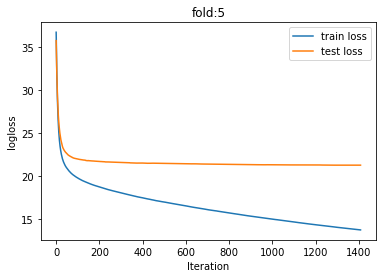

RMSE: [22.766993472453294, 21.595810532602133, 22.239013050225783, 22.95975976444065, 21.268448527378656]
RMSE: 22.166005069420102


In [73]:
import optuna
def objective(trial):

    params = {
            'task': 'train',                 # タスクを訓練に設定
            'boosting_type': 'gbdt',         # GBDTを指定
            'objective': 'rmse',              # 回帰の損失（誤差）
            'feature_pre_filter':False,
            'learning_rate': trial.suggest_uniform('learning_rate', 0.1, 1.0),  # 学習率
            'num_leaves': trial.suggest_int("num_leaves", 2, 256),
            'tree_learner': trial.suggest_categorical('tree_learner', ["serial", "feature", "data", "voting"]),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
            'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
            'random_state': config.random_seed,                    # シード値
            'force_row_wise':True 
            }

    model = lgb.train(
                    params=params,                    # ハイパーパラメータをセット
                    train_set=lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_valid], # 訓練データとテストデータをセット
                    fobj=None,
                    feval=None,        
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=lgb_fit_params['num_boost_rounds'],              # 計算回数
                    callbacks=[
                        lgb.log_evaluation(lgb_fit_params['verbose_eval']),                  # ログを最後の1つだけ表示
                        lgb.record_evaluation(lgb_results),
                        lgb.early_stopping(lgb_fit_params['early_stopping_rounds'])         # アーリーストッピング設定 
                    ]
                    )   
    # 推論
    y_pred = model.predict(x_valid)

    # 評価
    rmse = mean_squared_error(y_valid, y_pred, squared=False)

    return rmse

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'rmse',             # 回帰の損失（誤差）
          'feature_pre_filter':False,
          'learning_rate': 0.1,         # 学習率
          'random_state': config.random_seed,                 # シード値
          'force_row_wise':True 
          }

cv_result_opt2 = []


models = []
n_records = target.shape[0]
oof_pred = np.zeros(n_records, dtype=np.float32)
fold = 0
data_labels = [re.sub(r'[",\[\]{}:()]', '_', c) for c in df_train.columns.tolist()]

params.update(deterministic = True)
    
best_params, history = {}, []
    
for trn_idx, val_idx in gkf_cv:

    fold += 1
    x_train, x_valid = df_train.iloc[trn_idx].values, df_train.iloc[val_idx].values
    y_train, y_valid = np.array(target.iloc[trn_idx]), np.array(target.iloc[val_idx])

    lgb_train = lgb.Dataset(x_train, y_train, feature_name=data_labels)
    lgb_valid = lgb.Dataset(x_valid, y_valid, feature_name=data_labels, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物
        
    study = optuna.create_study()
    study.optimize(objective, n_trials=100)

    print(study.best_params)

    best_params = study.best_params

    add_params = {
        'objective':'rmse', 
        'task': 'train', 
        'feature_pre_filter':False,
        'random_state': config.random_seed,
        }

    best_params.update(add_params)

    print(best_params)

        
    model = lgb.train(
                params=params,                    # ハイパーパラメータをセット
                train_set=lgb_train,              # 訓練データを訓練用にセット
                valid_sets=[lgb_train, lgb_valid], # 訓練データとテストデータをセット
                fobj=None,
                feval=None,        
                valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                num_boost_round=lgb_fit_params['num_boost_rounds'],              # 計算回数
                callbacks=[
                        lgb.log_evaluation(lgb_fit_params['verbose_eval']),                  # ログを最後の1つだけ表示
                        lgb.record_evaluation(lgb_results),
                        lgb.early_stopping(lgb_fit_params['early_stopping_rounds'])         # アーリーストッピング設定 
                    ]
                ) 

    # 損失推移を表示
    #loss_train = lgb_results['Train']['rmse']
    #loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(x_valid)

    # 評価
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    cv_result_opt2.append(rmse)

print("RMSE:", cv_result_opt2)
print("RMSE:", np.mean(cv_result_opt2))

In [74]:
print(best_params)

{'learning_rate': 0.10108320470172451, 'num_leaves': 94, 'tree_learner': 'data', 'reg_alpha': 2.428351870880002e-05, 'reg_lambda': 2.848494478671698e-08, 'colsample_bytree': 0.9523758726334526, 'subsample': 0.9245714841670303, 'subsample_freq': 1, 'min_data_in_leaf': 30, 'objective': 'rmse', 'task': 'train', 'feature_pre_filter': False, 'random_state': 2022}
